### 1. Clean Parquet data from Kaggle (integer dtypes parquet)
- This notebook aims to further clean the data taken from Kaggle's user, without affecting data quality

In [1]:
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format
import matplotlib.pyplot as plt
import gc
import numpy as np
import os
import sys
import time
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")

In [2]:
from pathlib import Path
rootpath = Path.cwd().parent
sys.path.append(os.path.join(rootpath))

In [3]:
from utils.eval_helpers import (
    plot_roc_curves, plot_feature_importance, 
    amex_metric, get_final_metric_df, amex_metric_np, lgb_amex_metric
)
from utils.eda_helpers import (
    plot_missing_proportion_barchart, get_cols, plot_scatterplot, plot_target_check, 
    plot_int_feature_distribution, plot_train_test_distribution, check_overlap_missing,
    insert_row_number
)
from utils.extraction_helpers import read_file
from utils.feature_group import (
    CATEGORY_COLUMNS, CONTINUOUS_COLUMNS, BINARY_COLUMNS,
    MEAN_FEATURES, MIN_FEATURES, MAX_FEATURES, LAST_FEATURES, NON_FEATURE_COLUMNS
)
from utils.constants import (
    PROCESSED_DATA_PATH
)
from utils.feature_engineering_helpers import integerize

In [4]:
RAW_DATA_PATH = "../raw_data"
PROCESSED_DATA_PATH = "../processed_data"
SUBMISSION_DATA_PATH = "../submissions"
EVALUATION_DATA_PATH = "../evaluation_data"
MODELS_PATH = "../models"

In [5]:
RAW_TRAIN_PARQUET_PATH = os.path.join(RAW_DATA_PATH, "train_parquet")
RAW_TRAIN_PICKLE_PATH = os.path.join(RAW_DATA_PATH, "train_pickle")
RAW_TEST_PARQUET_PATH = os.path.join(RAW_DATA_PATH, "test_parquet")
RAW_TEST_PICKLE_PATH = os.path.join(RAW_DATA_PATH, "test_pickle")

In [6]:
%load_ext autoreload
%autoreload

In [7]:
START = time.time()

### Read Data

In [8]:
%%time
train = read_file(f"{RAW_TRAIN_PARQUET_PATH}/train_psrb.parquet", replace_negative127=True)
test = read_file(f"{RAW_TEST_PARQUET_PATH}/test_psrb.parquet", replace_negative127=True)

Shape of data: (5531451, 191)
Shape of data: (11363762, 190)
CPU times: user 16.7 s, sys: 19.6 s, total: 36.3 s
Wall time: 23.5 s


In [9]:
%%time
labels = pd.read_csv(f"{RAW_DATA_PATH}/train_labels.csv")
if "target" not in train.columns:
    train = train.merge(labels, on="customer_ID", how="left")

CPU times: user 266 ms, sys: 26.5 ms, total: 292 ms
Wall time: 295 ms


In [10]:
print(get_cols(train, "D_"))

['D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_49', 'D_50', 'D_51', 'D_52', 'D_53', 'D_54', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_61', 'D_62', 'D_63', 'D_64', 'D_65', 'D_66', 'D_68', 'D_69', 'D_70', 'D_71', 'D_72', 'D_73', 'D_74', 'D_75', 'D_76', 'D_77', 'D_78', 'D_79', 'D_80', 'D_81', 'D_82', 'D_83', 'D_84', 'D_86', 'D_87', 'D_88', 'D_89', 'D_91', 'D_92', 'D_93', 'D_94', 'D_96', 'D_102', 'D_103', 'D_104', 'D_105', 'D_106', 'D_107', 'D_108', 'D_109', 'D_110', 'D_111', 'D_112', 'D_113', 'D_114', 'D_115', 'D_116', 'D_117', 'D_118', 'D_119', 'D_120', 'D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_126', 'D_127', 'D_128', 'D_129', 'D_130', 'D_131', 'D_132', 'D_133', 'D_134', 'D_135', 'D_136', 'D_137', 'D_138', 'D_139', 'D_140', 'D_141', 'D_142', 'D_143', 'D_144', 'D_145']


### D_39

0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


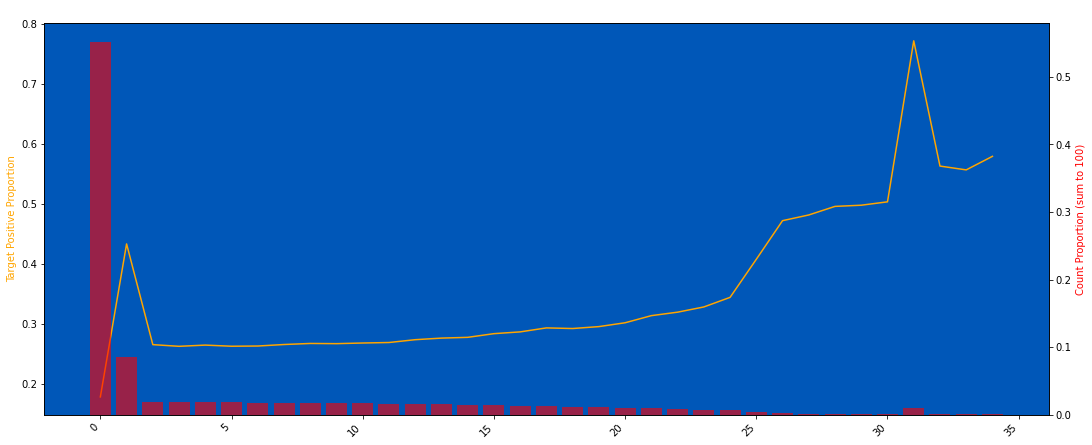

In [11]:
plot_target_check(train, "D_39", q=50, use_raw_bin=True, nunique_thr=1000)

Bottom 1% and Top 1% are dropped from this chart


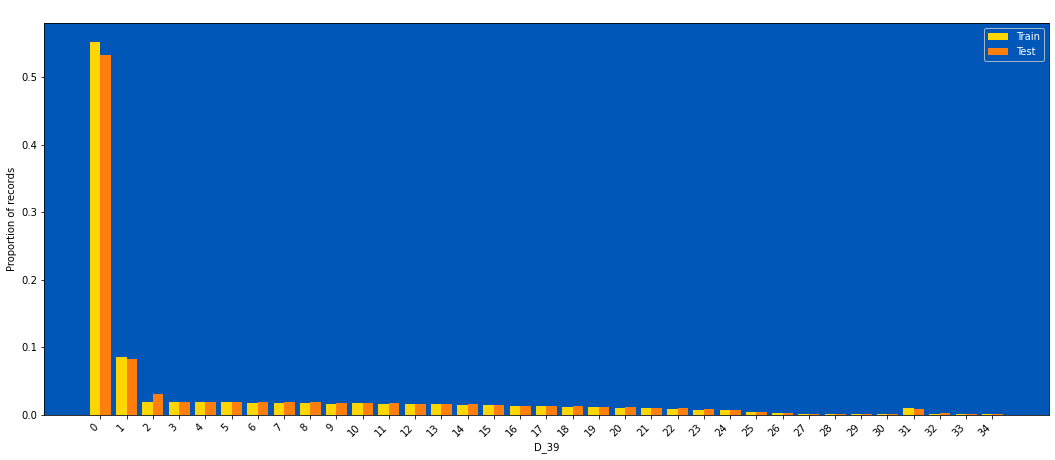

In [12]:
plot_train_test_distribution(train, test, "D_39", nunique_thr=1000)

### D_41

2016 null count, 0.000 null proportion
0.3562 of the targets have label = 1


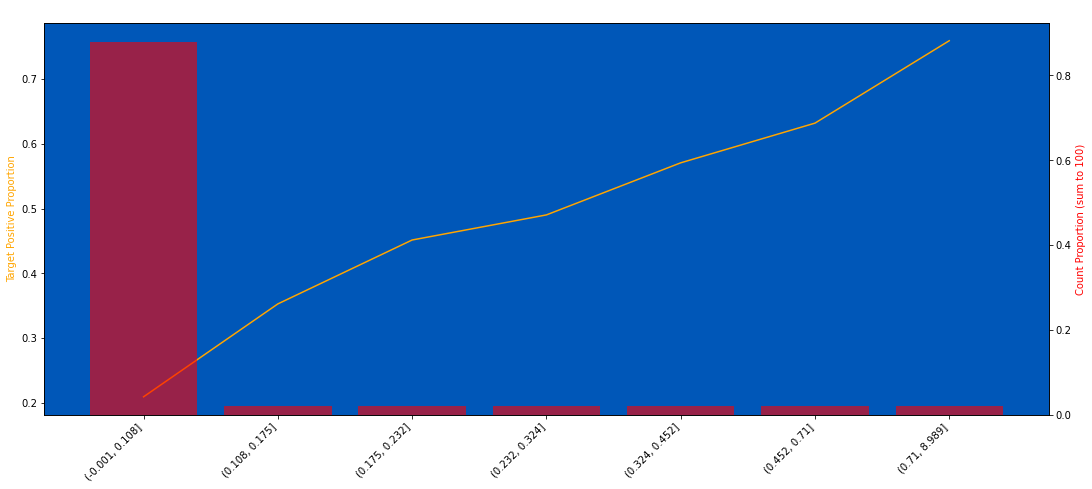

In [13]:
plot_target_check(train, "D_41", q=50, use_raw_bin=True)

In [14]:
train["D_41"] = train["D_41"].round(2)
test["D_41"] = test["D_41"].round(2)

2016 null count, 0.000 null proportion
0.3562 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


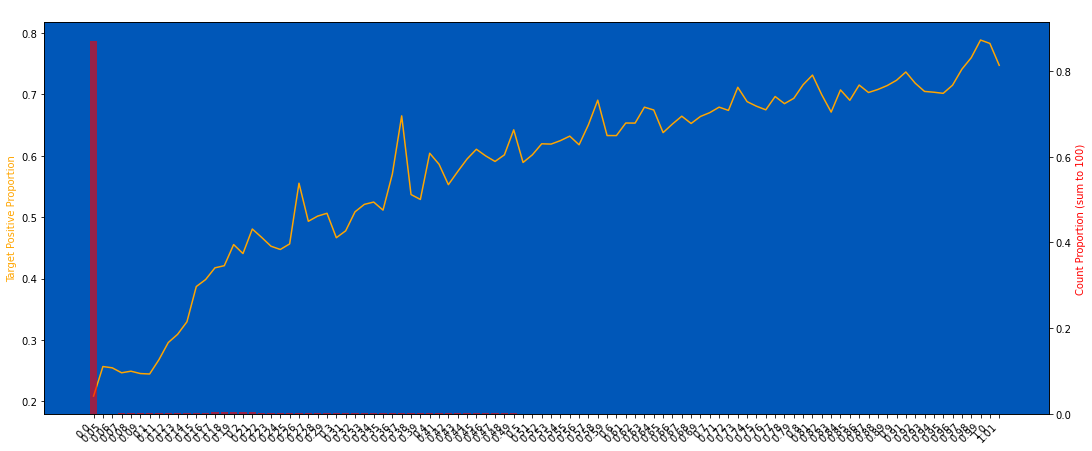

In [15]:
plot_target_check(train, "D_41", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


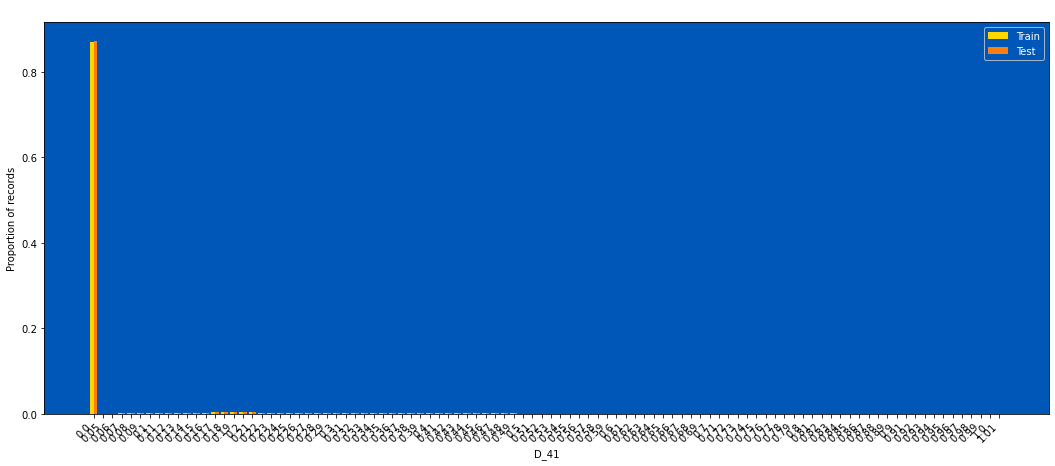

In [16]:
plot_train_test_distribution(train, test, "D_41", nunique_thr=1000)

### D_42

4740137 null count, 0.857 null proportion
0.2075 of the targets have label = 1


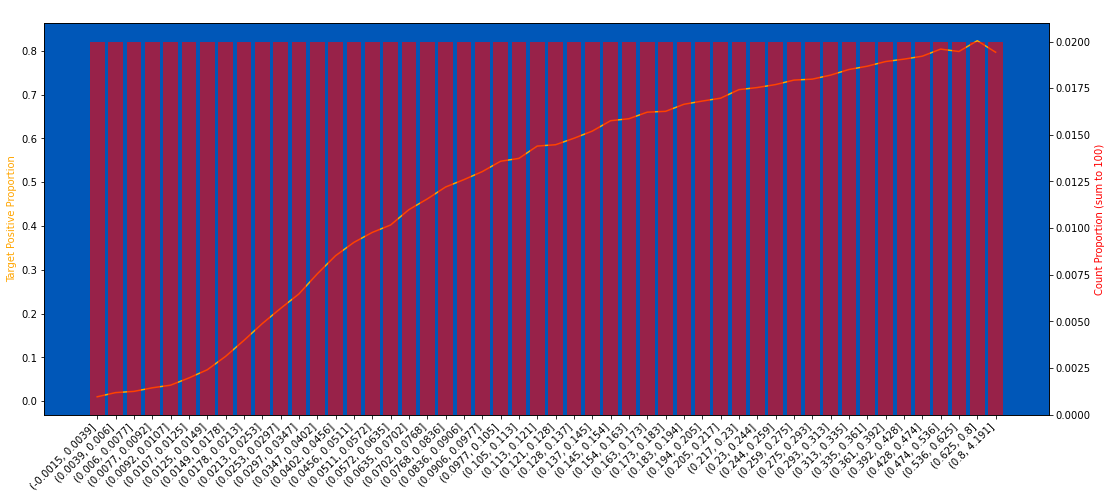

In [17]:
plot_target_check(train, "D_42", q=50, use_raw_bin=True)

In [18]:
train["D_42"] = train["D_42"].round(2)
test["D_42"] = test["D_42"].round(2)

4740137 null count, 0.857 null proportion
0.2075 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


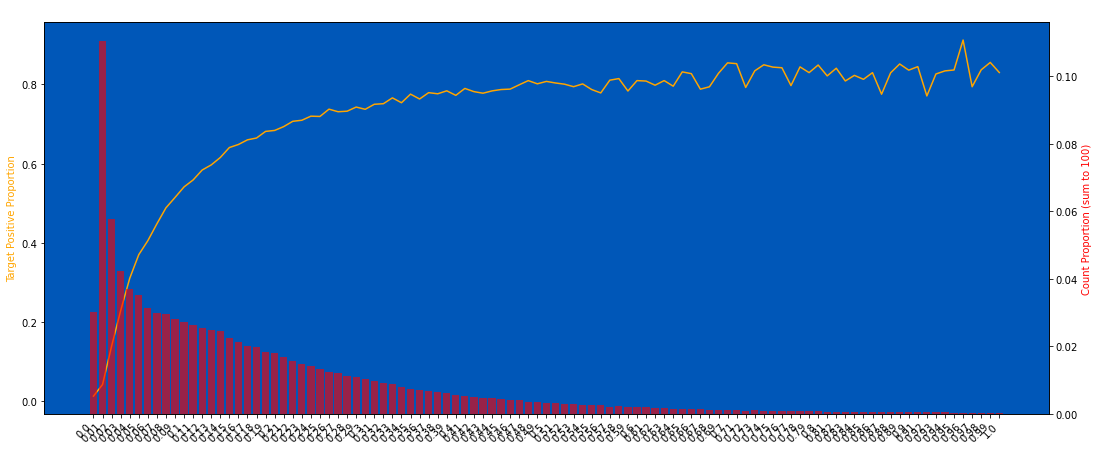

In [19]:
plot_target_check(train, "D_42", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


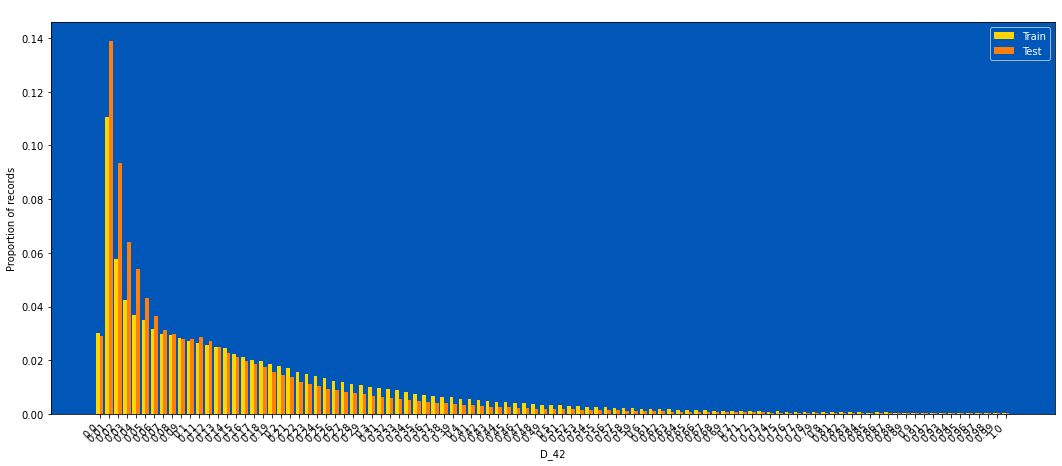

In [20]:
plot_train_test_distribution(train, test, "D_42", nunique_thr=1000)

### D_43

1658396 null count, 0.300 null proportion
0.1673 of the targets have label = 1


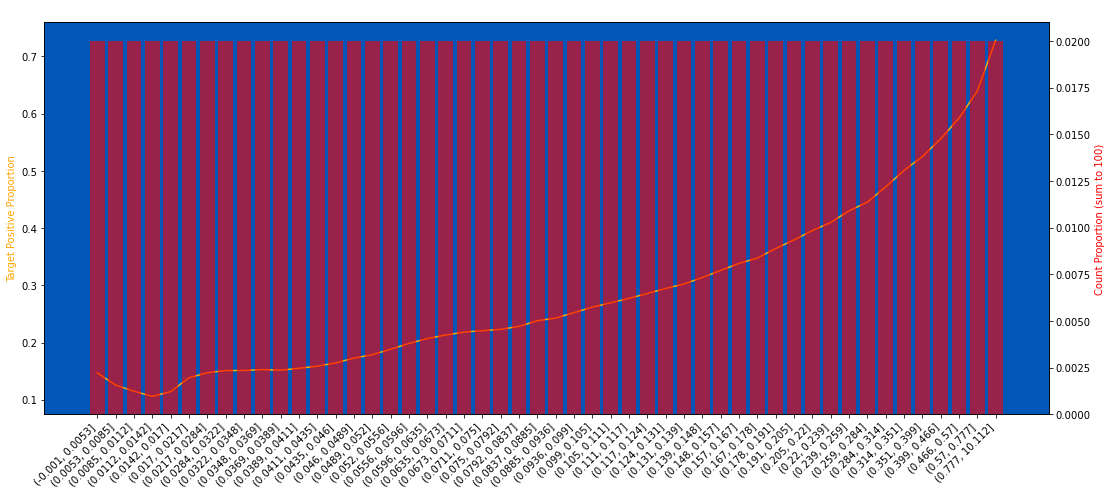

In [21]:
plot_target_check(train, "D_43", q=50, use_raw_bin=True)

In [22]:
train["D_43"] = train["D_43"].round(2)
test["D_43"] = test["D_43"].round(2)

1658396 null count, 0.300 null proportion
0.1673 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


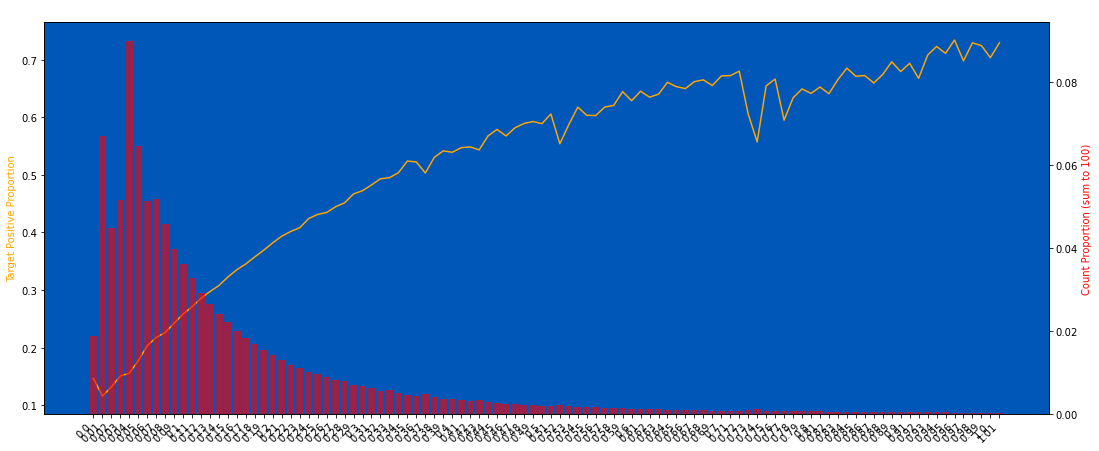

In [23]:
plot_target_check(train, "D_43", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


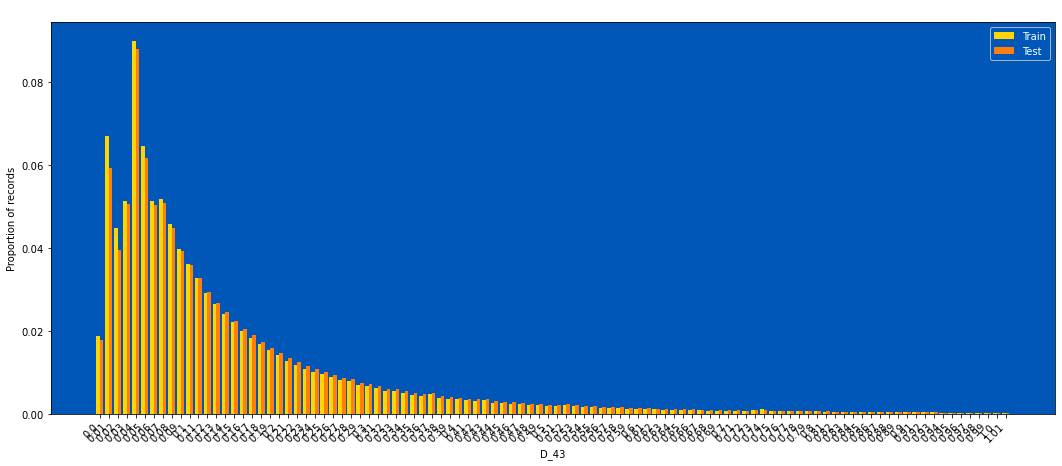

In [24]:
plot_train_test_distribution(train, test, "D_43", nunique_thr=1000)

### D_44

274319 null count, 0.050 null proportion
0.2406 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


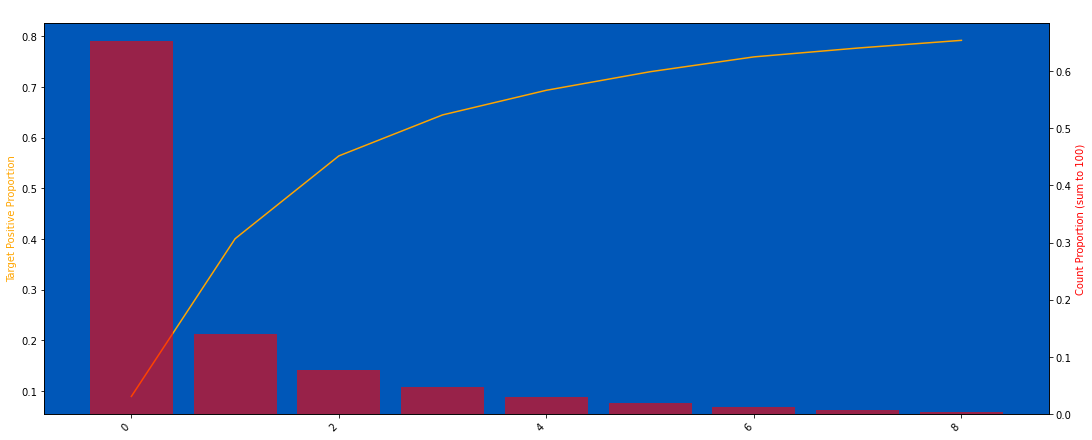

In [25]:
plot_target_check(train, "D_44", q=50, use_raw_bin=True, nunique_thr=1000)

Bottom 1% and Top 1% are dropped from this chart


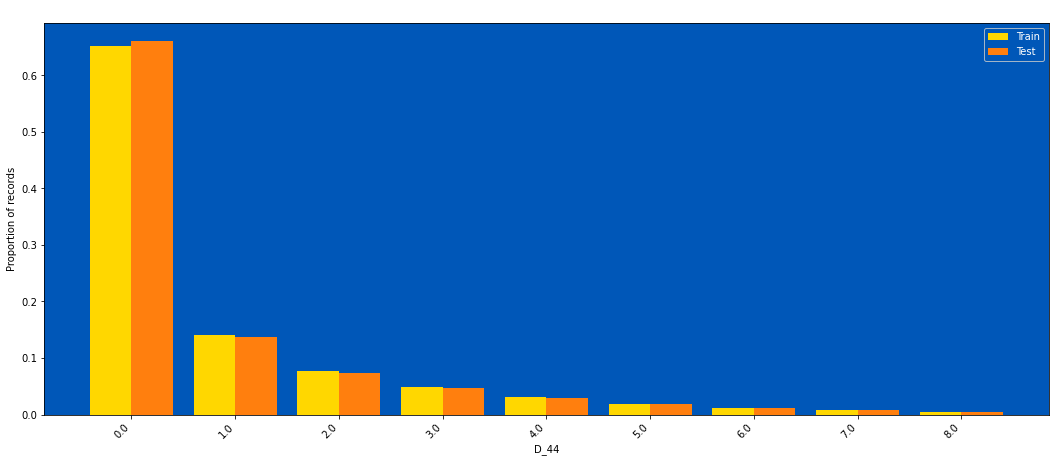

In [26]:
plot_train_test_distribution(train, test, "D_44")

### D_45

2017 null count, 0.000 null proportion
0.3560 of the targets have label = 1


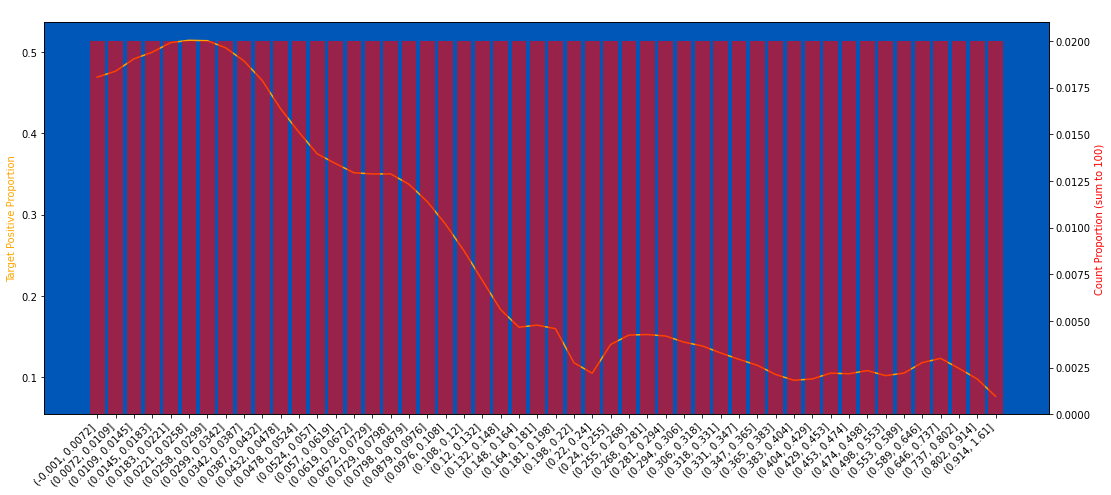

In [27]:
plot_target_check(train, "D_45", q=50, use_raw_bin=True)

In [28]:
train["D_45"] = train["D_45"].round(2)
test["D_45"] = test["D_45"].round(2)

2017 null count, 0.000 null proportion
0.3560 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


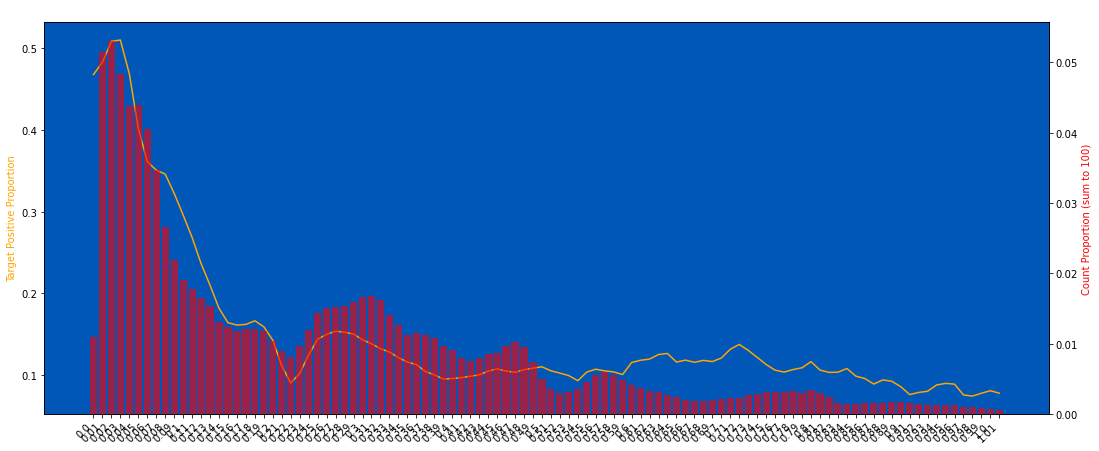

In [29]:
plot_target_check(train, "D_45", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


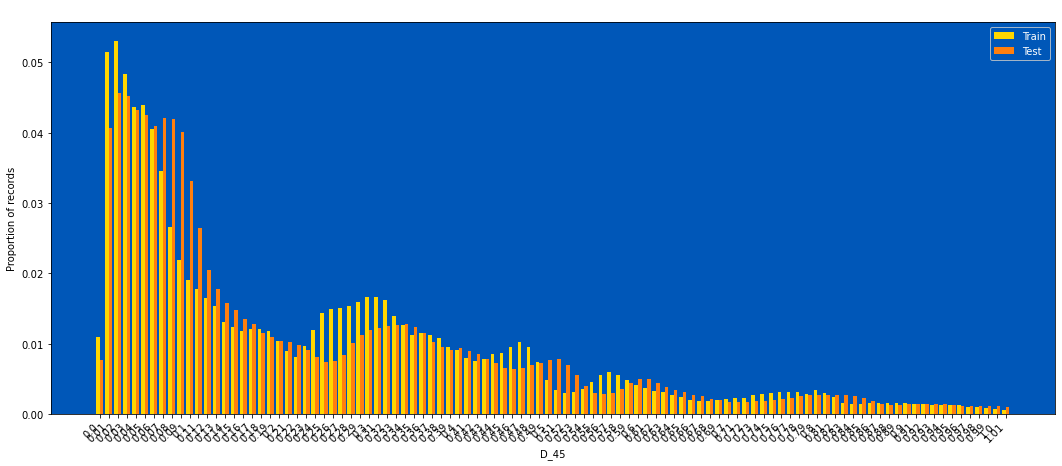

In [30]:
plot_train_test_distribution(train, test, "D_45", nunique_thr=8000)

### D_46

1211699 null count, 0.219 null proportion
0.1940 of the targets have label = 1


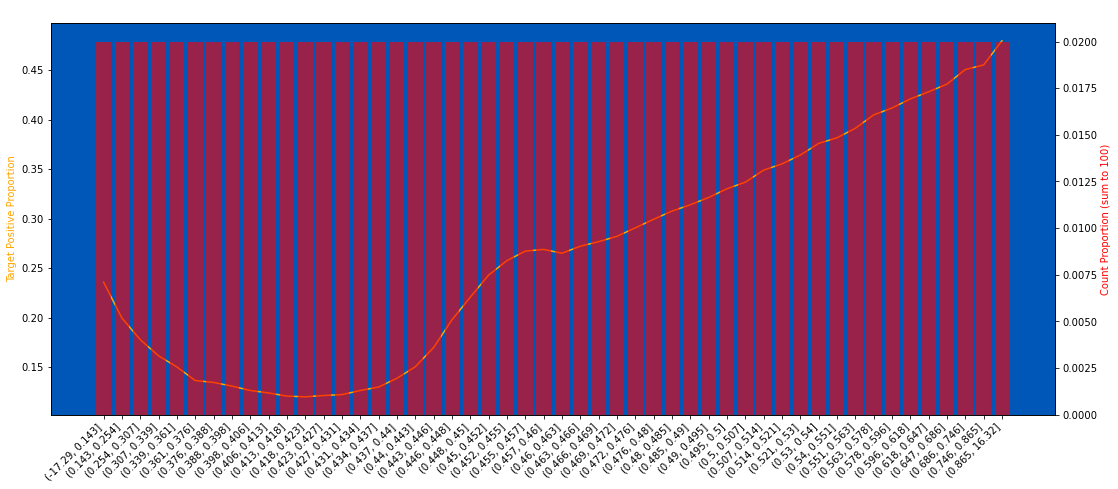

In [31]:
plot_target_check(train, "D_46", q=50, use_raw_bin=True)

In [32]:
train["D_46"] = train["D_46"].round(2)
test["D_46"] = test["D_46"].round(2)

1211699 null count, 0.219 null proportion
0.1940 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


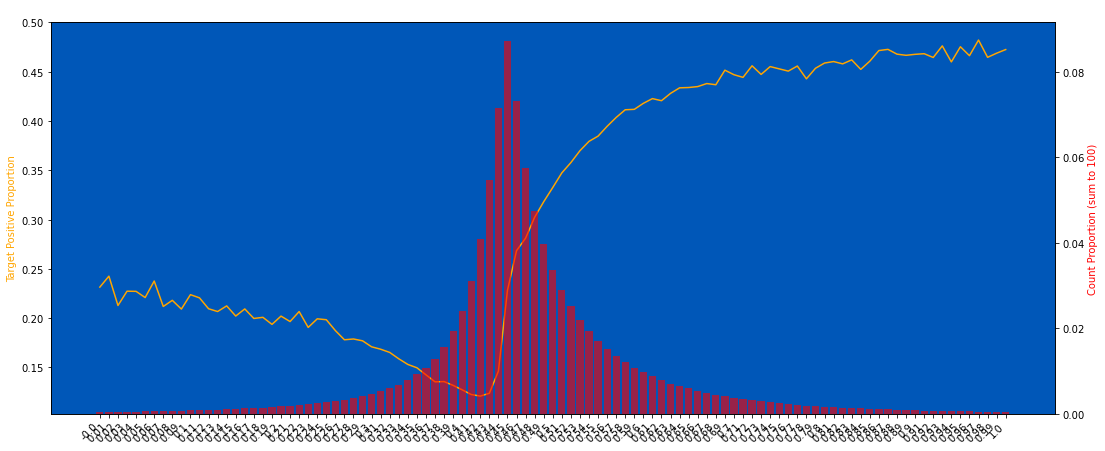

In [33]:
d46_summary = plot_target_check(train, "D_46", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, return_df=True)

Bottom 1% and Top 1% are dropped from this chart


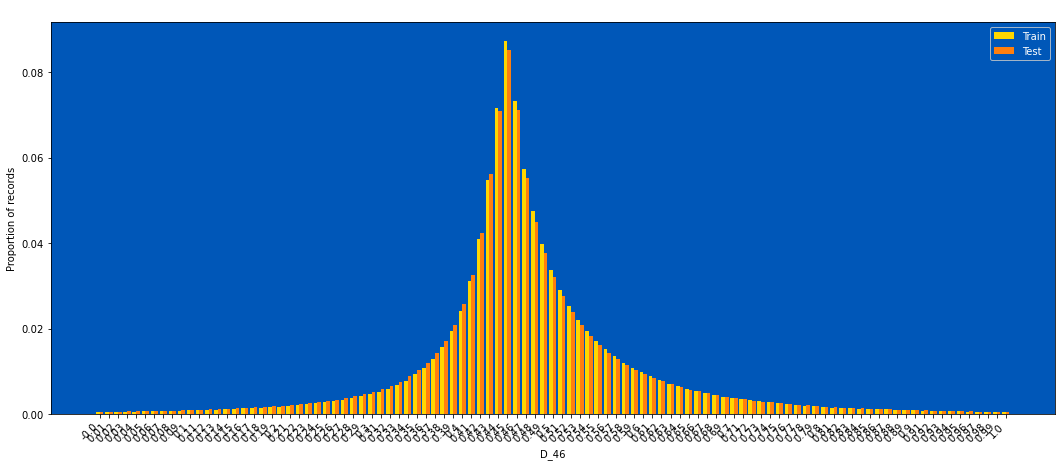

In [34]:
plot_train_test_distribution(train, test, "D_46", nunique_thr=8000)

### D_46a

In [35]:
d46_summary.loc[d46_summary["D_46"] == d46_summary["D_46"].nsmallest(2).values[-1]]

D_46  target_mean  count_distribution  proportion_distribution
317 0.0100       0.2426                2024                   0.0005

In [36]:
d46_summary.loc[d46_summary["D_46"] == d46_summary["D_46"].nlargest(1).values[-1]]

D_46  target_mean  count_distribution  proportion_distribution
416 1.0000       0.4725                2055                   0.0005

In [37]:
d46_summary.loc[d46_summary["target_mean"] == d46_summary["target_mean"].min()]

D_46  target_mean  count_distribution  proportion_distribution
358 0.4200       0.1209              176659                   0.0409

In [38]:
def revise_d46(x):
    if x < 0.42:
        return (0.42 - x) * (0.2426 - 0.1209) / 0.41
    else:
        return 0

In [39]:
# train["S_12a"] = (train["S_12"] - 0.2).apply(lambda x: right_grad * x if x >= 0 else -left_grad * x) * 10
# test["S_12a"] = (test["S_12"] - 0.2).apply(lambda x: right_grad * x if x >= 0 else -left_grad * x) * 10

In [40]:
# plot_target_check(train, "S_12a", q=50, use_raw_bin=True, nunique_thr=150, figsize=(25, 10))

### D_47

0 null count, 0.000 null proportion
nan of the targets have label = 1


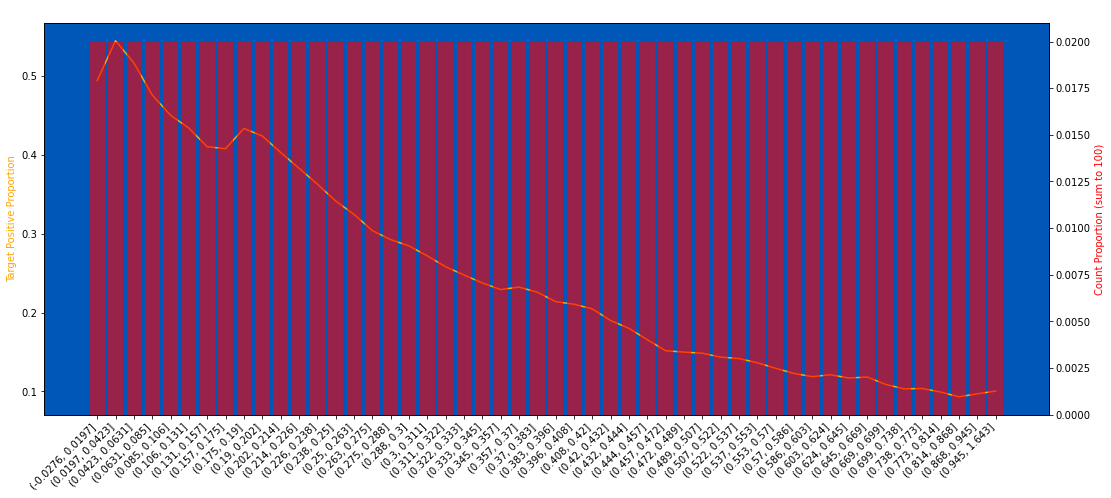

In [41]:
plot_target_check(train, "D_47", q=50, use_raw_bin=True)

In [42]:
train["D_47"] = train["D_47"].round(2)
test["D_47"] = test["D_47"].round(2)

0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


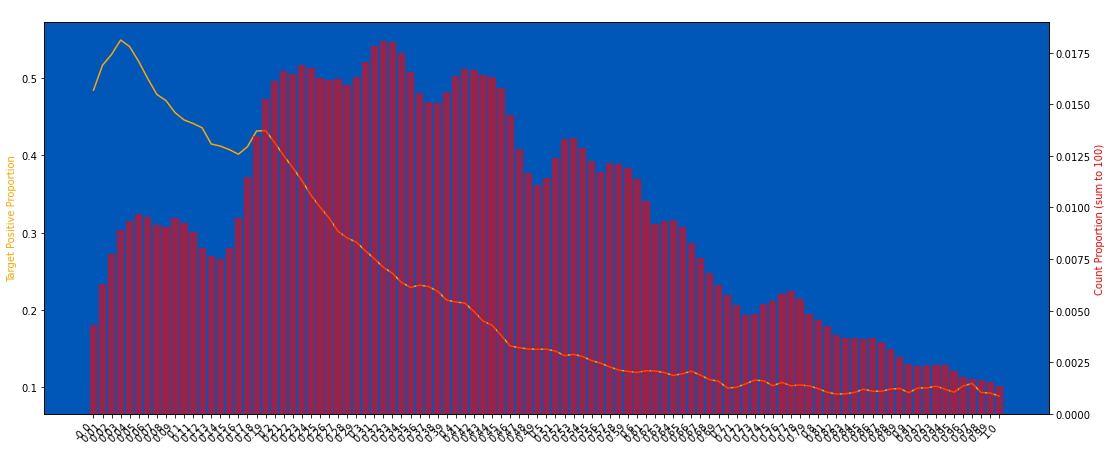

In [43]:
plot_target_check(train, "D_47", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


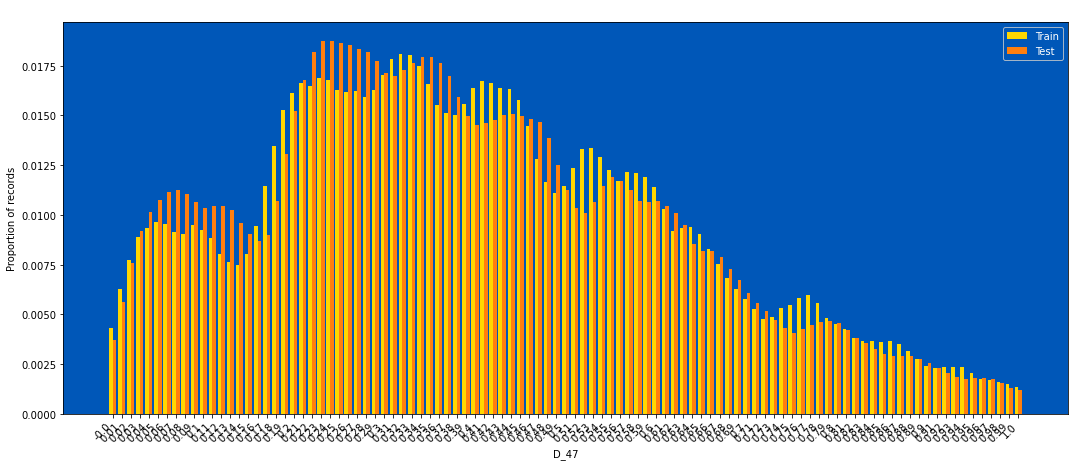

In [44]:
plot_train_test_distribution(train, test, "D_47", nunique_thr=8000)

### D_48

718725 null count, 0.130 null proportion
0.1221 of the targets have label = 1


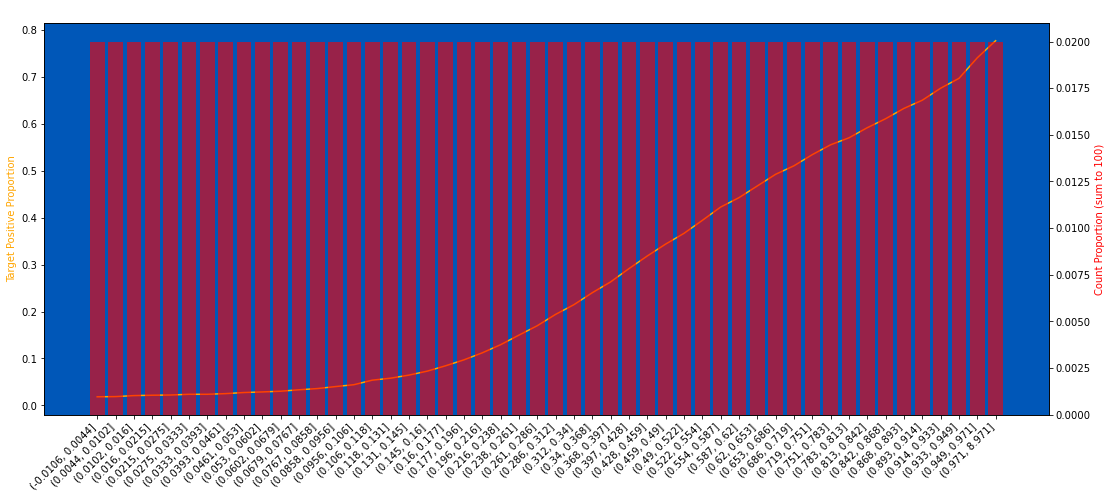

In [45]:
plot_target_check(train, "D_48", q=50, use_raw_bin=True)

In [46]:
train["D_48"] = train["D_48"].round(2)
test["D_48"] = test["D_48"].round(2)

In [47]:
train.loc[train["D_48"].between(1, 1.01), "D_48"] = 1
test.loc[test["D_48"].between(1, 1.01), "D_48"] = 1

718725 null count, 0.130 null proportion
0.1221 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


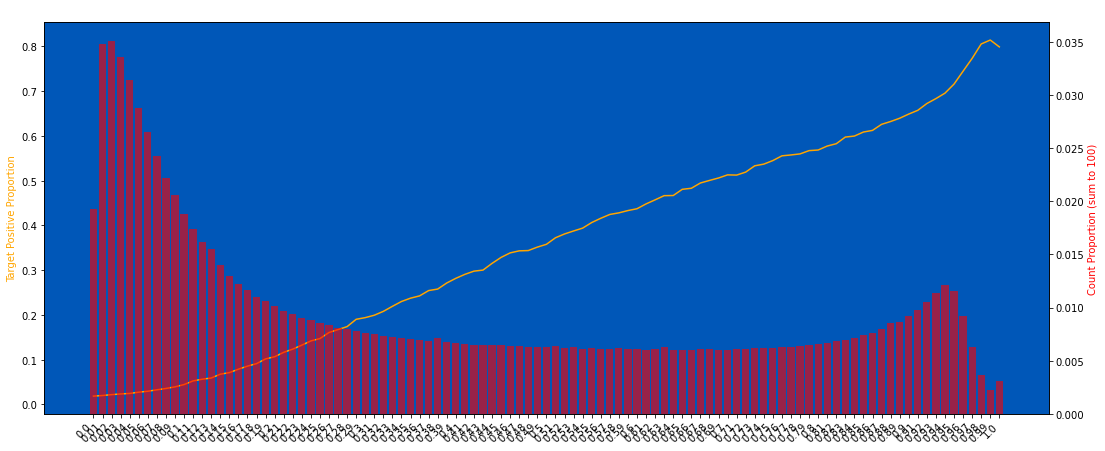

In [48]:
plot_target_check(train, "D_48", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


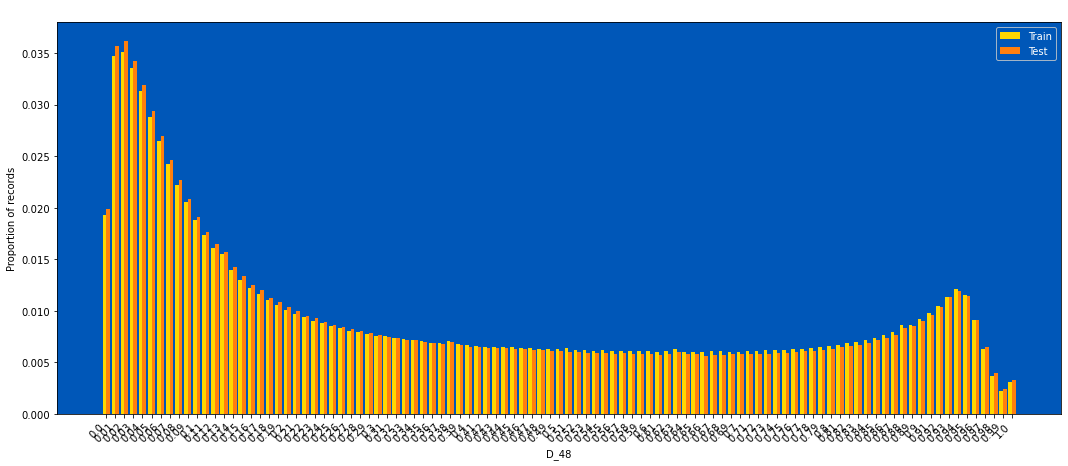

In [49]:
plot_train_test_distribution(train, test, "D_48", nunique_thr=8000)

### D_49

4985917 null count, 0.901 null proportion
0.2162 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


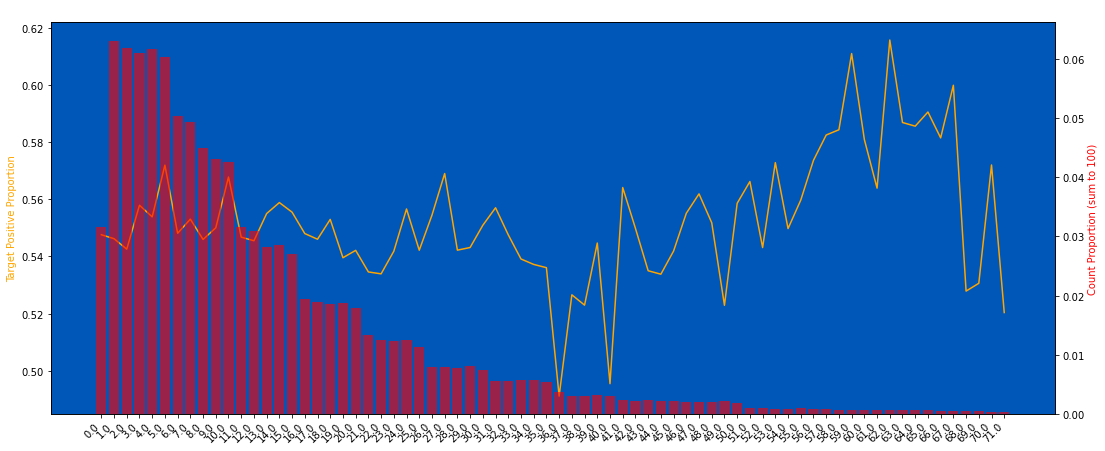

In [50]:
plot_target_check(train, "D_49", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


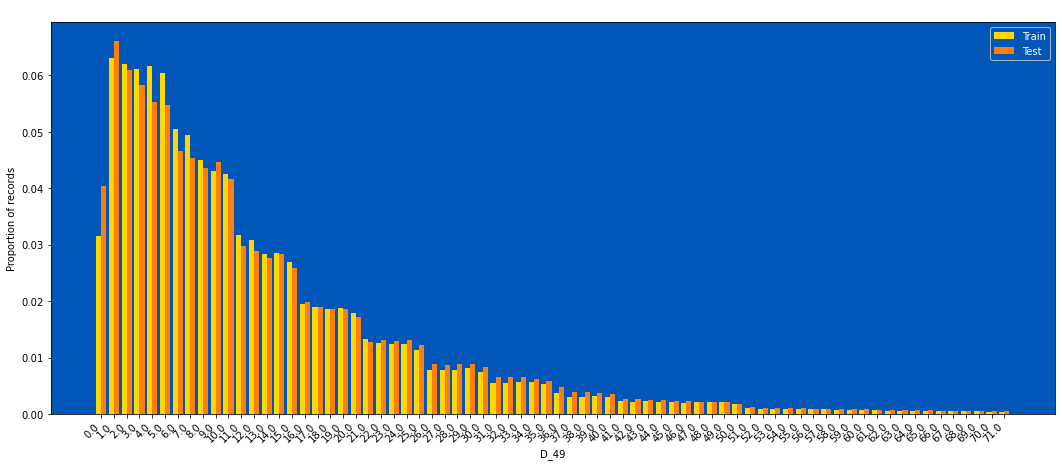

In [51]:
plot_train_test_distribution(train, test, "D_49", nunique_thr=1000)

### D_50

3142402 null count, 0.568 null proportion
0.3005 of the targets have label = 1


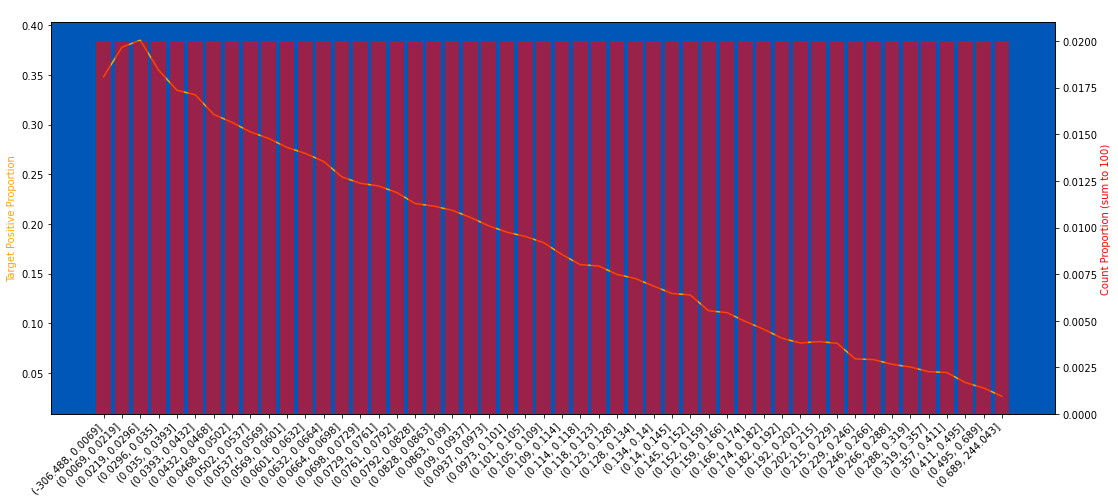

In [52]:
plot_target_check(train, "D_50", q=50, use_raw_bin=True)

In [53]:
train["D_50"] = train["D_50"].round(2)
test["D_50"] = test["D_50"].round(2)

3142402 null count, 0.568 null proportion
0.3005 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


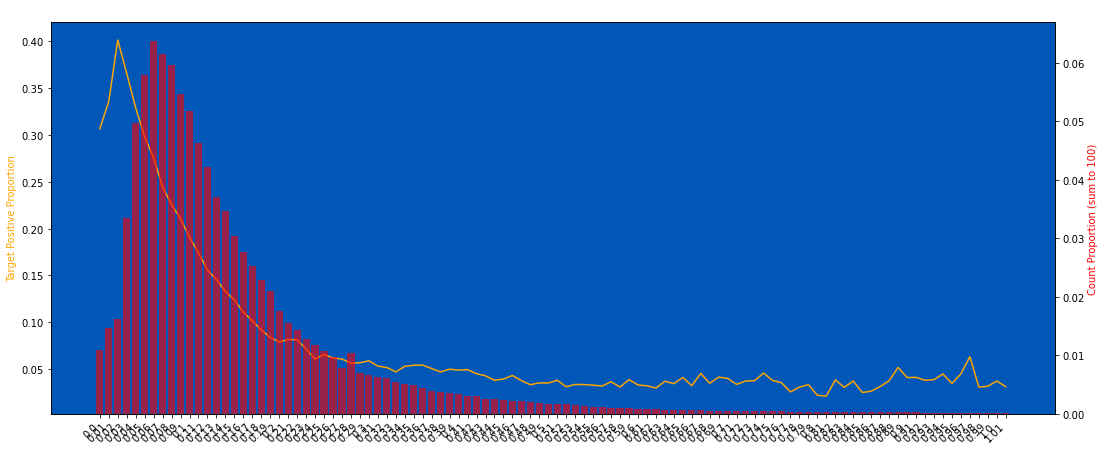

In [54]:
plot_target_check(train, "D_50", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


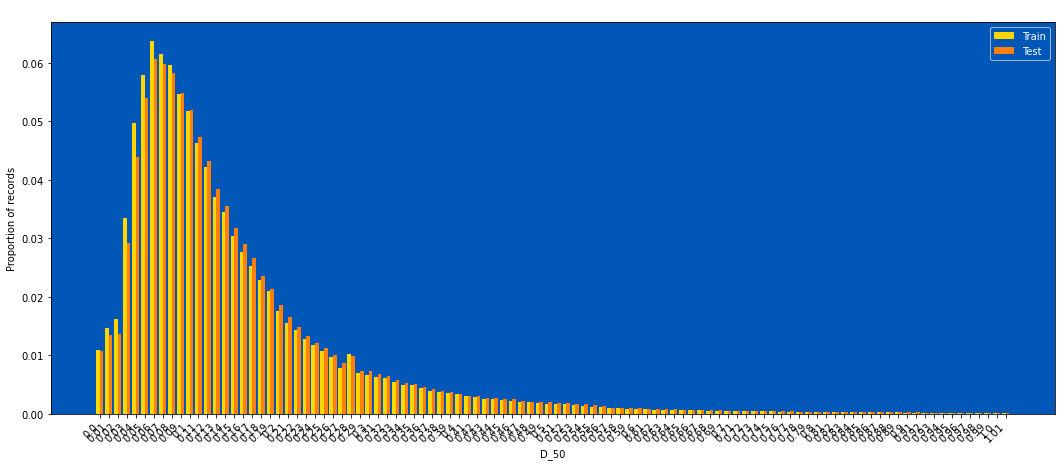

In [55]:
plot_train_test_distribution(train, test, "D_50", nunique_thr=10000)

### D_51

0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


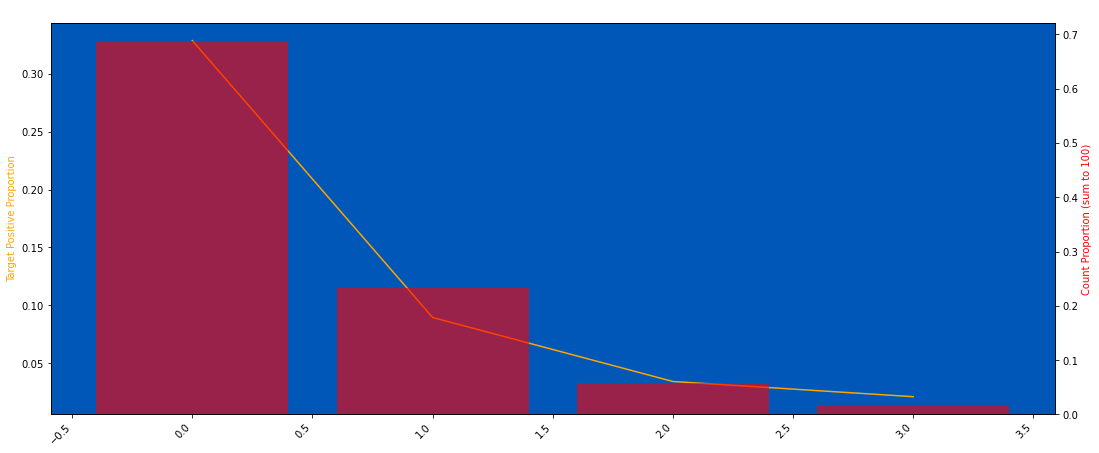

In [56]:
plot_target_check(train, "D_51", q=50, use_raw_bin=True, nunique_thr=10000)

Bottom 1% and Top 1% are dropped from this chart


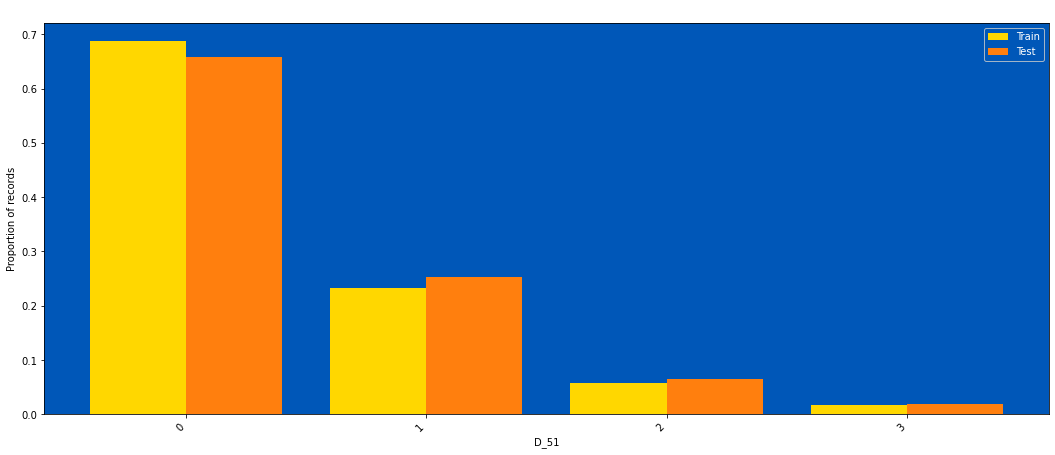

In [57]:
plot_train_test_distribution(train, test, "D_51", nunique_thr=1000)

### D_52

29563 null count, 0.005 null proportion
0.3523 of the targets have label = 1


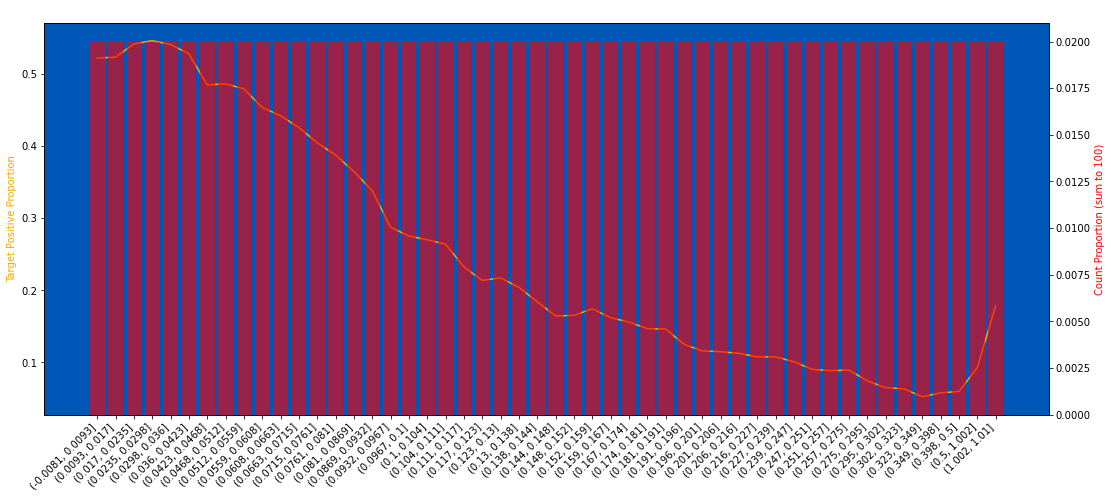

In [58]:
plot_target_check(train, "D_52", q=50, use_raw_bin=True)

In [59]:
train["D_52"] = train["D_52"].round(2)
test["D_52"] = test["D_52"].round(2)

In [60]:
train.loc[train["D_52"].between(0.995, 1.01), "D_52"] = 1
test.loc[test["D_52"].between(0.995, 1.01), "D_52"] = 1

29563 null count, 0.005 null proportion
0.3523 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


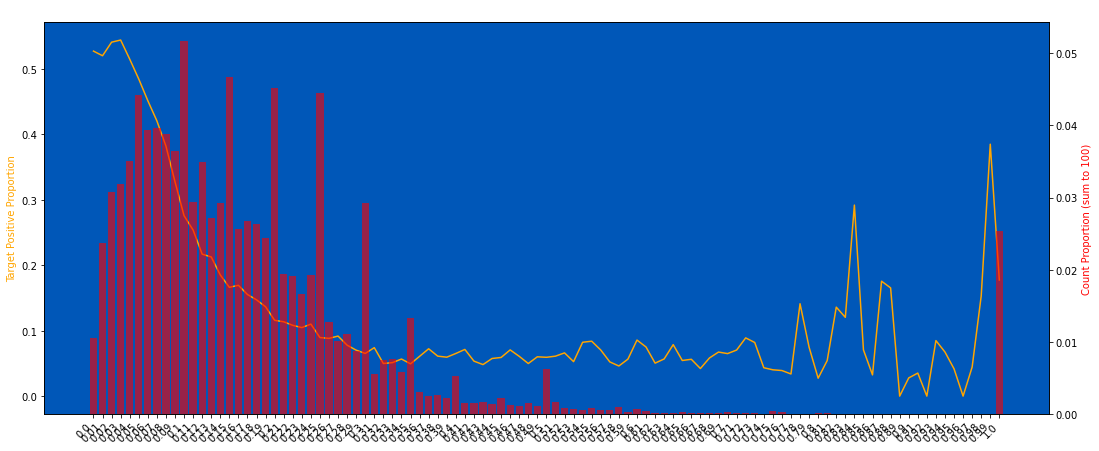

In [61]:
plot_target_check(train, "D_52", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


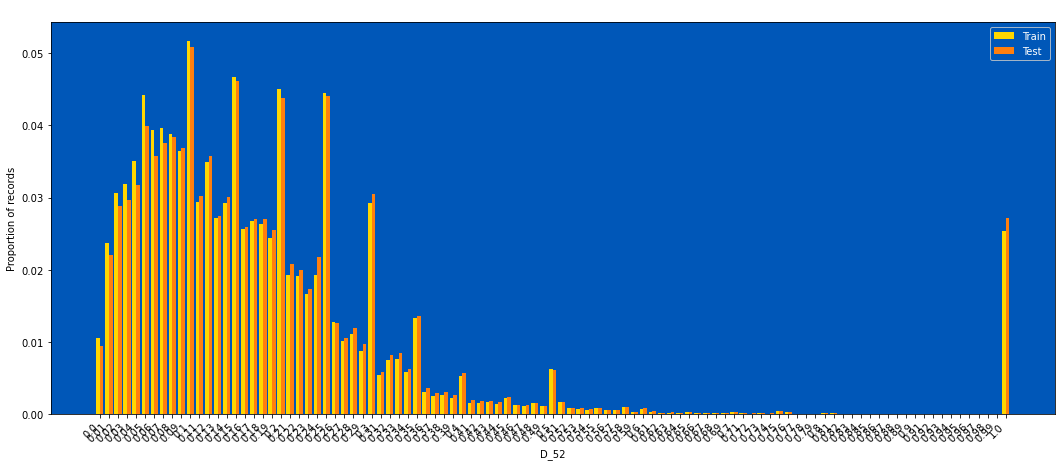

In [62]:
plot_train_test_distribution(train, test, "D_52", nunique_thr=1000)

### D_53

4084585 null count, 0.738 null proportion
0.1836 of the targets have label = 1


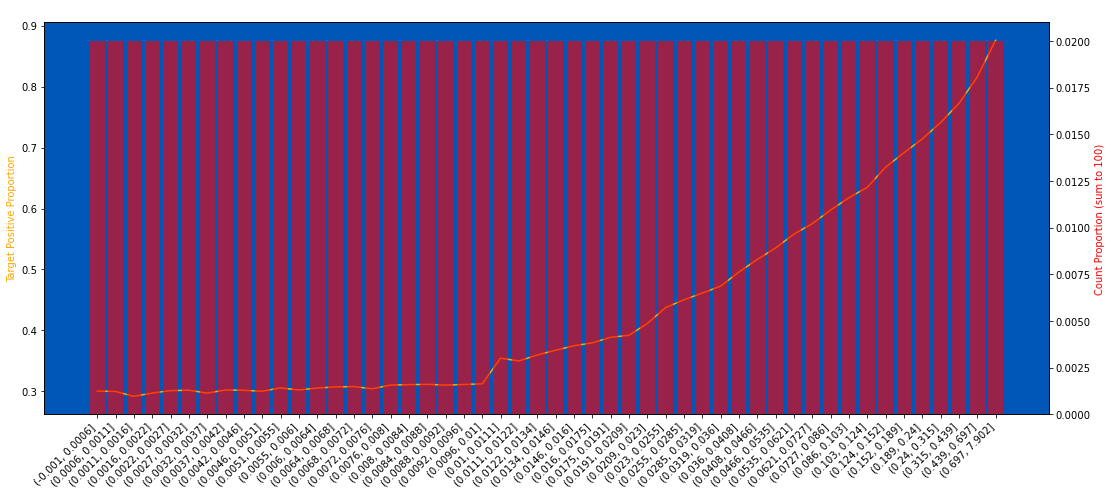

In [63]:
plot_target_check(train, "D_53", q=50, use_raw_bin=True)

In [64]:
train["D_53"] = train["D_53"].round(2)
test["D_53"] = test["D_53"].round(2)

4084585 null count, 0.738 null proportion
0.1836 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


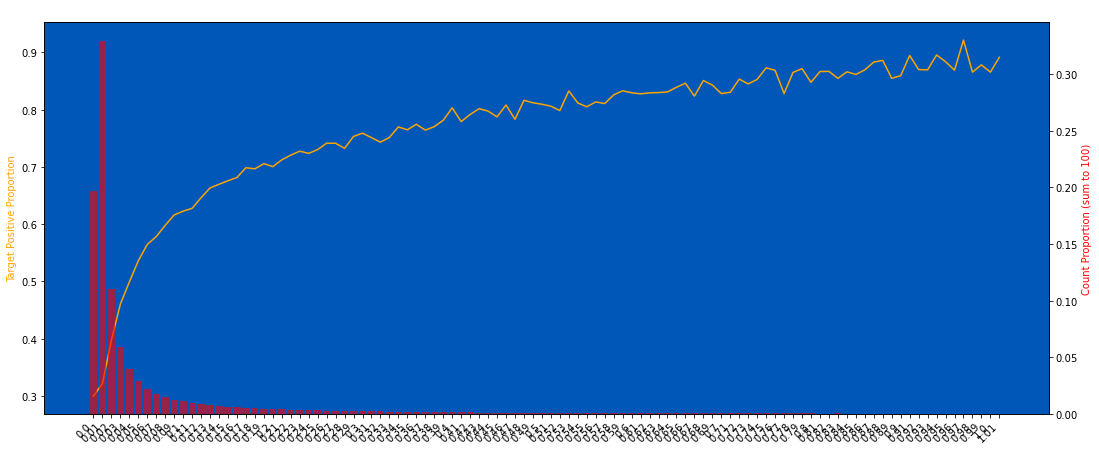

In [65]:
plot_target_check(train, "D_53", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


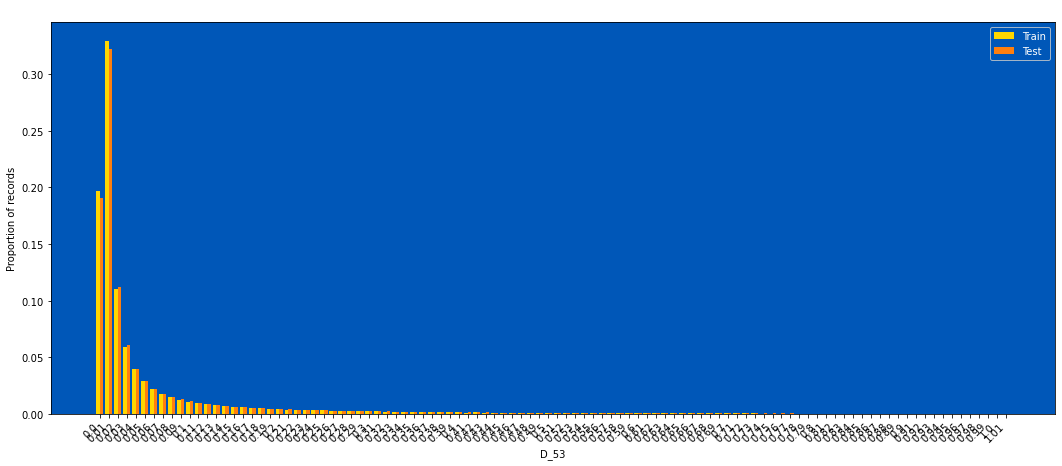

In [66]:
plot_train_test_distribution(train, test, "D_53", nunique_thr=1000)

### D_54

2016 null count, 0.000 null proportion
0.3562 of the targets have label = 1


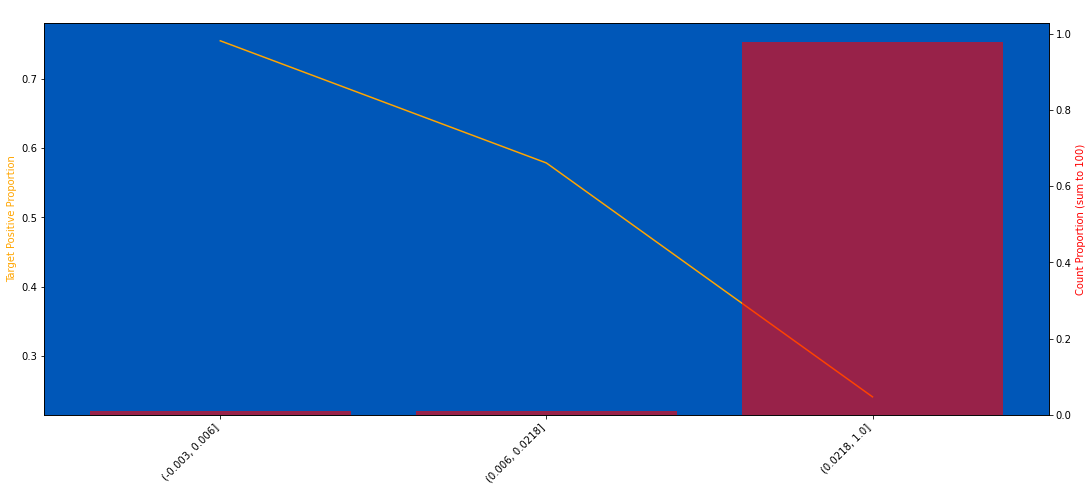

In [67]:
plot_target_check(train, "D_54", q=100, use_raw_bin=True)

In [68]:
# plot_train_test_distribution(train, test, "D_54")

### D_55

184803 null count, 0.033 null proportion
0.1759 of the targets have label = 1


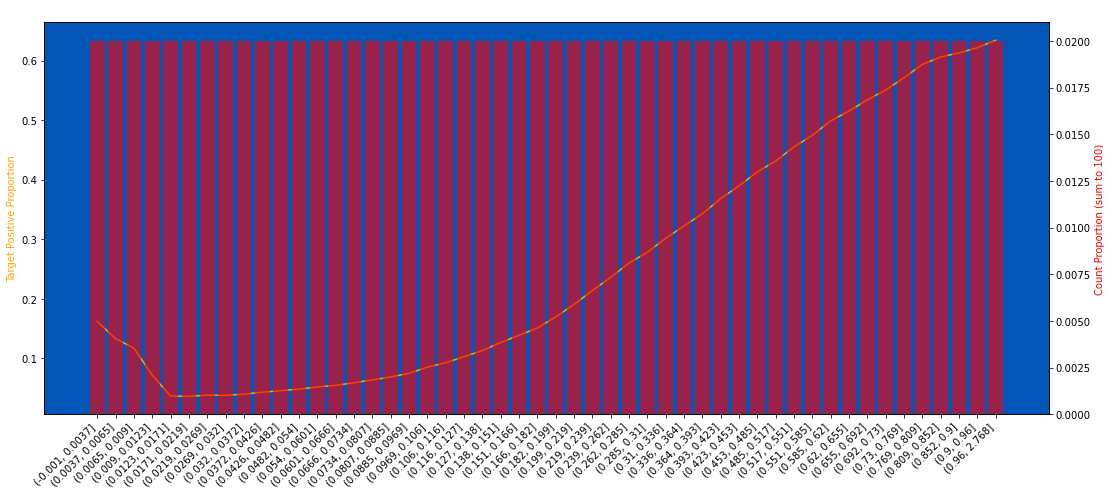

In [69]:
plot_target_check(train, "D_55", q=50, use_raw_bin=True)

In [70]:
train["D_55"] = train["D_55"].round(2)
test["D_55"] = test["D_55"].round(2)

184803 null count, 0.033 null proportion
0.1759 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


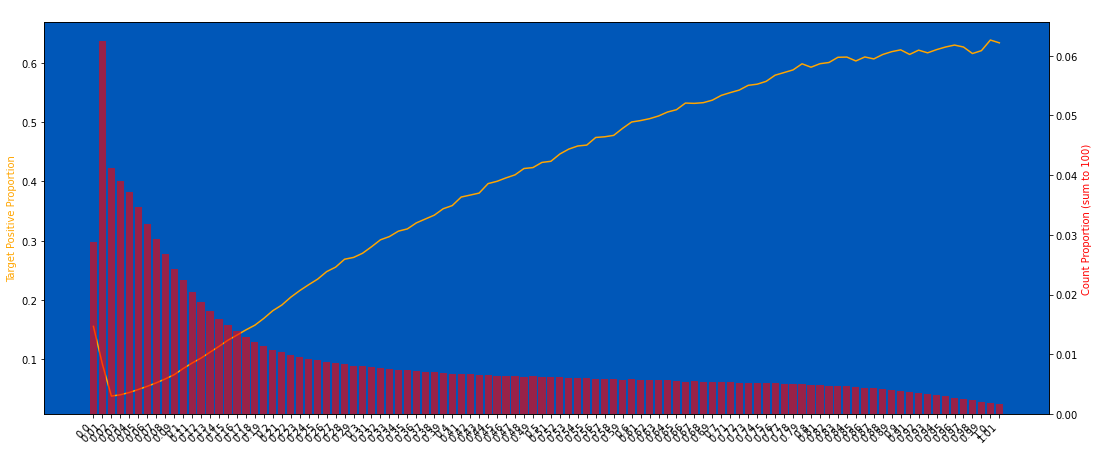

In [71]:
plot_target_check(train, "D_55", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

In [72]:
train.loc[train["D_55"].between(0, 0.01), "D_55"] = np.nan
test.loc[test["D_55"].between(0, 0.01), "D_55"] = np.nan

673204 null count, 0.122 null proportion
0.1288 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


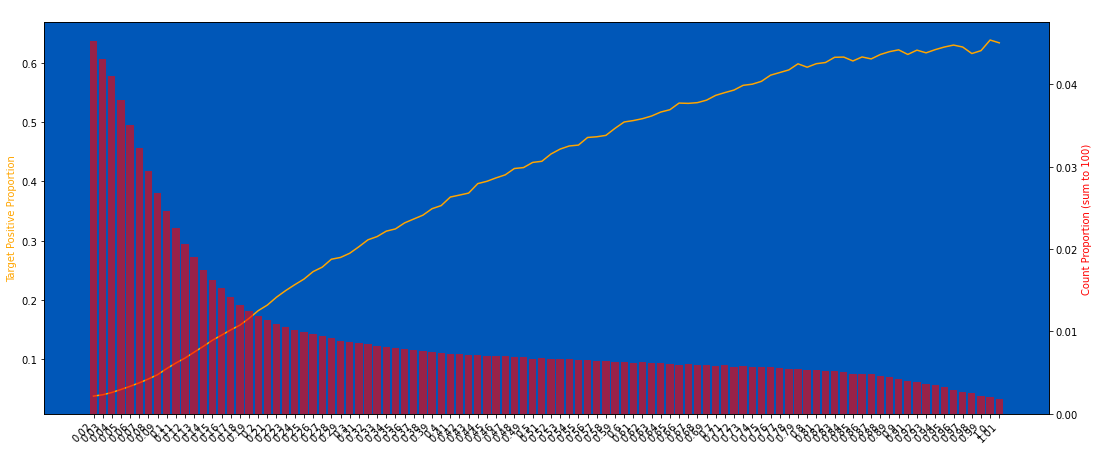

In [73]:
plot_target_check(train, "D_55", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


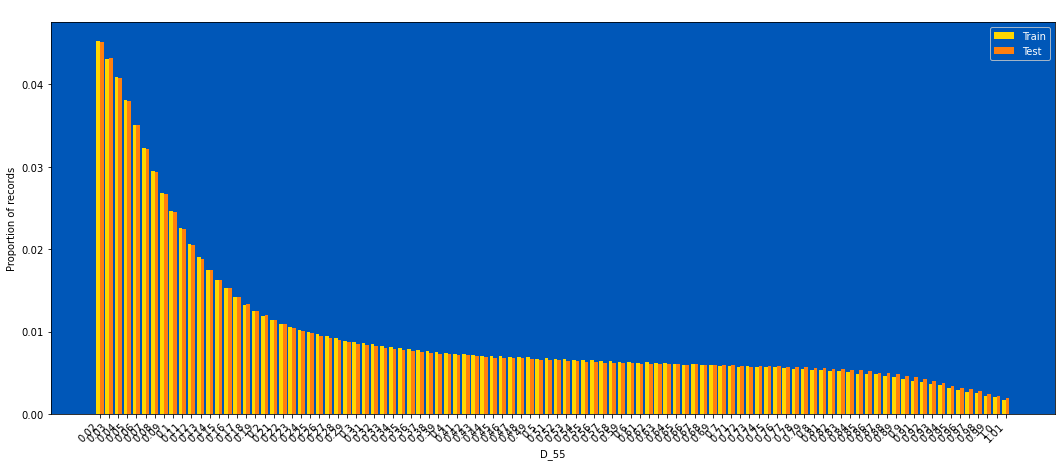

In [74]:
plot_train_test_distribution(train, test, "D_55", nunique_thr=1000)

### D_56

2990943 null count, 0.541 null proportion
0.3282 of the targets have label = 1


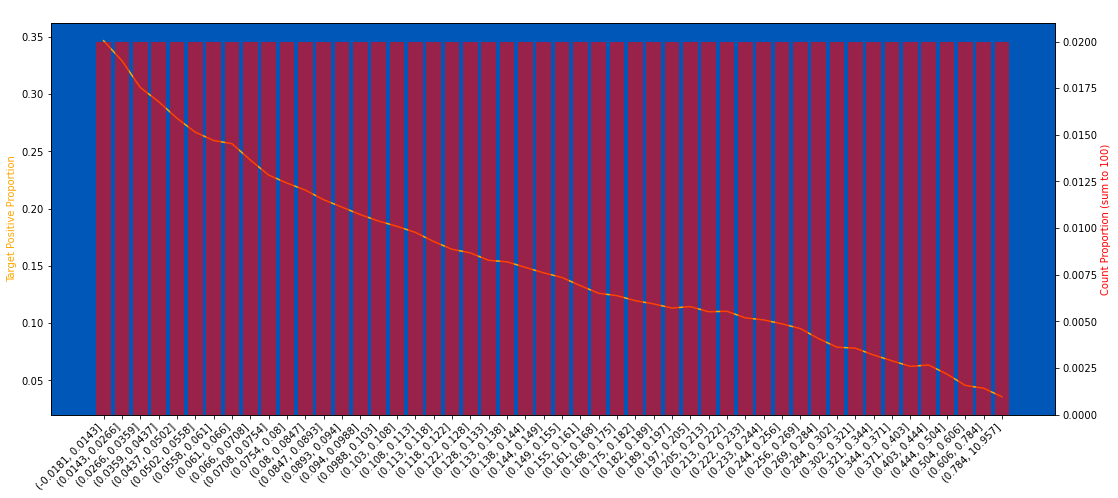

In [75]:
plot_target_check(train, "D_56", q=50, use_raw_bin=True)

In [76]:
train["D_56"] = train["D_56"].round(2)
test["D_56"] = test["D_56"].round(2)

2990943 null count, 0.541 null proportion
0.3282 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


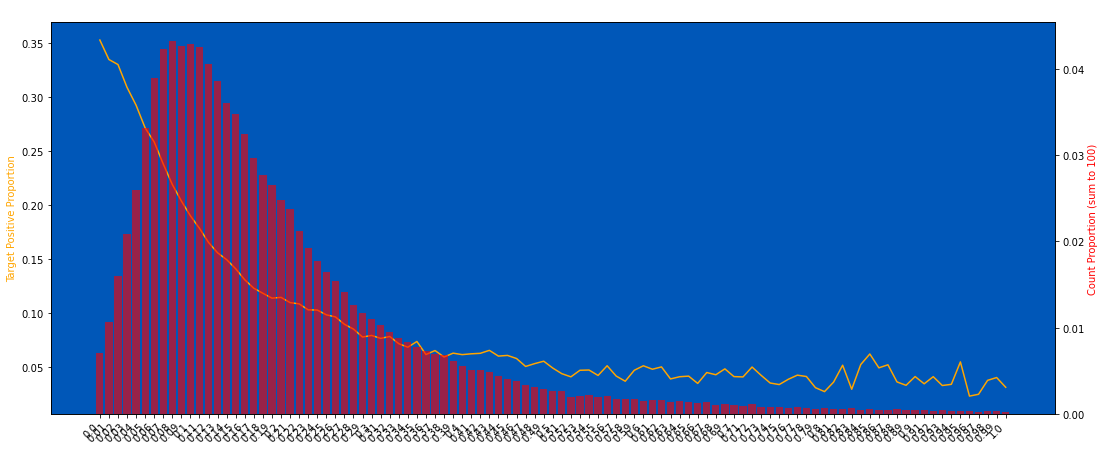

In [77]:
plot_target_check(train, "D_56", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


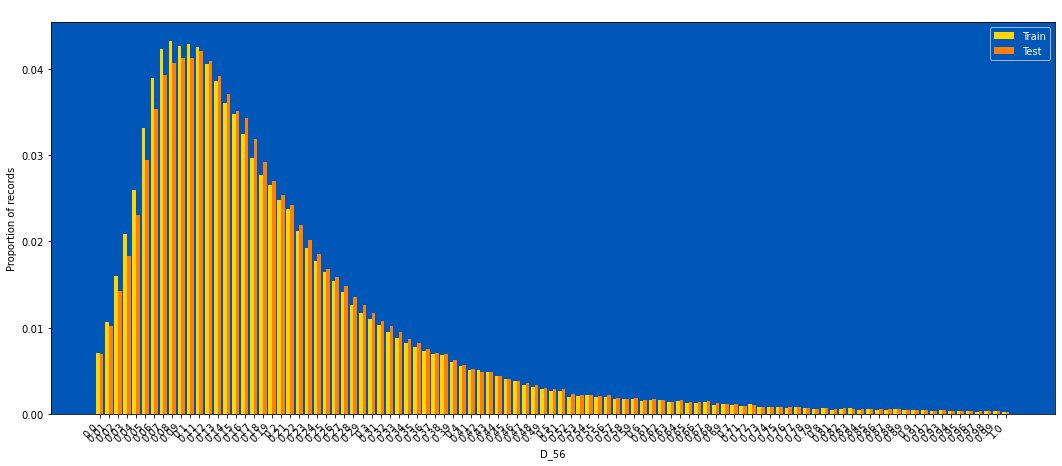

In [78]:
plot_train_test_distribution(train, test, "D_56", nunique_thr=1000)

### D_58

0 null count, 0.000 null proportion
nan of the targets have label = 1


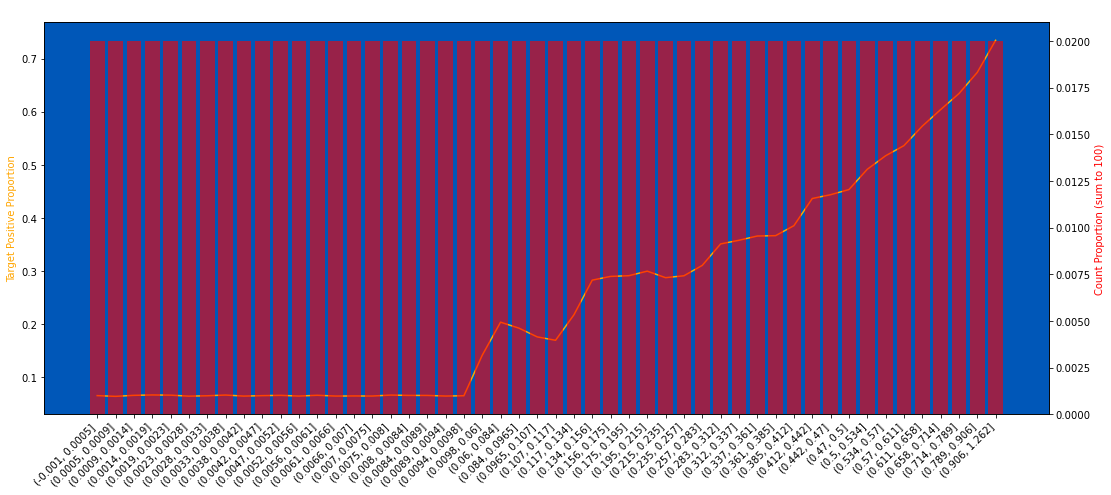

In [79]:
plot_target_check(train, "D_58", q=50, use_raw_bin=True)

In [80]:
train["D_58"] = train["D_58"].round(2)
test["D_58"] = test["D_58"].round(2)

0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


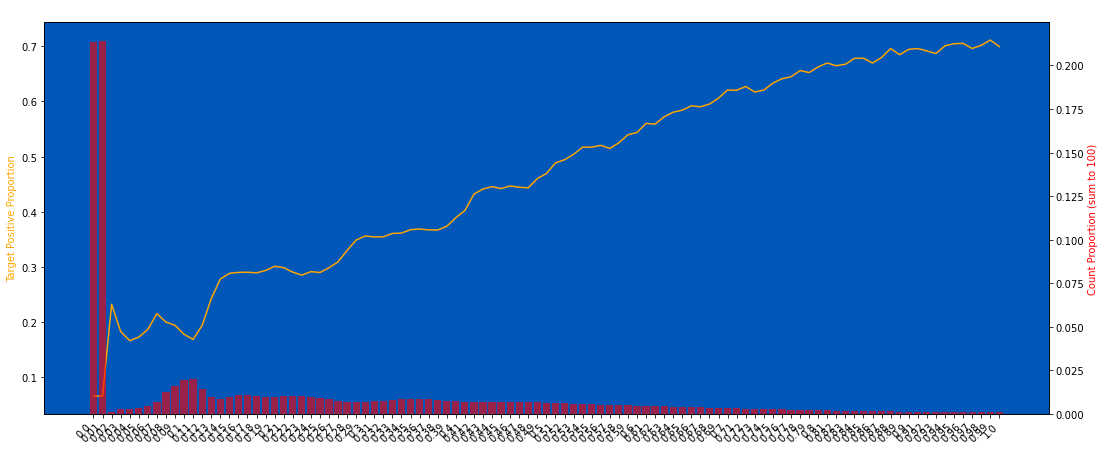

In [81]:
plot_target_check(train, "D_58", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


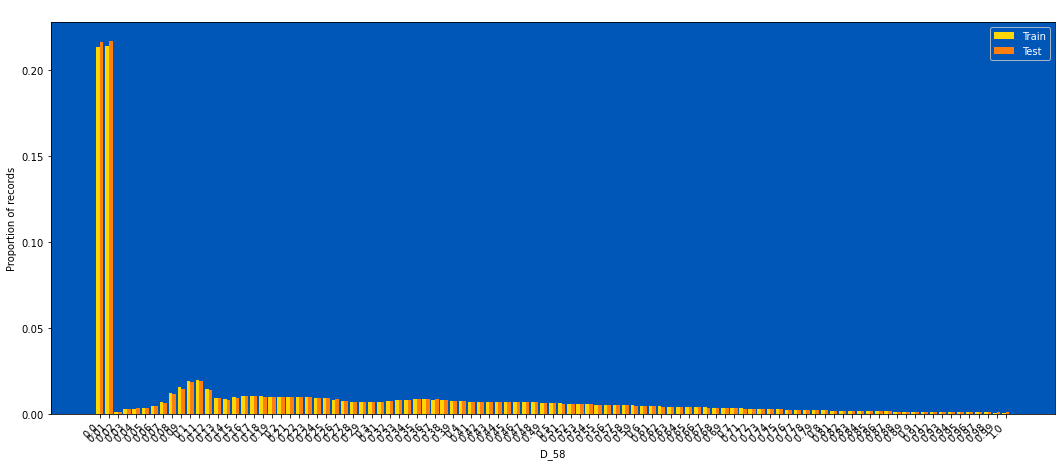

In [82]:
plot_train_test_distribution(train, test, "D_58", nunique_thr=1000)

### D_59

106725 null count, 0.019 null proportion
0.4218 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


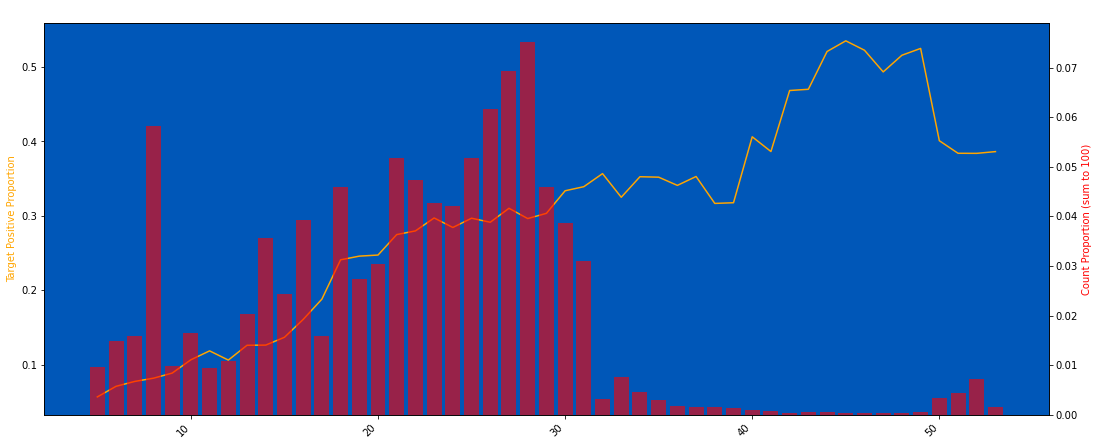

In [83]:
plot_target_check(train, "D_59", q=50, use_raw_bin=True, nunique_thr=1000)

Bottom 1% and Top 1% are dropped from this chart


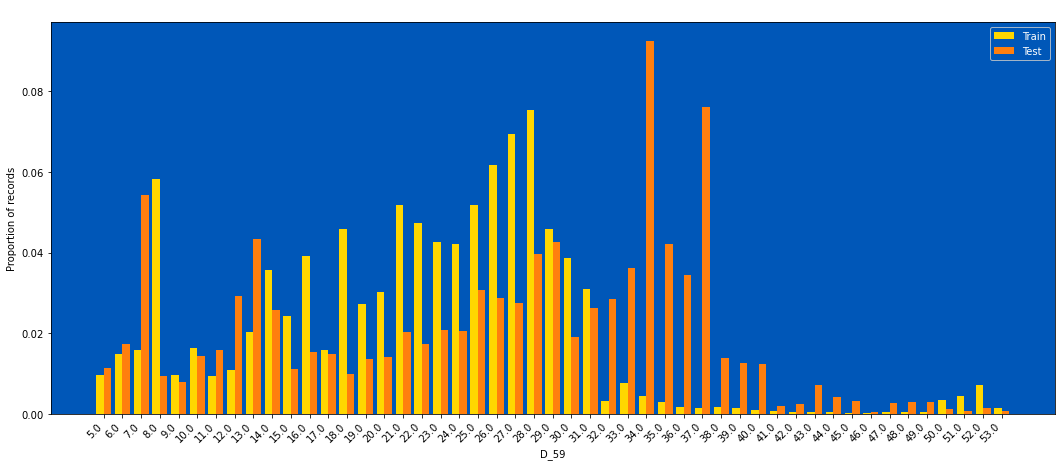

In [84]:
plot_train_test_distribution(train, test, "D_59", nunique_thr=1000)

### D_60

0 null count, 0.000 null proportion
nan of the targets have label = 1


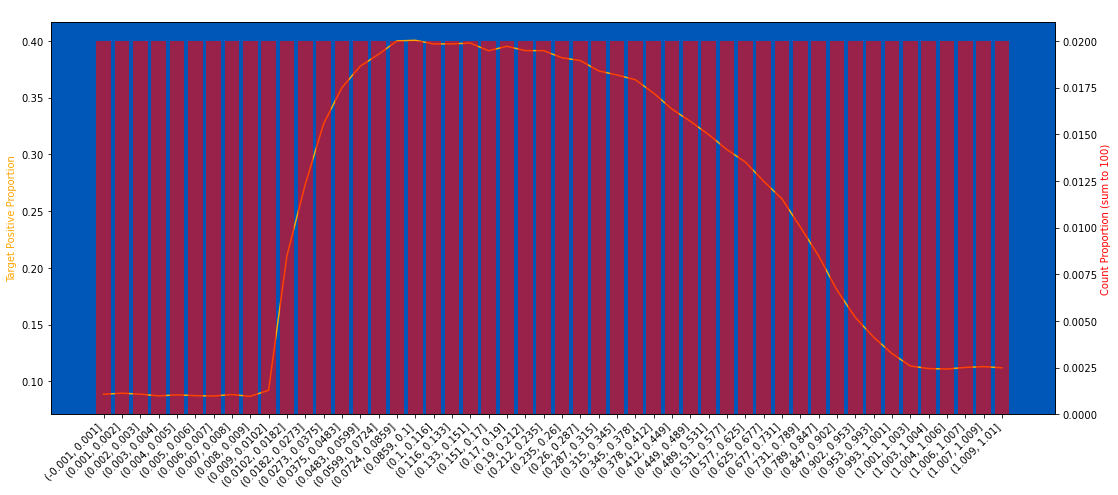

In [85]:
plot_target_check(train, "D_60", q=50, use_raw_bin=True)

In [86]:
train["D_60"] = train["D_60"].round(2)
test["D_60"] = test["D_60"].round(2)

In [87]:
train.loc[train["D_60"].between(-0.01, 0.01), "D_60"] = 0
test.loc[test["D_60"].between(-0.01, 0.01), "D_60"] = 0

In [88]:
train.loc[train["D_60"].between(1, 1.01), "D_60"] = 1
test.loc[test["D_60"].between(1, 1.01), "D_60"] = 1

0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


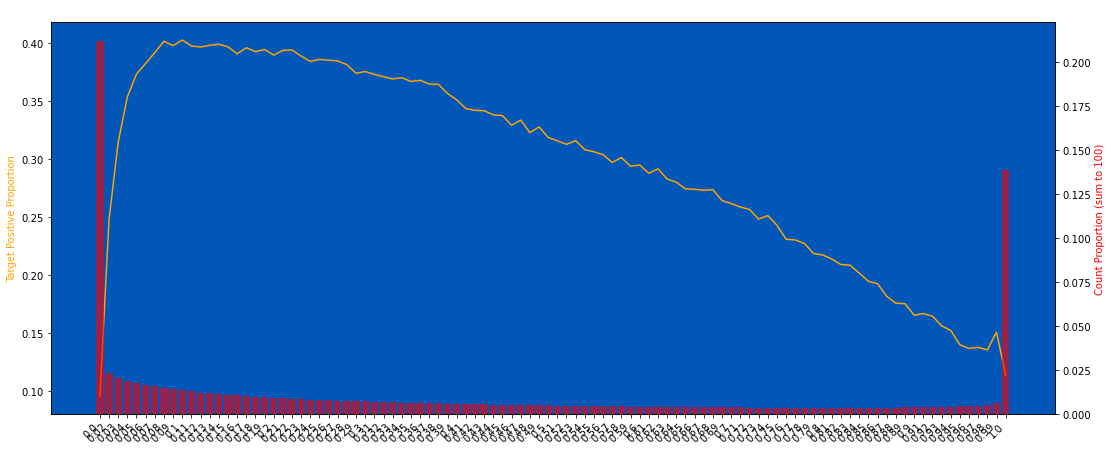

In [89]:
plot_target_check(train, "D_60", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


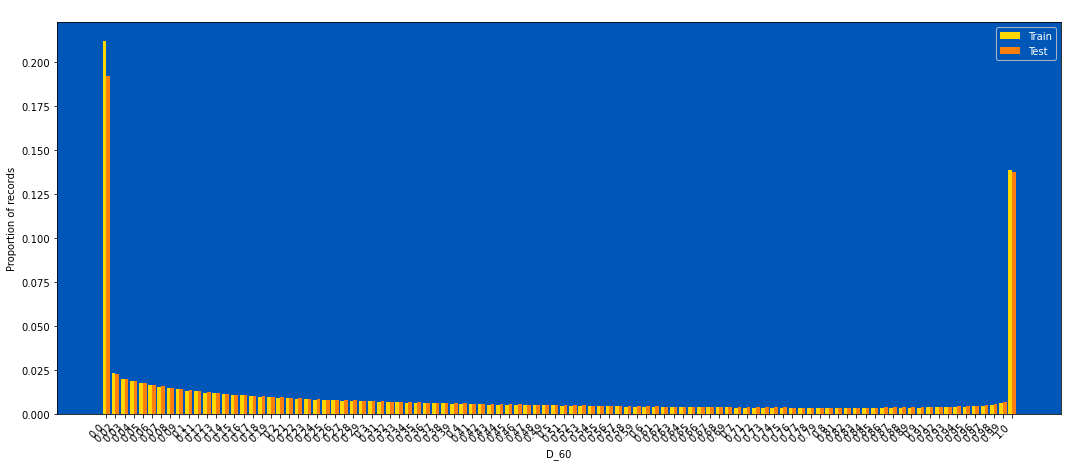

In [90]:
plot_train_test_distribution(train, test, "D_60", nunique_thr=1000)

### D_61

598052 null count, 0.108 null proportion
0.0849 of the targets have label = 1


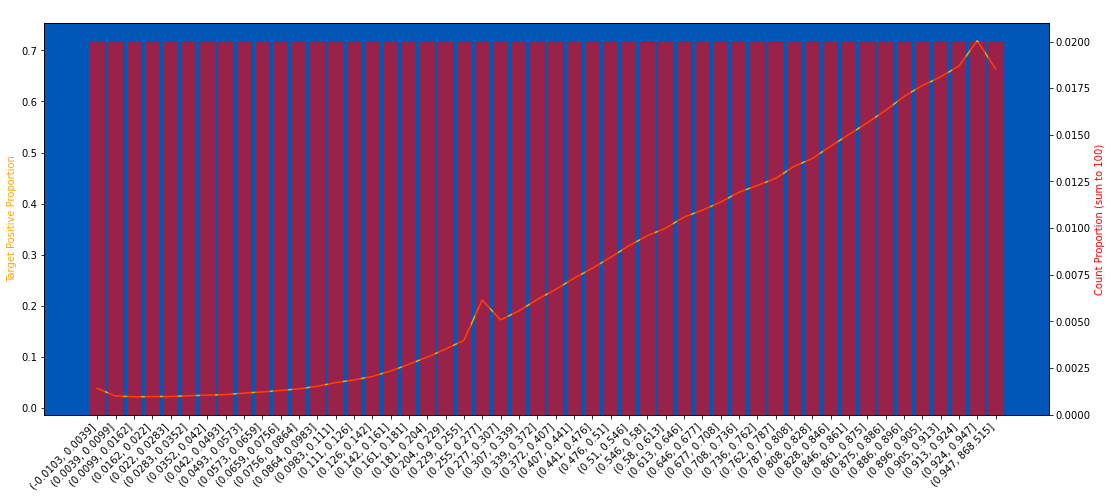

In [91]:
plot_target_check(train, "D_61", q=50, use_raw_bin=True)

In [92]:
train["D_61"] = train["D_61"].round(2)
test["D_61"] = test["D_61"].round(2)

598052 null count, 0.108 null proportion
0.0849 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


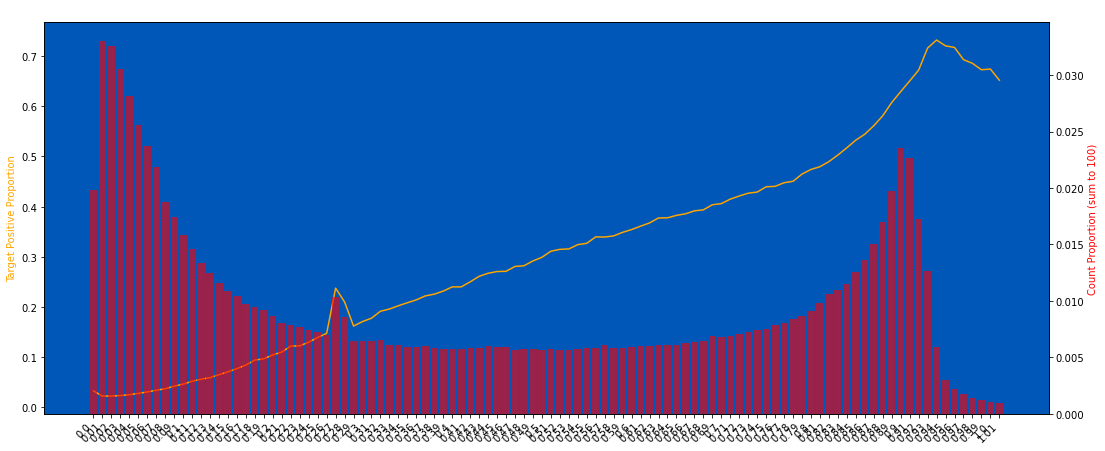

In [93]:
plot_target_check(train, "D_61", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


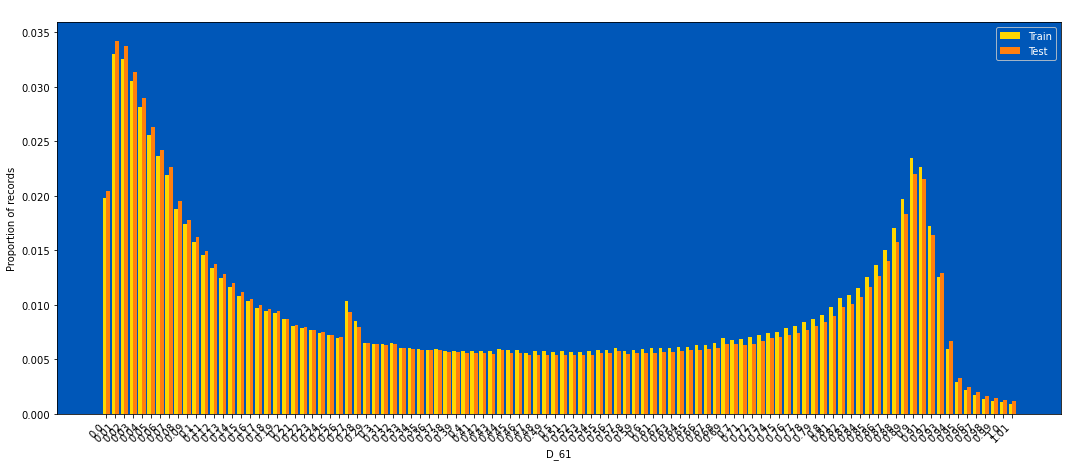

In [94]:
plot_train_test_distribution(train, test, "D_61", nunique_thr=1000)

### D_62

758161 null count, 0.137 null proportion
0.1127 of the targets have label = 1


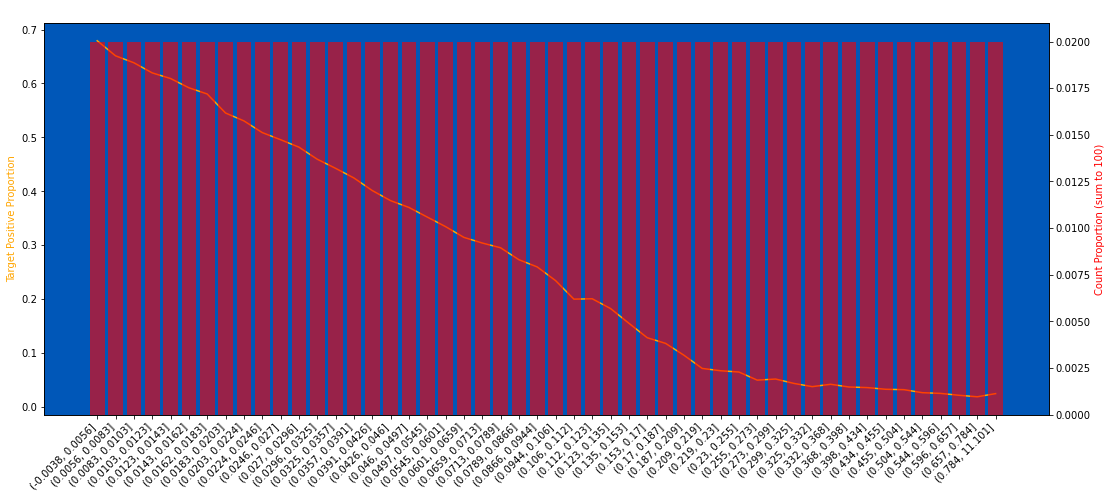

In [95]:
plot_target_check(train, "D_62", q=50, use_raw_bin=True)

In [96]:
train["D_62"] = train["D_62"].round(2)
test["D_62"] = test["D_62"].round(2)

758161 null count, 0.137 null proportion
0.1127 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


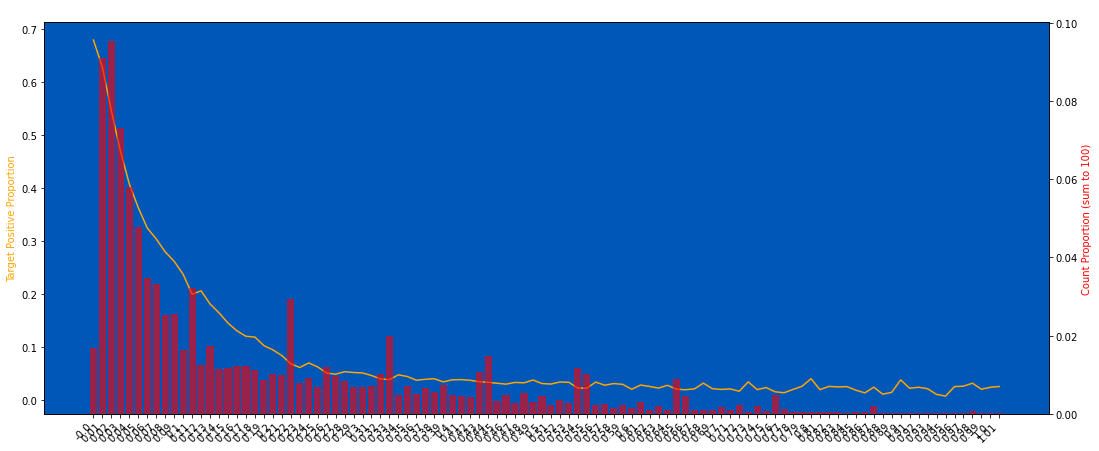

In [97]:
plot_target_check(train, "D_62", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


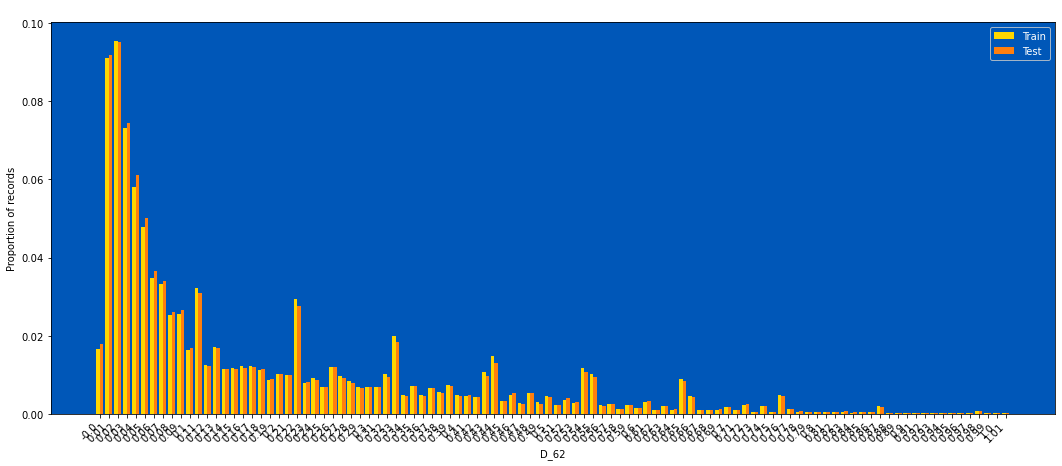

In [98]:
plot_train_test_distribution(train, test, "D_62", nunique_thr=1000)

### D_63

0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


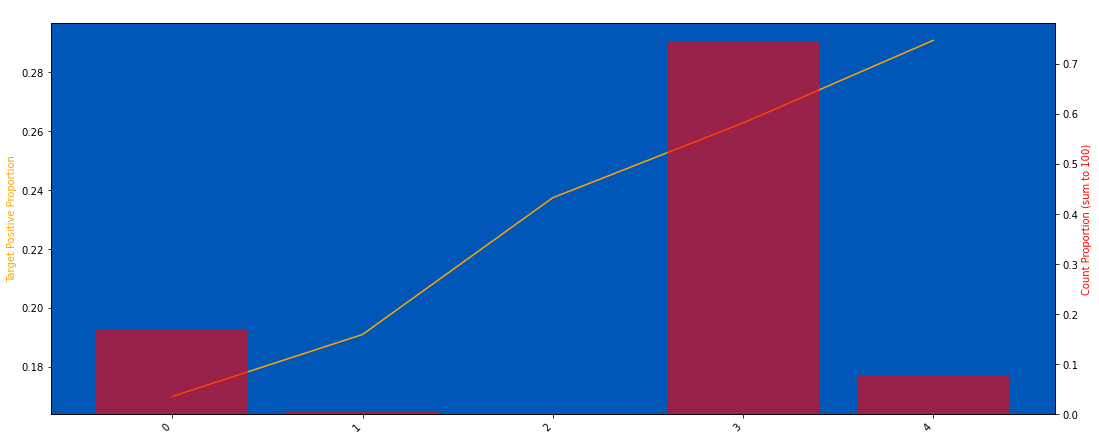

In [99]:
plot_target_check(train, "D_63", q=50, use_raw_bin=True)

Bottom 1% and Top 1% are dropped from this chart


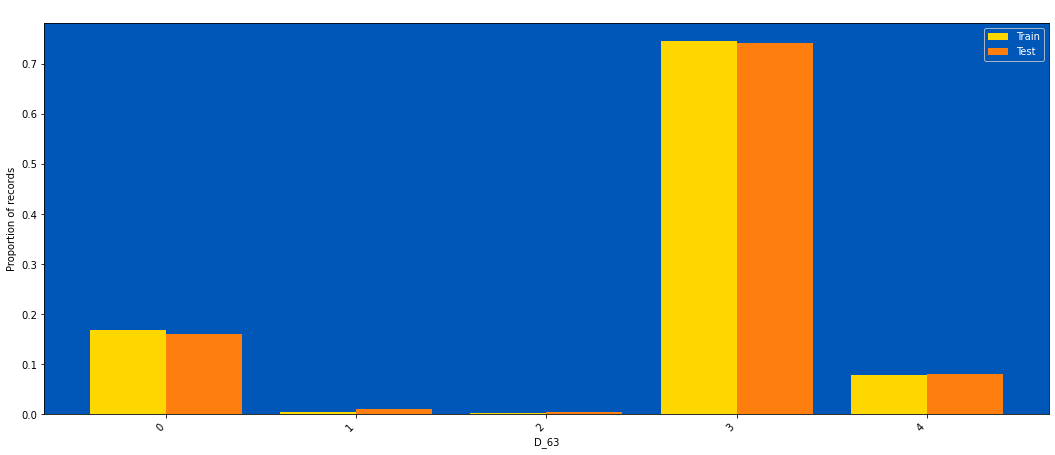

In [100]:
plot_train_test_distribution(train, test, "D_63", nunique_thr=1000)

### D_64

217442 null count, 0.039 null proportion
0.4086 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


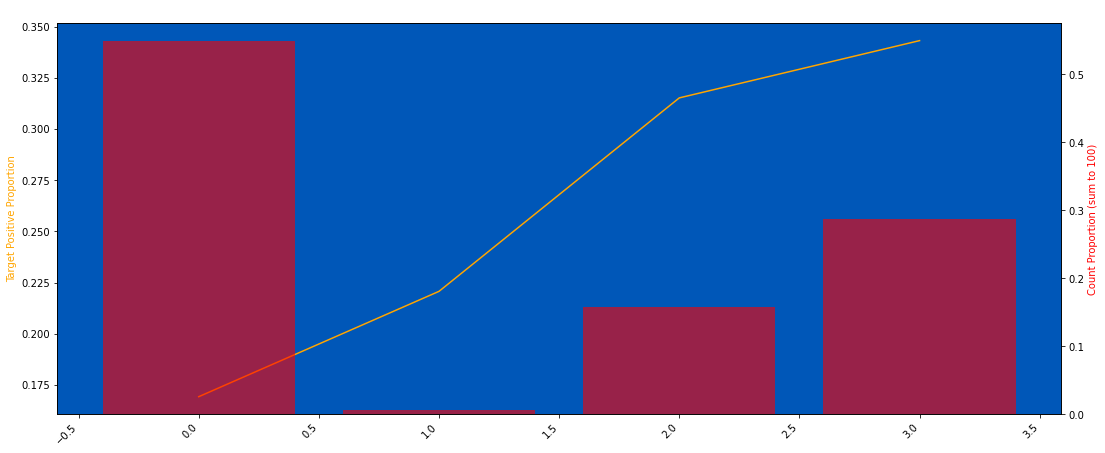

In [101]:
plot_target_check(train, "D_64", q=50, use_raw_bin=True)

Bottom 1% and Top 1% are dropped from this chart


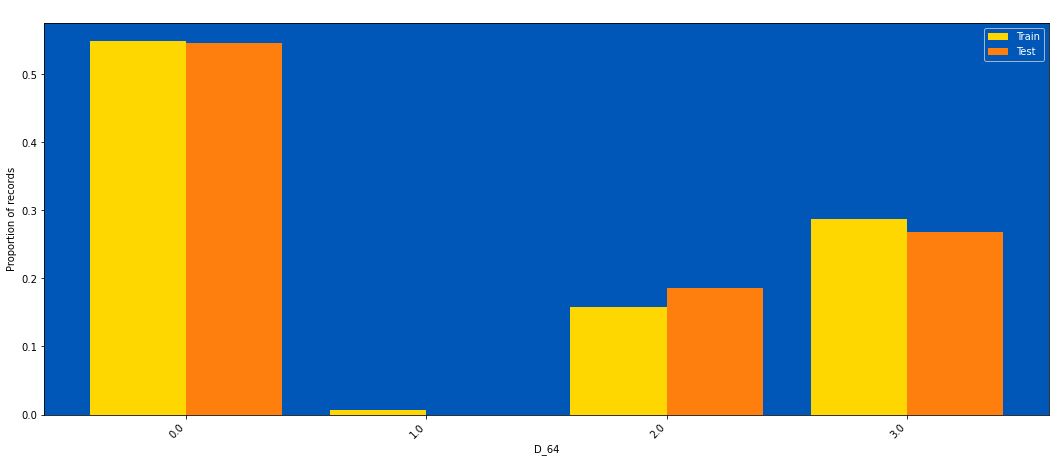

In [102]:
plot_train_test_distribution(train, test, "D_64", nunique_thr=1000)

### D_65

0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


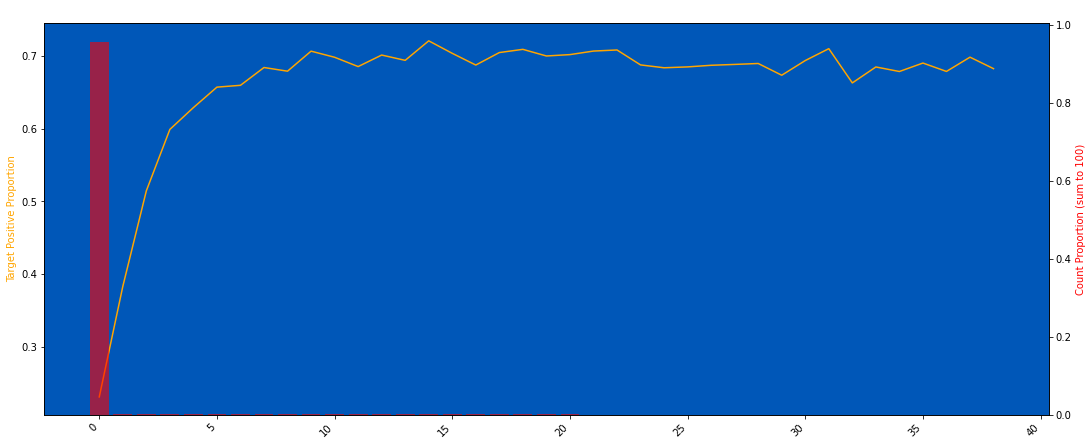

In [103]:
plot_target_check(train, "D_65", q=200, use_raw_bin=True, nunique_thr=1000)

Bottom 1% and Top 1% are dropped from this chart


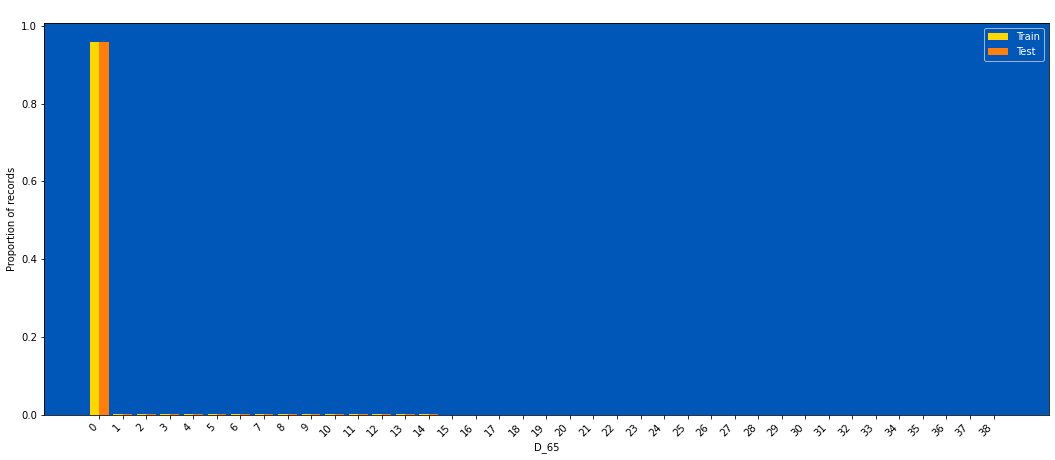

In [104]:
plot_train_test_distribution(train, test, "D_65", nunique_thr=1000)

### D_66

4908097 null count, 0.887 null proportion
0.2572 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


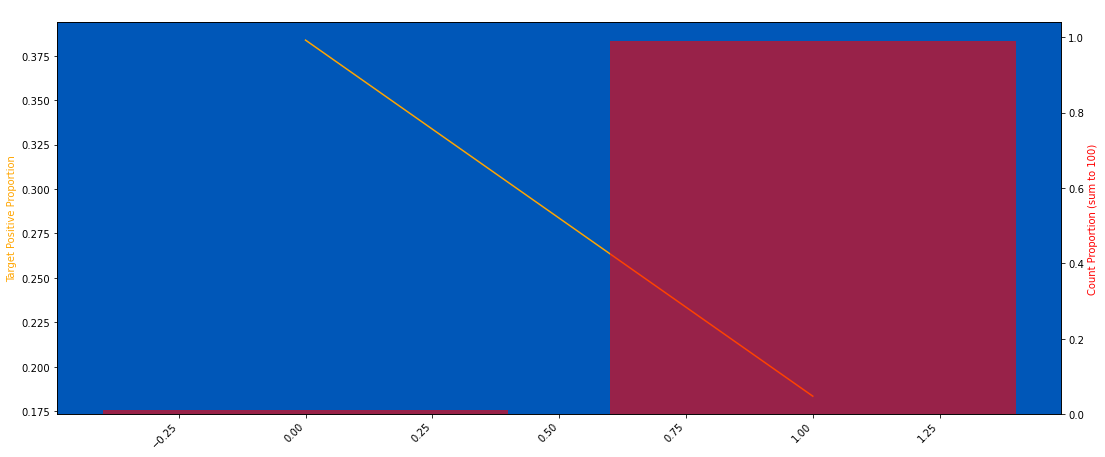

In [105]:
plot_target_check(train, "D_66", q=50, use_raw_bin=True)

Bottom 1% and Top 1% are dropped from this chart


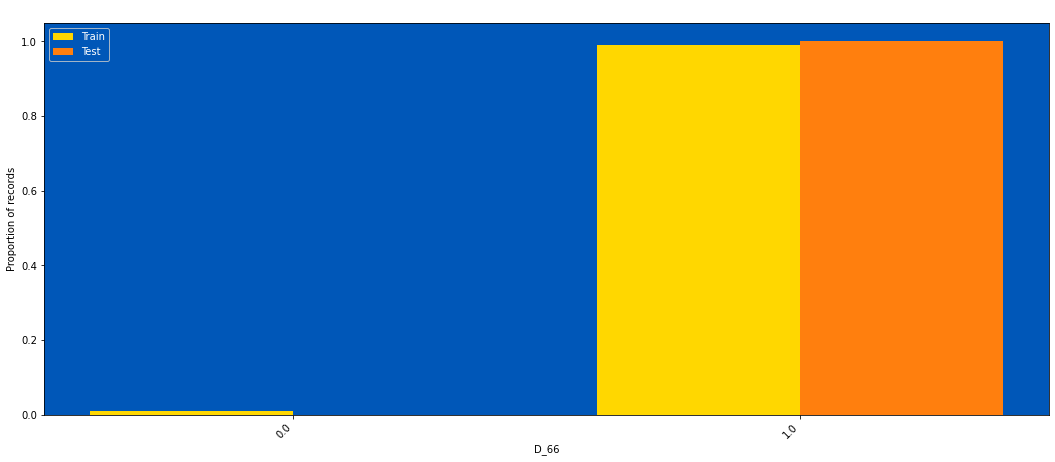

In [106]:
plot_train_test_distribution(train, test, "D_66", nunique_thr=1000)

### D_68

216503 null count, 0.039 null proportion
0.4145 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


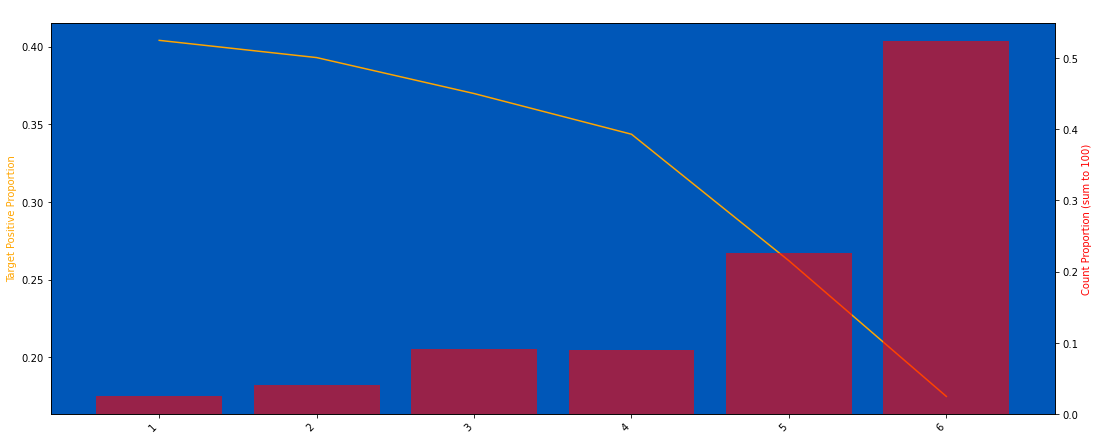

In [107]:
plot_target_check(train, "D_68", q=50, use_raw_bin=True)

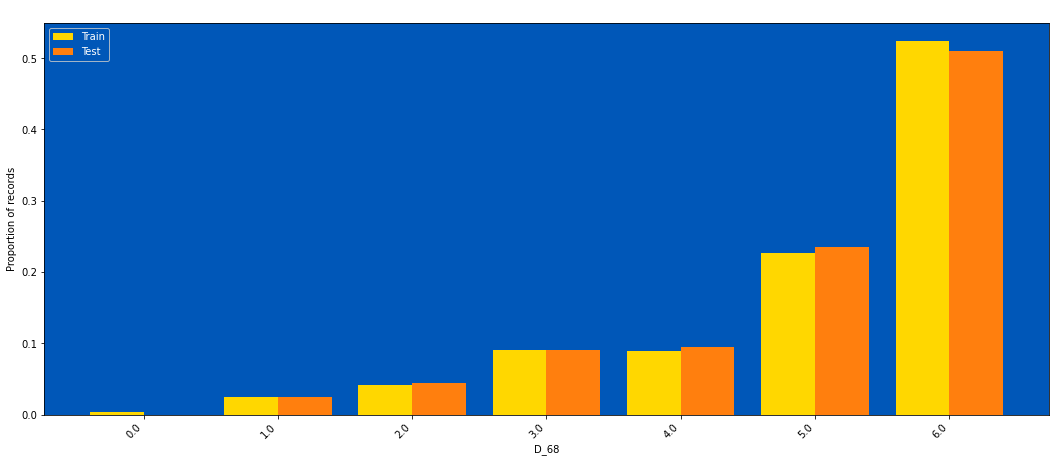

In [108]:
plot_train_test_distribution(train, test, "D_68", nunique_thr=10)

### D_69

194473 null count, 0.035 null proportion
0.4308 of the targets have label = 1


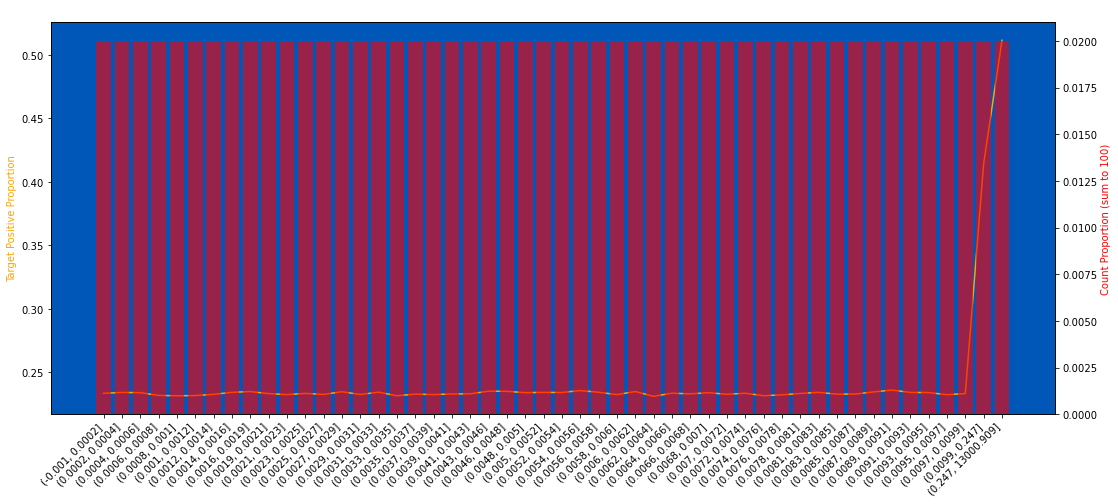

In [109]:
plot_target_check(train, "D_69", q=50, use_raw_bin=True)

In [110]:
train["D_69"] = train["D_69"].round(2)
test["D_69"] = test["D_69"].round(2)

194473 null count, 0.035 null proportion
0.4308 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


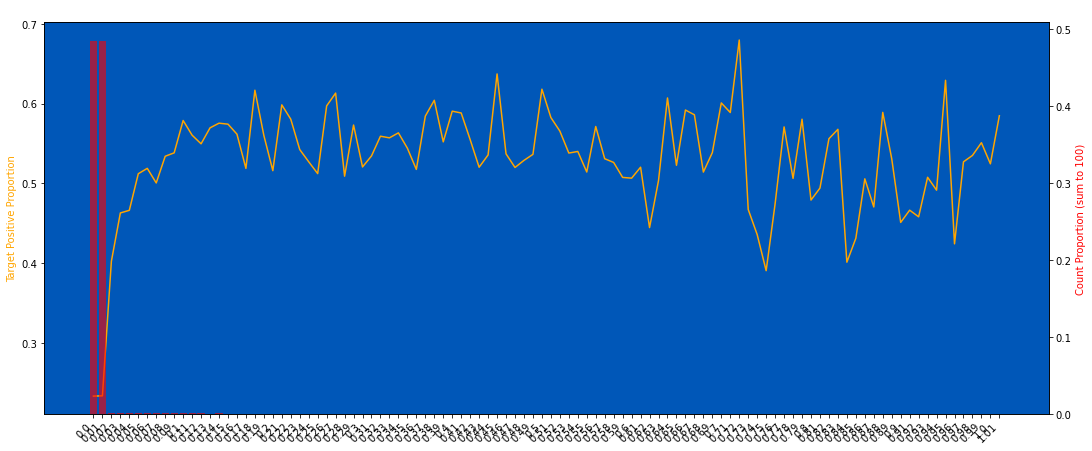

In [111]:
plot_target_check(train, "D_69", q=100, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


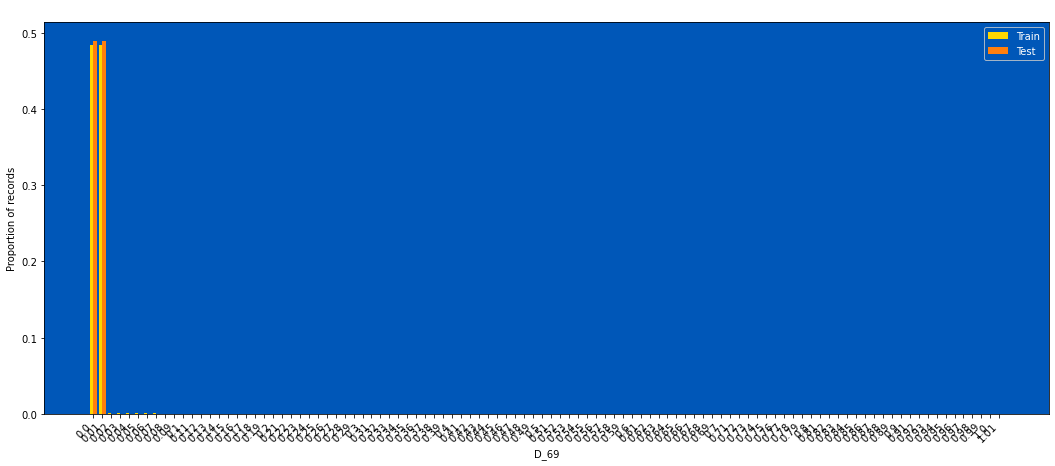

In [112]:
plot_train_test_distribution(train, test, "D_69", nunique_thr=5000)

### D_70

94917 null count, 0.017 null proportion
0.4203 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


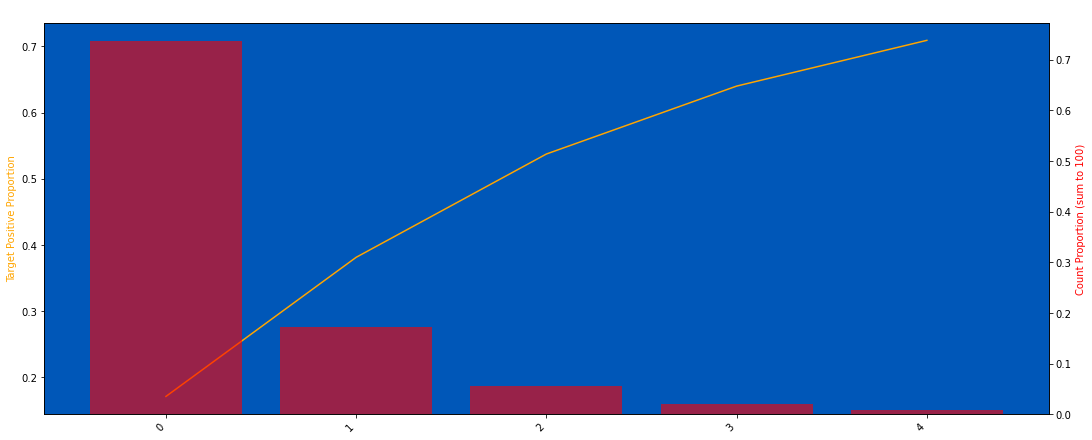

In [113]:
plot_target_check(train, "D_70", q=50, use_raw_bin=True)

Bottom 1% and Top 1% are dropped from this chart


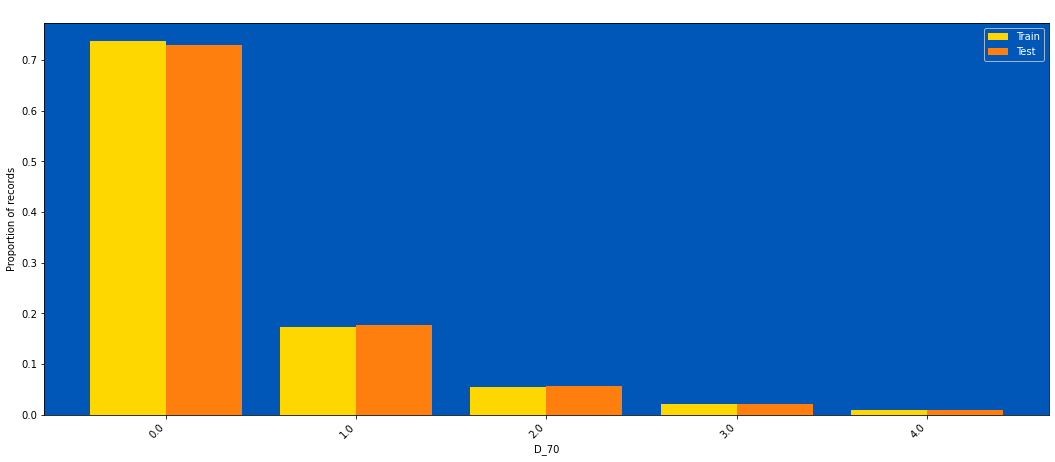

In [114]:
plot_train_test_distribution(train, test, "D_70", nunique_thr=5000)

### D_71

0 null count, 0.000 null proportion
nan of the targets have label = 1


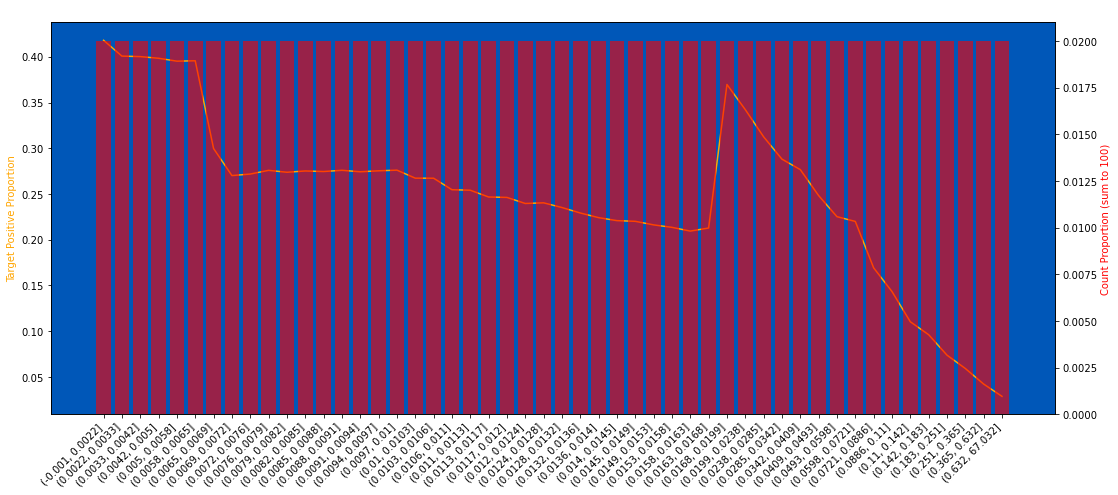

In [115]:
plot_target_check(train, "D_71", q=50, use_raw_bin=True)

In [116]:
train["D_71"] = train["D_71"].round(2)
test["D_71"] = test["D_71"].round(2)

0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


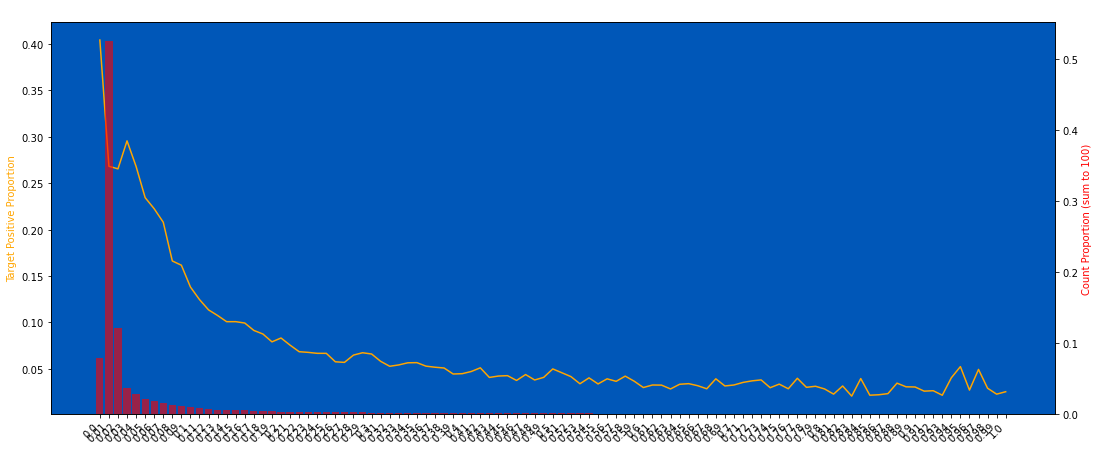

In [117]:
plot_target_check(train, "D_71", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


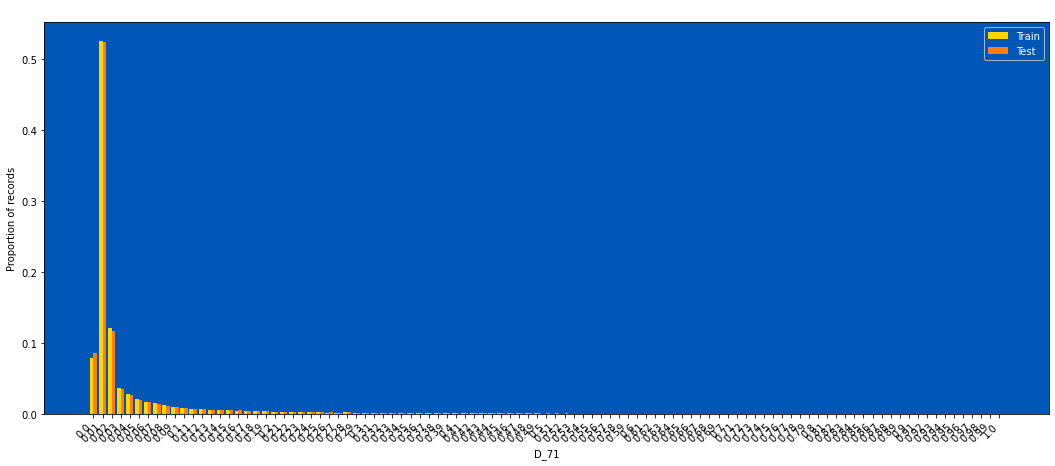

In [118]:
plot_train_test_distribution(train, test, "D_71", nunique_thr=5000)

### D_72

23708 null count, 0.004 null proportion
0.3495 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


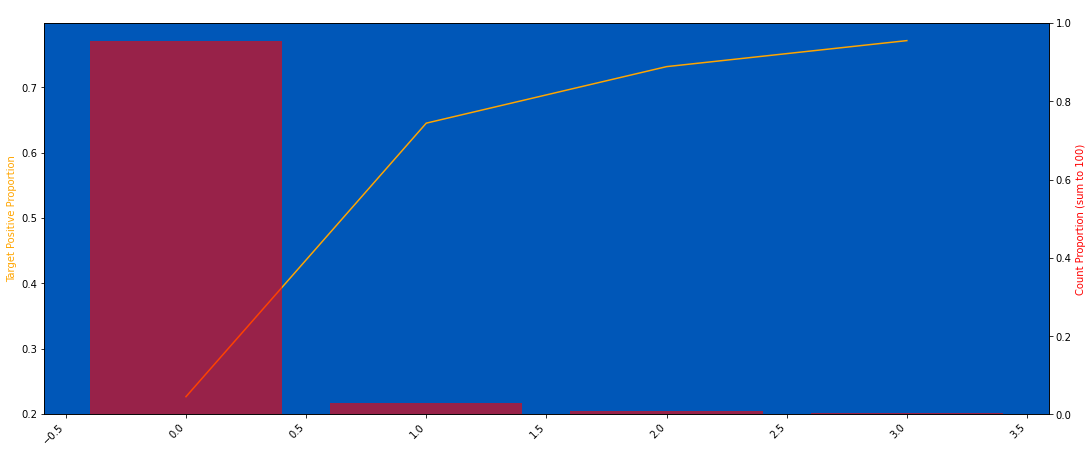

In [119]:
plot_target_check(train, "D_72", q=50, use_raw_bin=True)

Bottom 1% and Top 1% are dropped from this chart


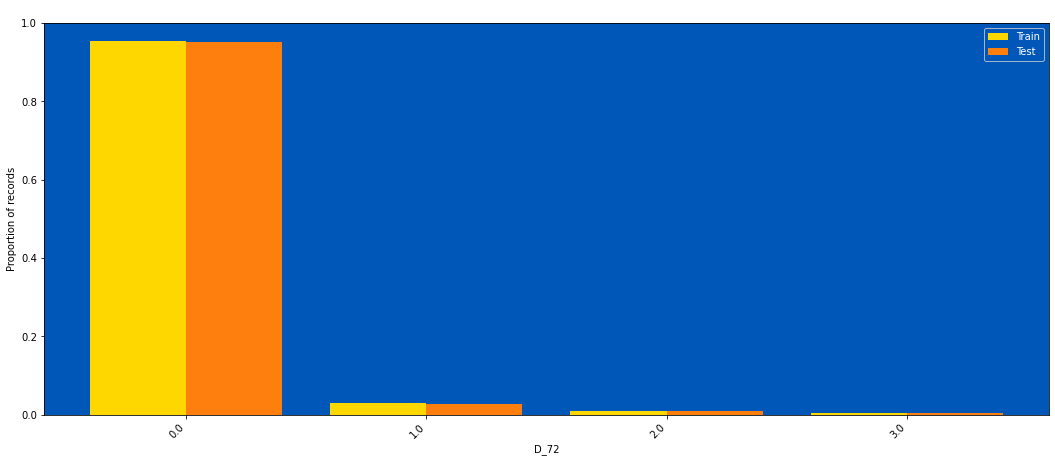

In [120]:
plot_train_test_distribution(train, test, "D_72", nunique_thr=5000)

### D_73

5475595 null count, 0.990 null proportion
0.2478 of the targets have label = 1


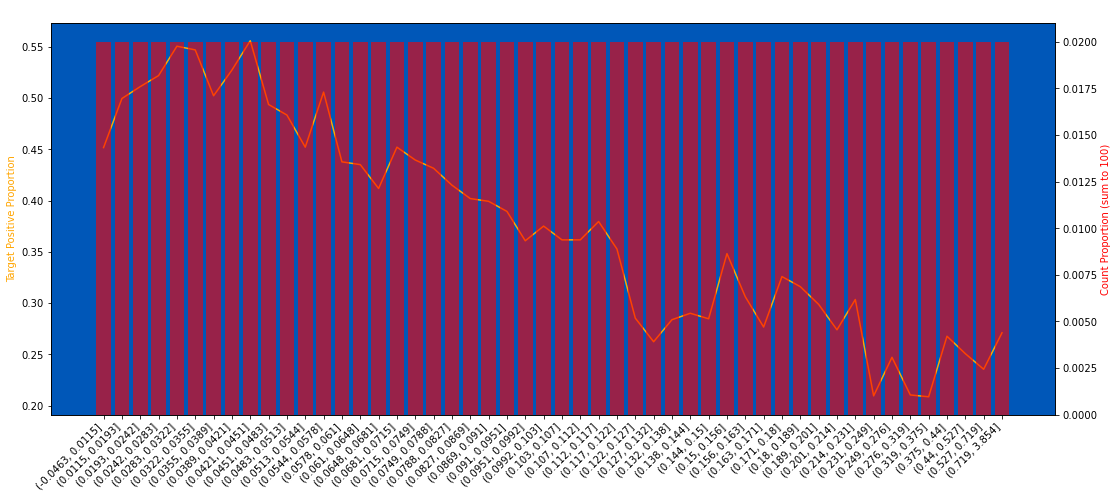

In [121]:
plot_target_check(train, "D_73", q=50, use_raw_bin=True)

In [122]:
train["D_73"] = train["D_73"].round(2)
test["D_73"] = test["D_73"].round(2)

5475595 null count, 0.990 null proportion
0.2478 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


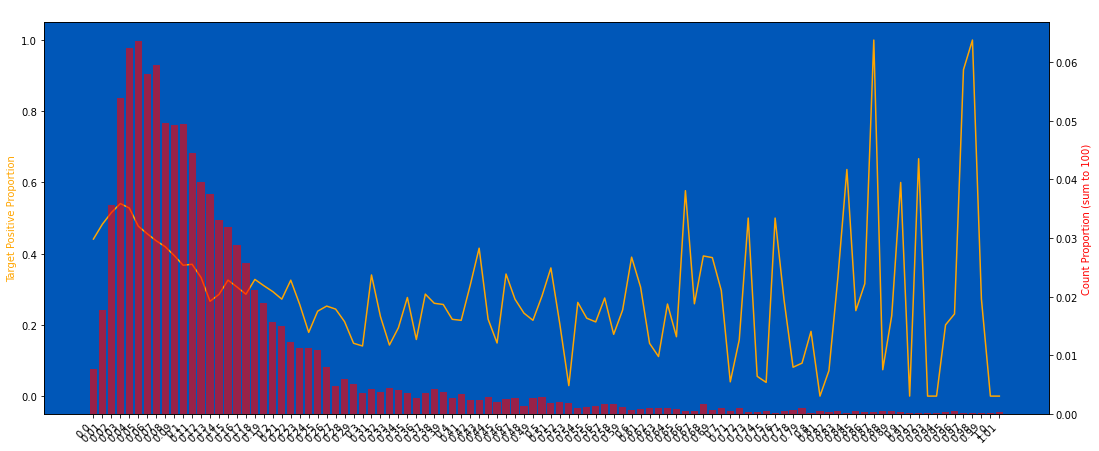

In [123]:
plot_target_check(train, "D_73", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


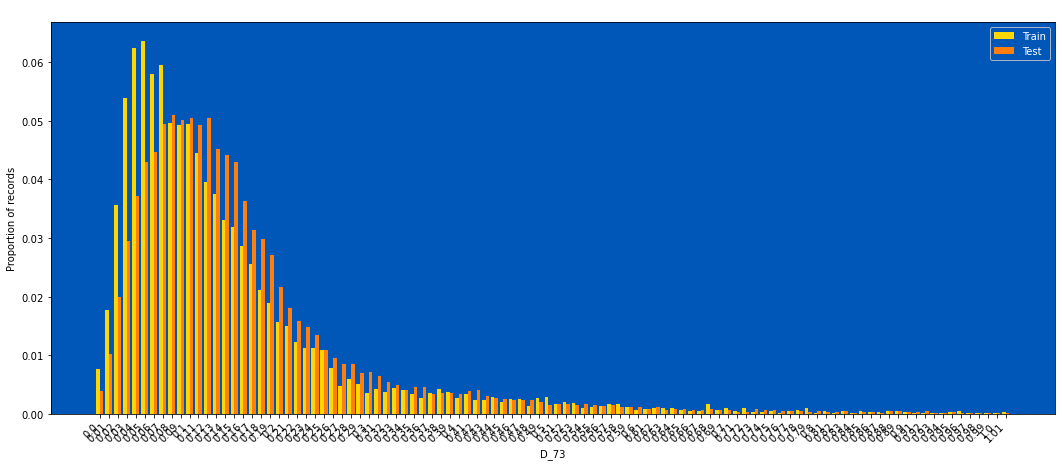

In [124]:
plot_train_test_distribution(train, test, "D_73", nunique_thr=5000)

### D_74

21773 null count, 0.004 null proportion
0.1709 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


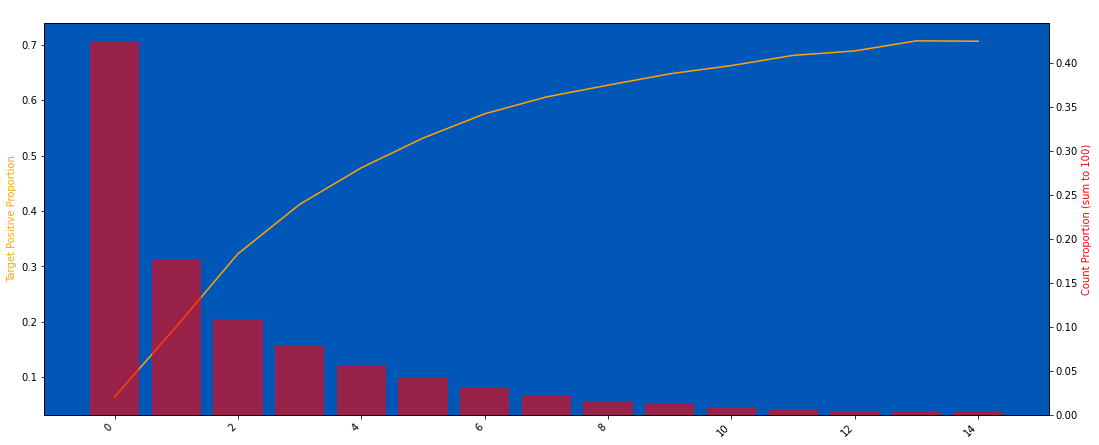

In [125]:
plot_target_check(train, "D_74", q=50, use_raw_bin=True)

Bottom 1% and Top 1% are dropped from this chart


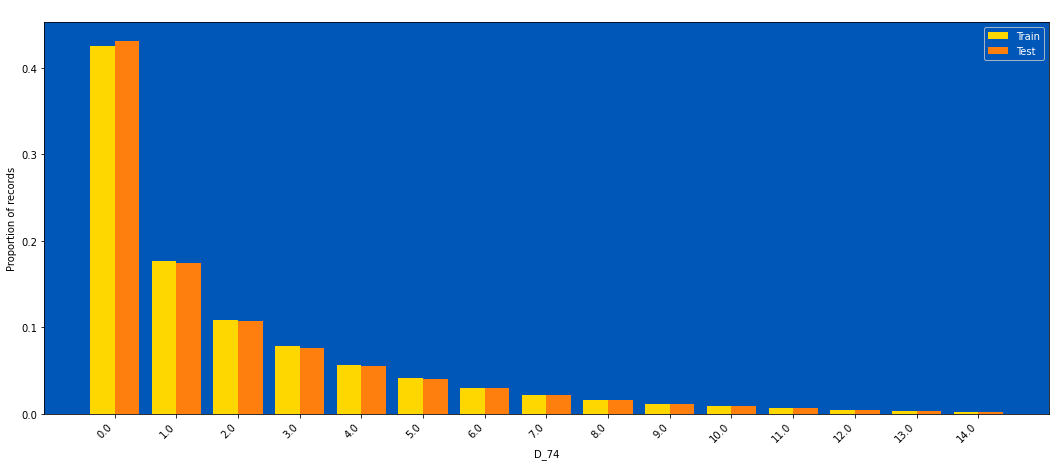

In [126]:
plot_train_test_distribution(train, test, "D_74", nunique_thr=5000)

### D_75

0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


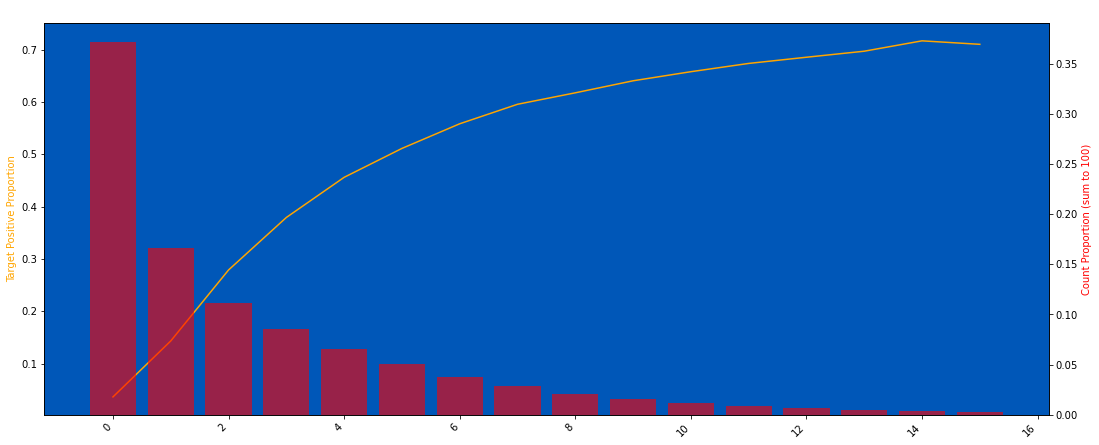

In [127]:
plot_target_check(train, "D_75", q=50, use_raw_bin=True)

Bottom 1% and Top 1% are dropped from this chart


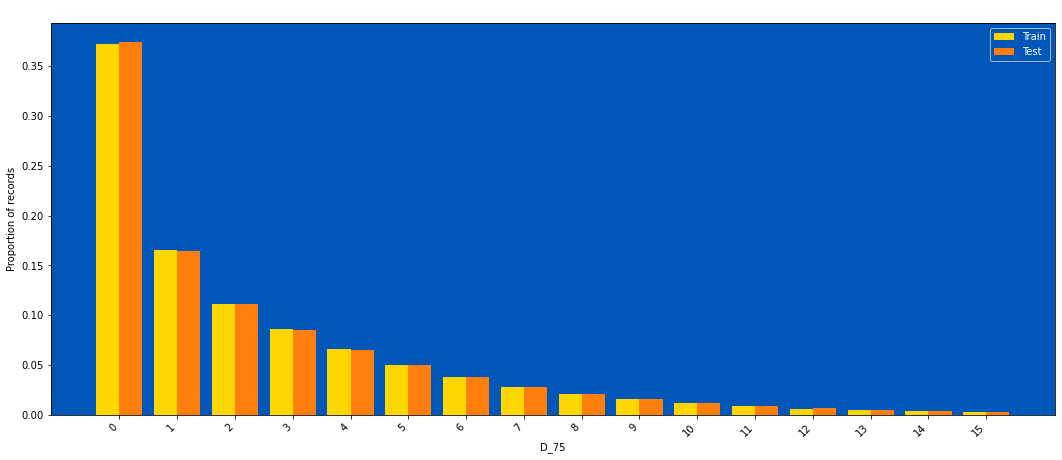

In [128]:
plot_train_test_distribution(train, test, "D_75", nunique_thr=5000)

### D_76

4908954 null count, 0.887 null proportion
0.2677 of the targets have label = 1


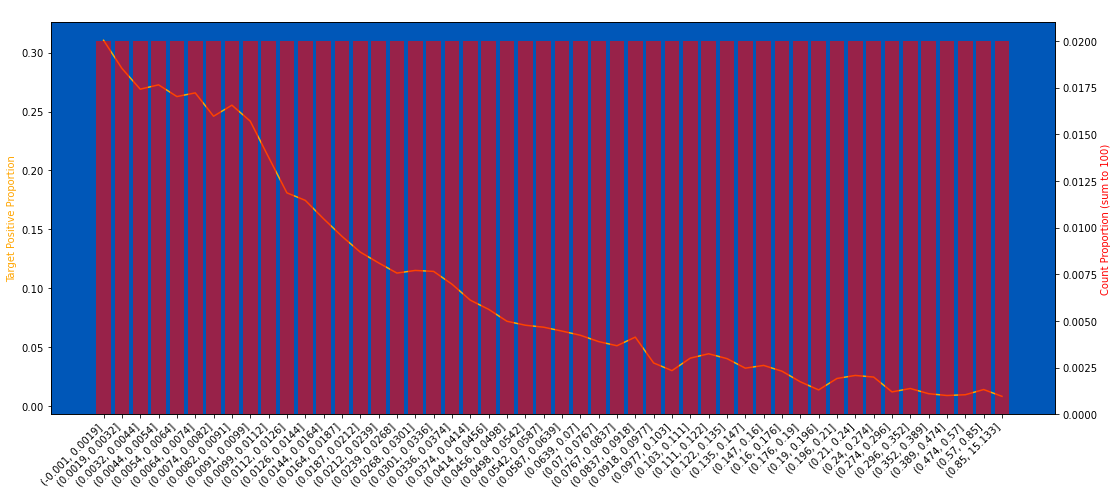

In [129]:
plot_target_check(train, "D_76", q=50, use_raw_bin=True)

In [130]:
train["D_76"] = train["D_76"].round(2)
test["D_76"] = test["D_76"].round(2)

4908954 null count, 0.887 null proportion
0.2677 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


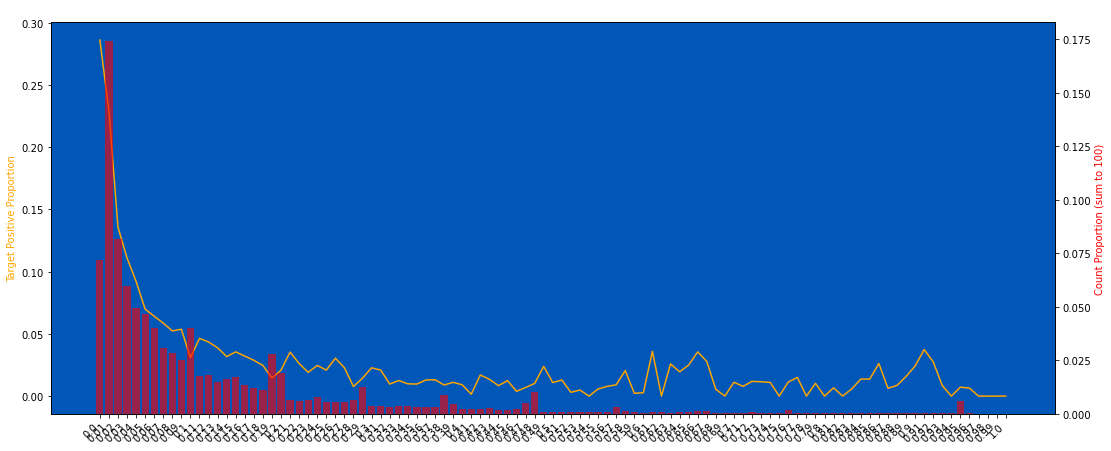

In [131]:
plot_target_check(train, "D_76", q=50, use_raw_bin=True, nunique_thr=2000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


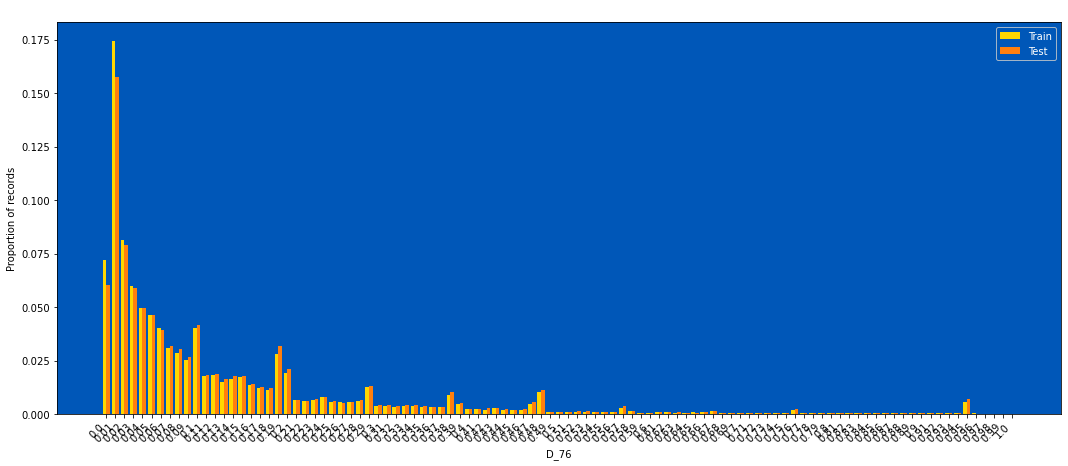

In [132]:
plot_train_test_distribution(train, test, "D_76", nunique_thr=5000)

### D_77

2513912 null count, 0.454 null proportion
0.3395 of the targets have label = 1


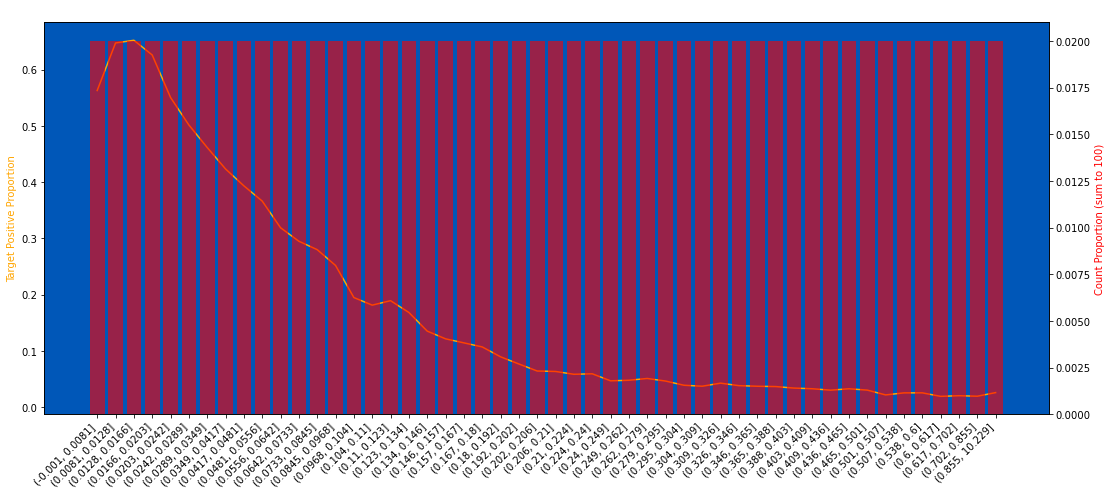

In [133]:
plot_target_check(train, "D_77", q=50, use_raw_bin=True)

In [134]:
train["D_77"] = train["D_77"].round(2)
test["D_77"] = test["D_77"].round(2)

2513912 null count, 0.454 null proportion
0.3395 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


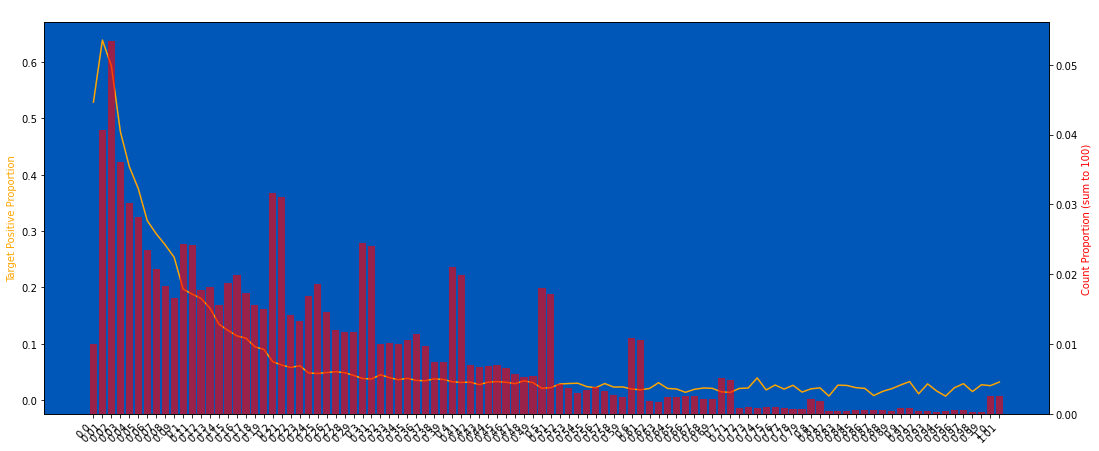

In [135]:
plot_target_check(train, "D_77", q=50, use_raw_bin=True, nunique_thr=2000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


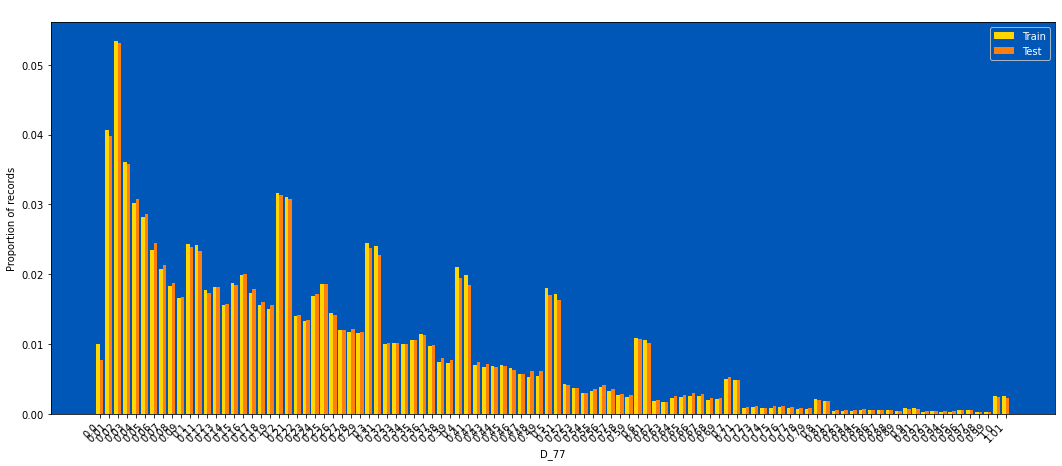

In [136]:
plot_train_test_distribution(train, test, "D_77", nunique_thr=5000)

### D_78

274319 null count, 0.050 null proportion
0.2406 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


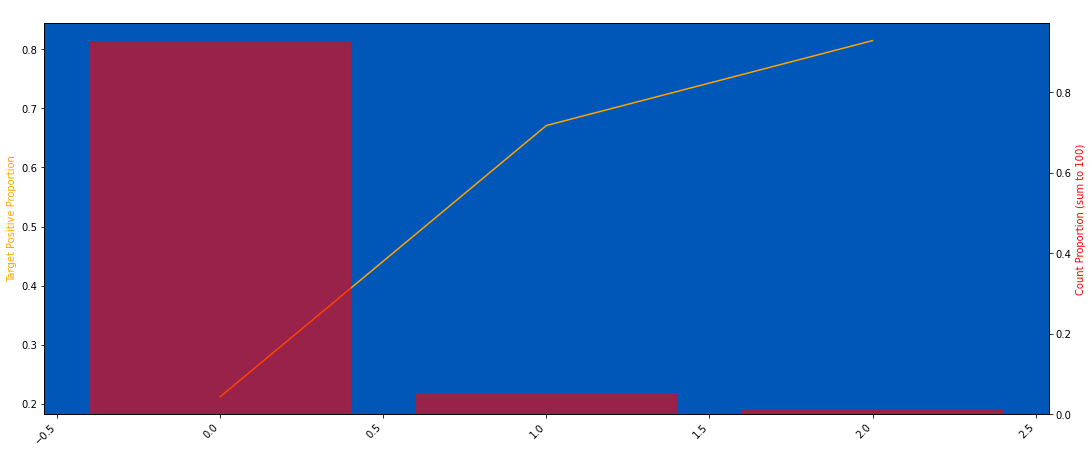

In [137]:
plot_target_check(train, "D_78", q=50, use_raw_bin=True)

Bottom 1% and Top 1% are dropped from this chart


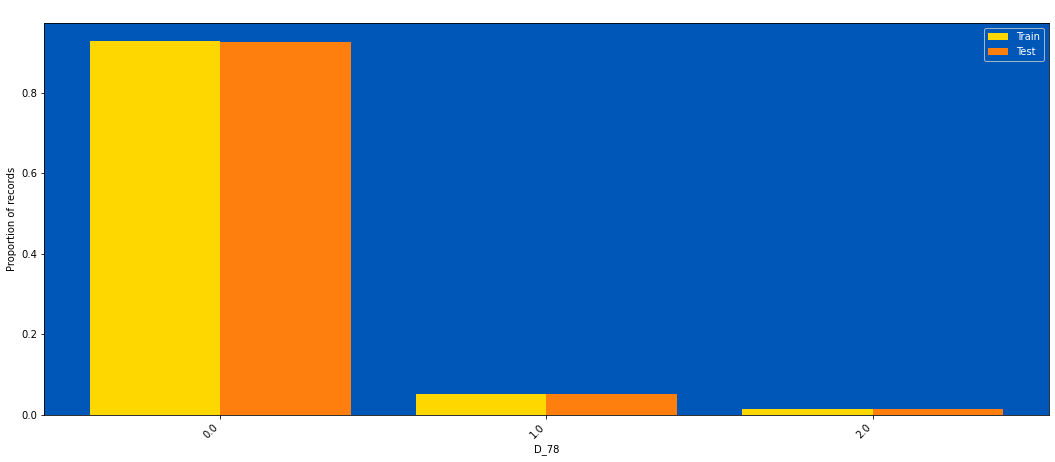

In [138]:
plot_train_test_distribution(train, test, "D_78", nunique_thr=500)

### D_79

75939 null count, 0.014 null proportion
0.3761 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


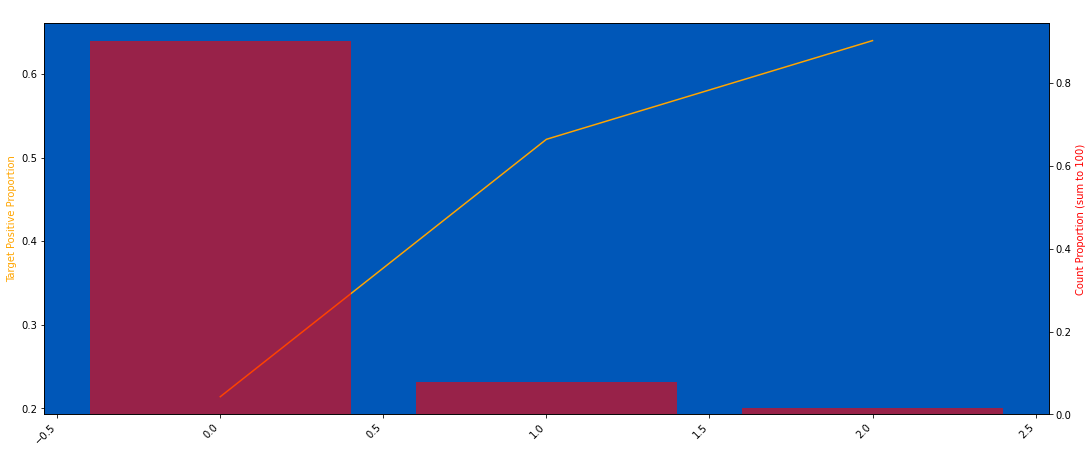

In [139]:
plot_target_check(train, "D_79", q=50, use_raw_bin=True)

Bottom 1% and Top 1% are dropped from this chart


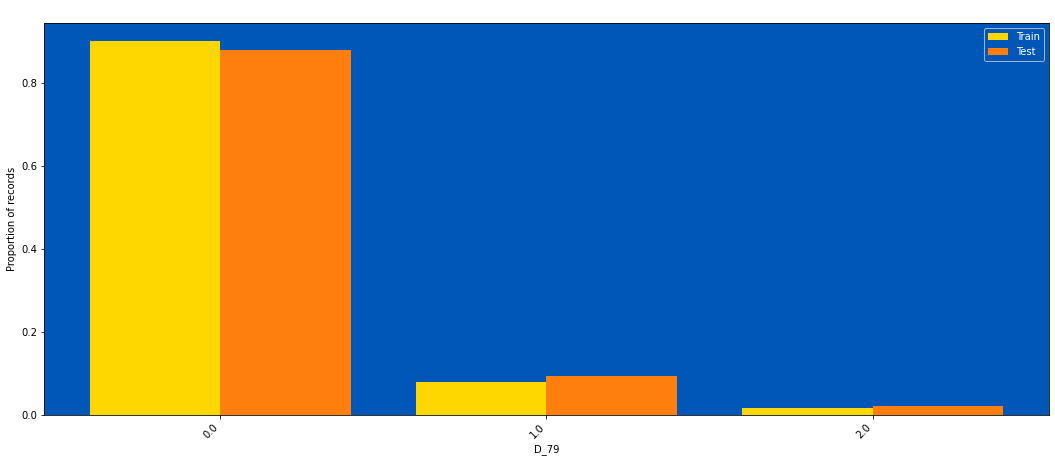

In [140]:
plot_train_test_distribution(train, test, "D_79", nunique_thr=500)

### D_80

21773 null count, 0.004 null proportion
0.1709 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


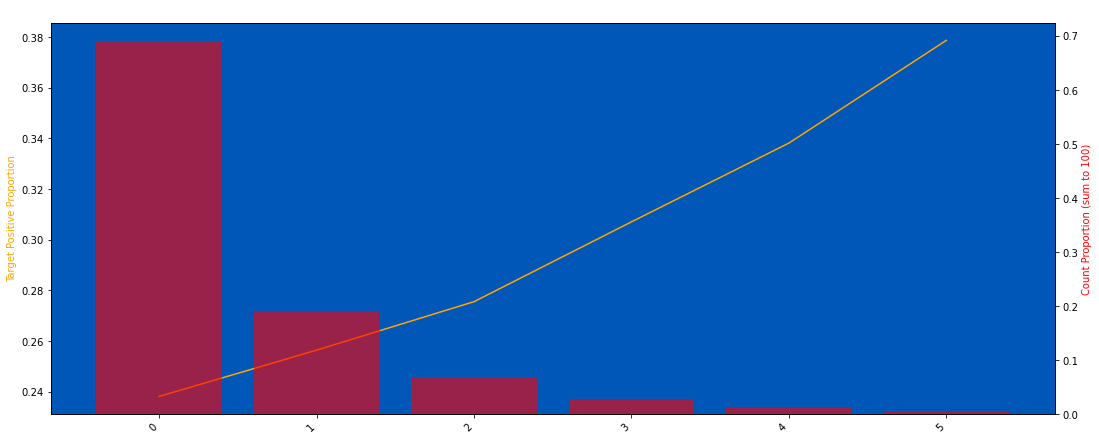

In [141]:
plot_target_check(train, "D_80", q=50, use_raw_bin=True)

Bottom 1% and Top 1% are dropped from this chart


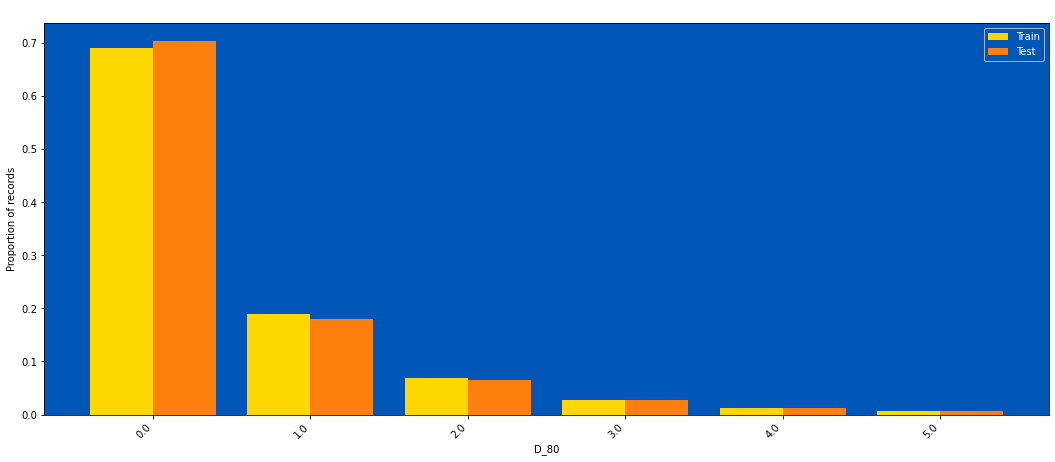

In [142]:
plot_train_test_distribution(train, test, "D_80", nunique_thr=500)

### D_81

25687 null count, 0.005 null proportion
0.3798 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


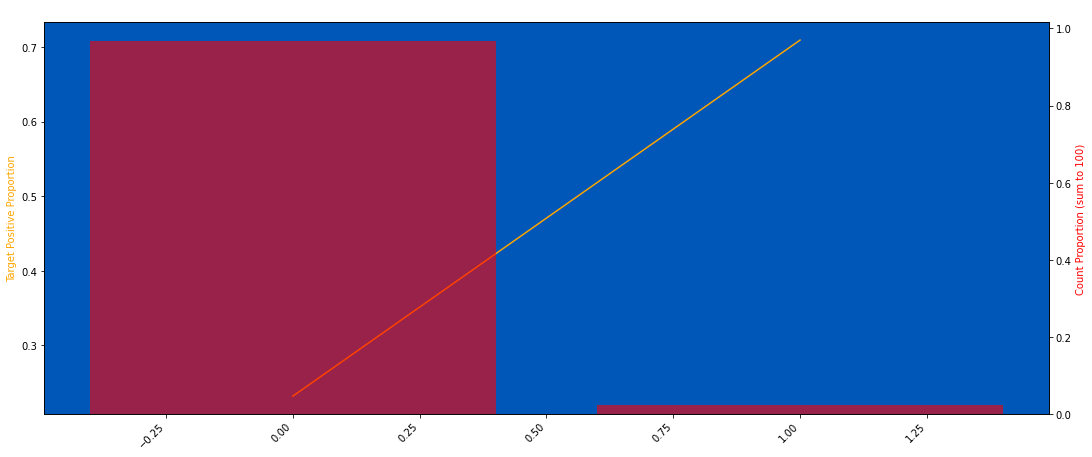

In [143]:
plot_target_check(train, "D_81", q=50, use_raw_bin=True)

Bottom 1% and Top 1% are dropped from this chart


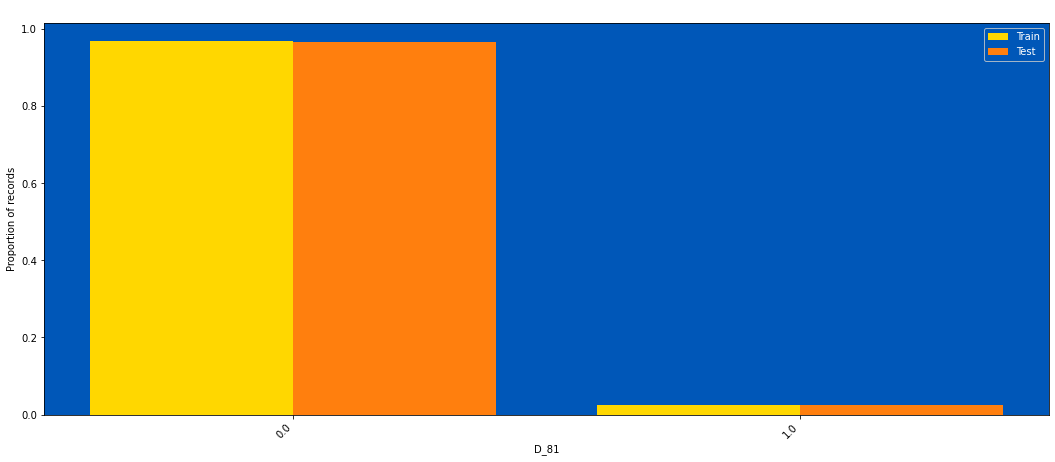

In [144]:
plot_train_test_distribution(train, test, "D_81", nunique_thr=500)

### D_82

4058614 null count, 0.734 null proportion
0.2648 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


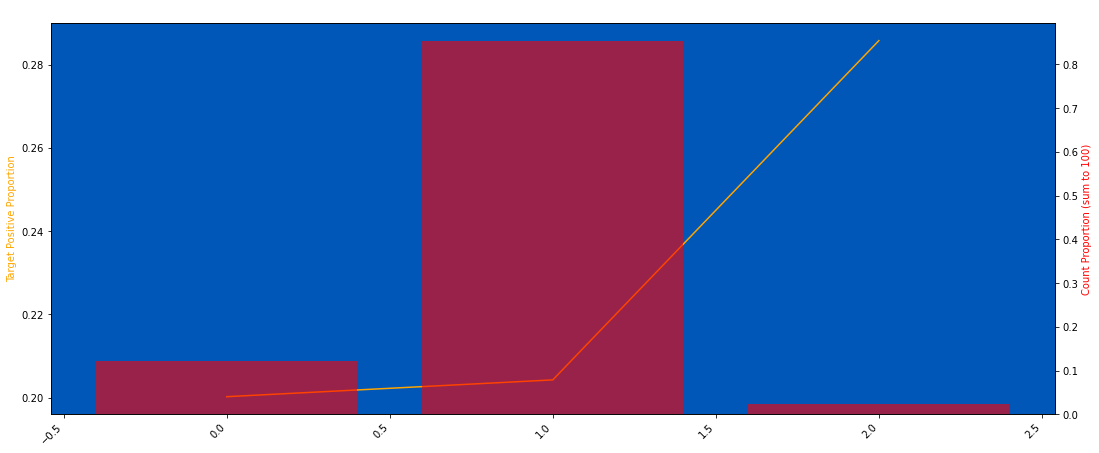

In [145]:
plot_target_check(train, "D_82", q=50, use_raw_bin=True)

Bottom 1% and Top 1% are dropped from this chart


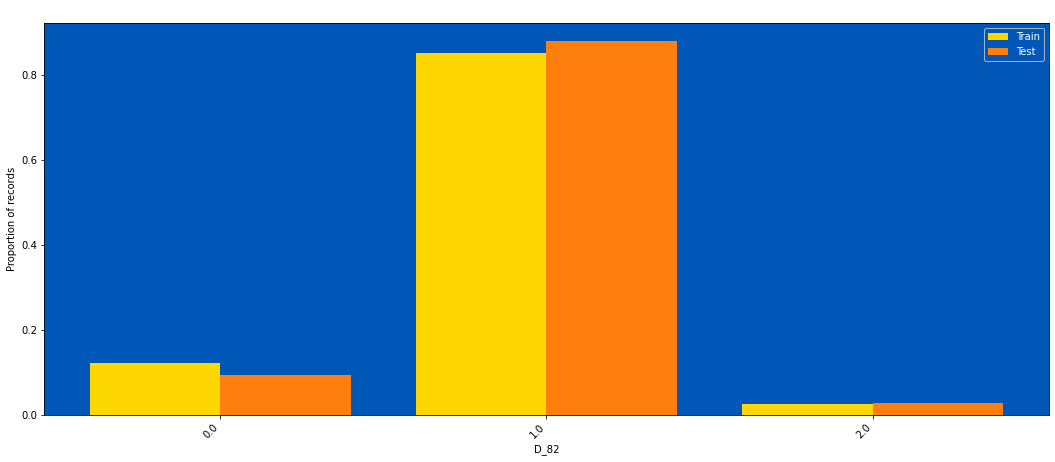

In [146]:
plot_train_test_distribution(train, test, "D_82", nunique_thr=500)

### D_83

194473 null count, 0.035 null proportion
0.4308 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


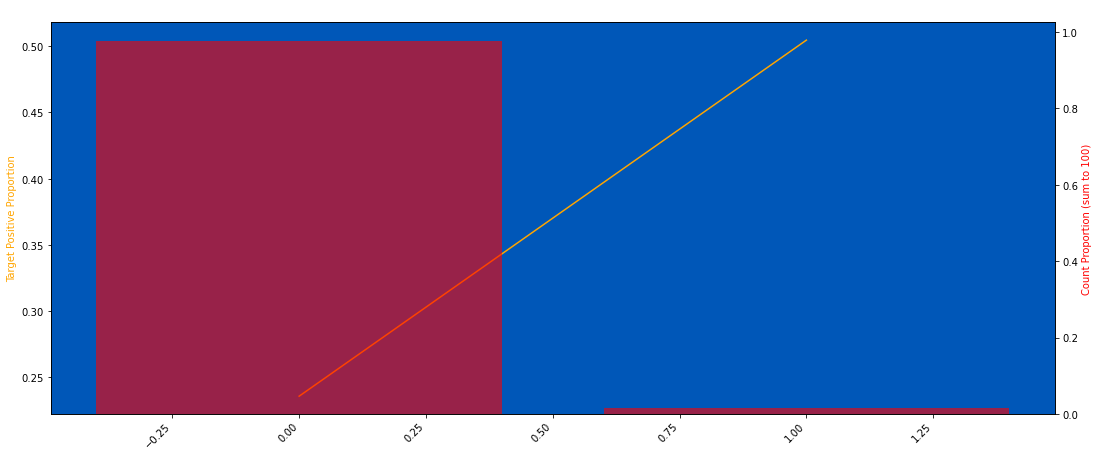

In [147]:
plot_target_check(train, "D_83", q=50, use_raw_bin=True)

Bottom 1% and Top 1% are dropped from this chart


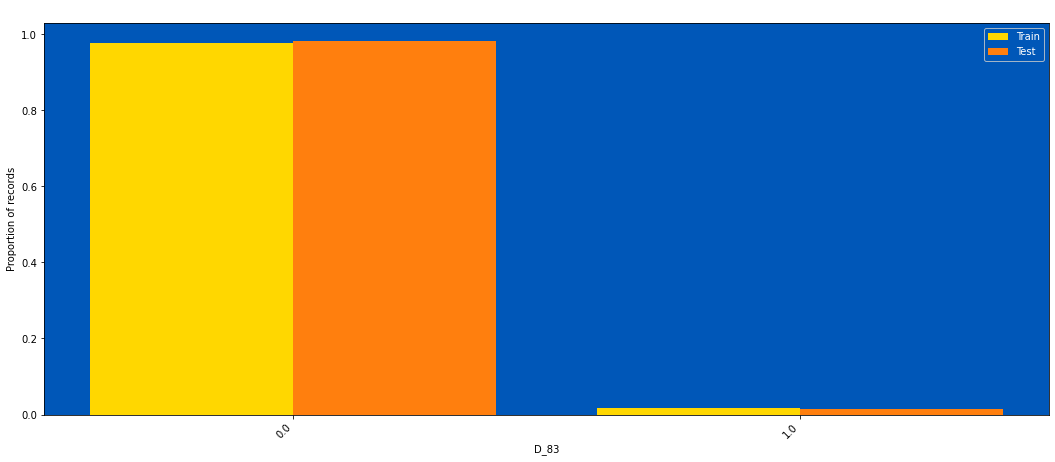

In [148]:
plot_train_test_distribution(train, test, "D_83", nunique_thr=500)

### D_84

29563 null count, 0.005 null proportion
0.3523 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


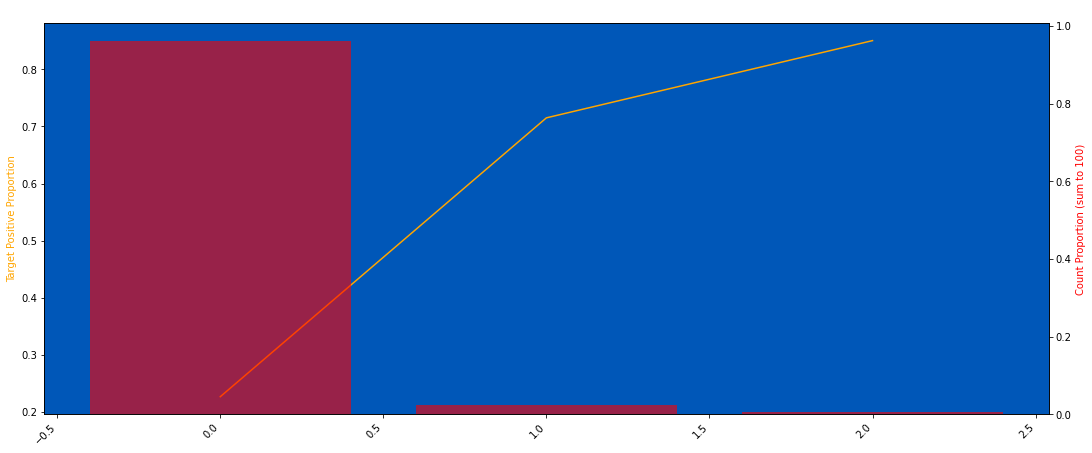

In [149]:
plot_target_check(train, "D_84", q=50, use_raw_bin=True)

Bottom 1% and Top 1% are dropped from this chart


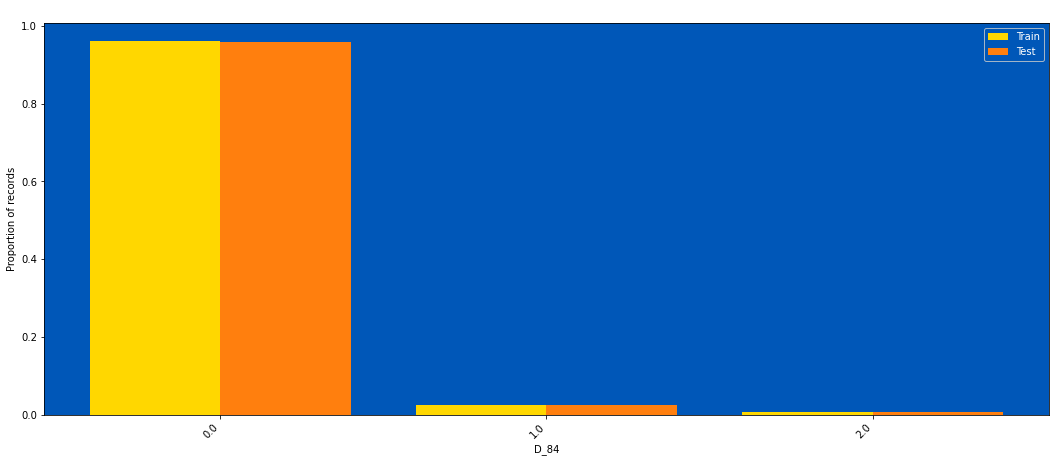

In [150]:
plot_train_test_distribution(train, test, "D_84", nunique_thr=500)

### D_86

0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


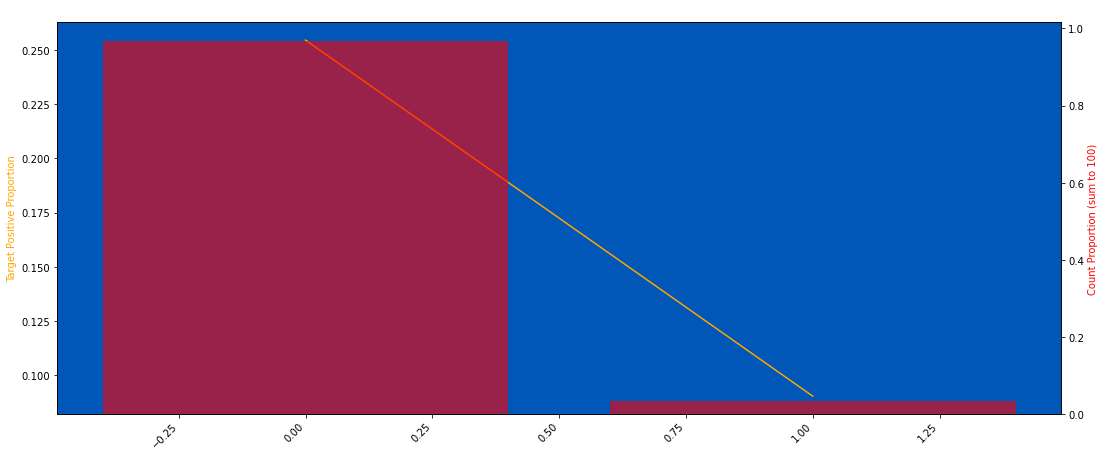

In [151]:
plot_target_check(train, "D_86", q=50, use_raw_bin=True)

Bottom 1% and Top 1% are dropped from this chart


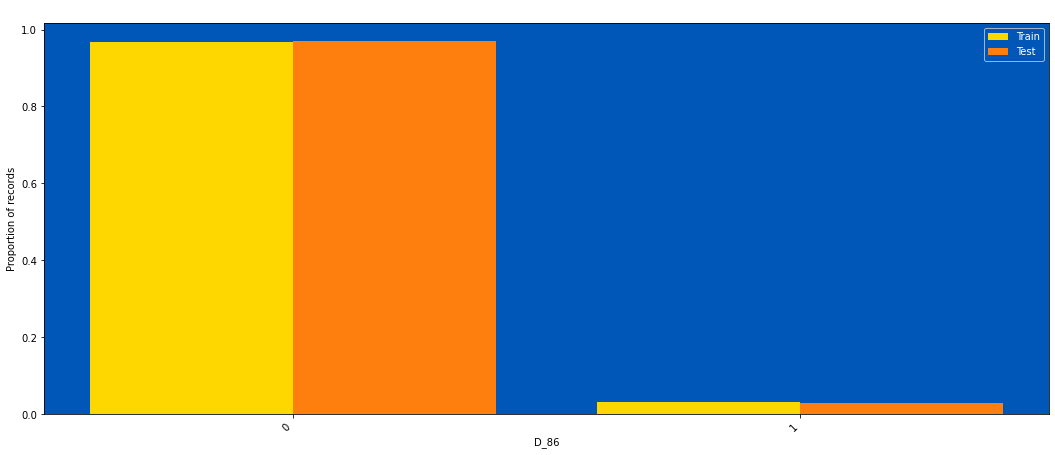

In [152]:
plot_train_test_distribution(train, test, "D_86", nunique_thr=500)

### D_87

5527586 null count, 0.999 null proportion
0.2487 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


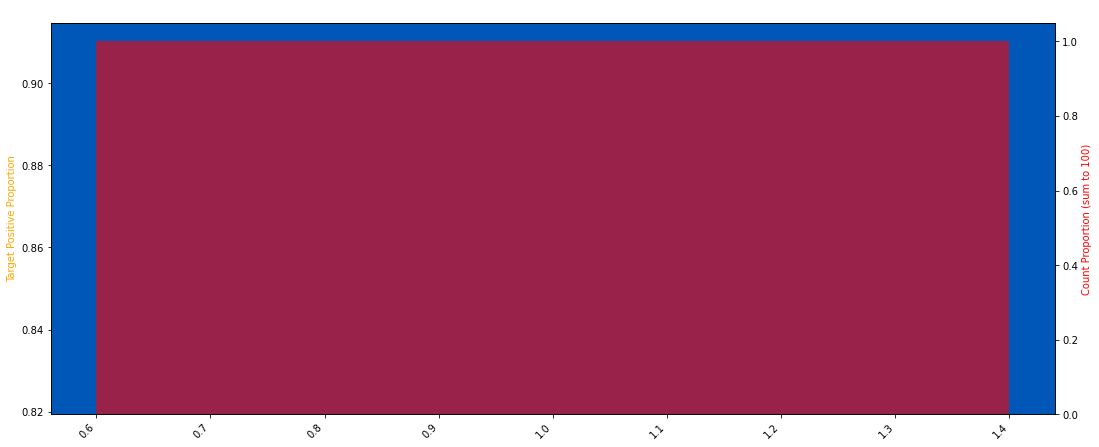

In [153]:
plot_target_check(train, "D_87", q=100, use_raw_bin=True)

In [154]:
# %time
# train = train.drop(columns="D_87", errors="ignore")
# test = test.drop(columns="D_87", errors="ignore")

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 3.1 µs


### D_88

5525447 null count, 0.999 null proportion
0.2485 of the targets have label = 1


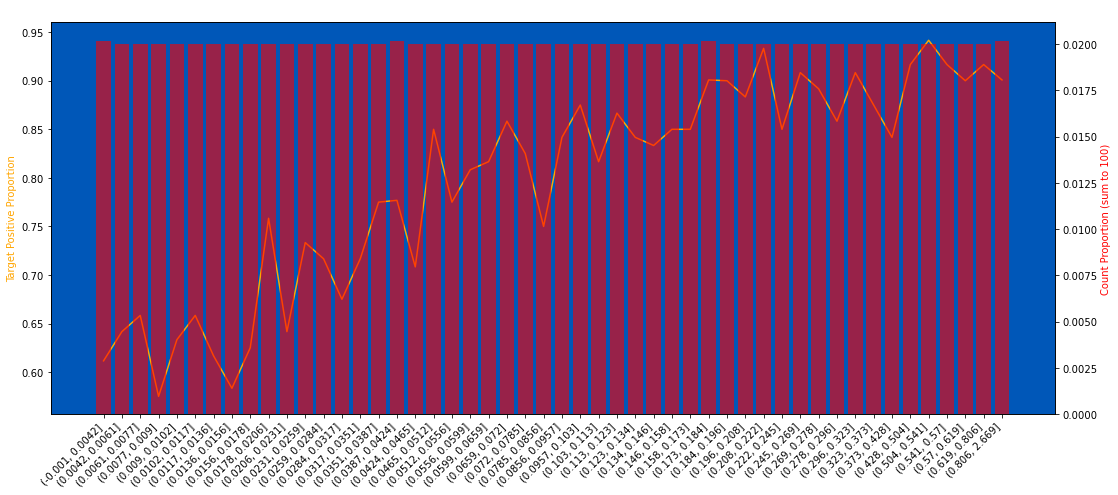

In [155]:
plot_target_check(train, "D_88", q=50, use_raw_bin=True)

In [156]:
train["D_88"] = train["D_88"].round(2)
test["D_88"] = test["D_88"].round(2)

5525447 null count, 0.999 null proportion
0.2485 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


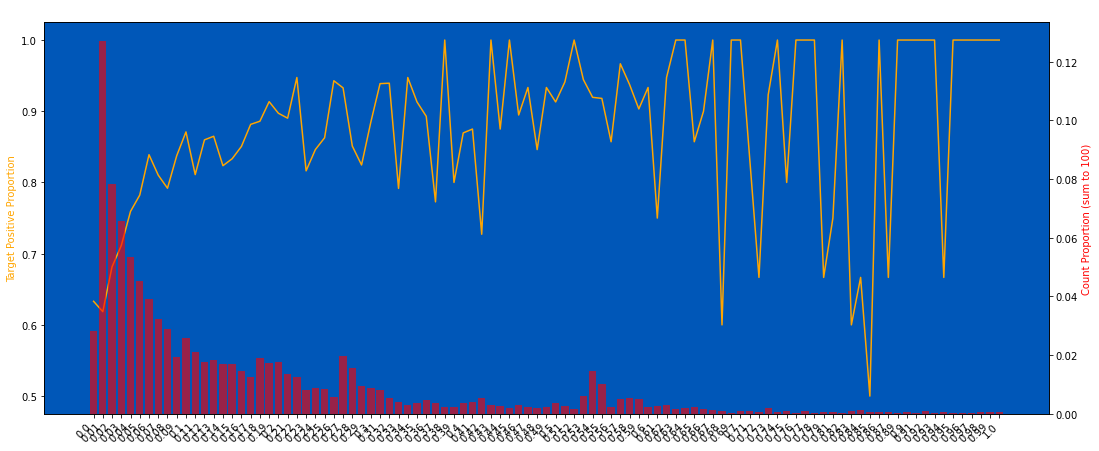

In [157]:
plot_target_check(train, "D_88", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


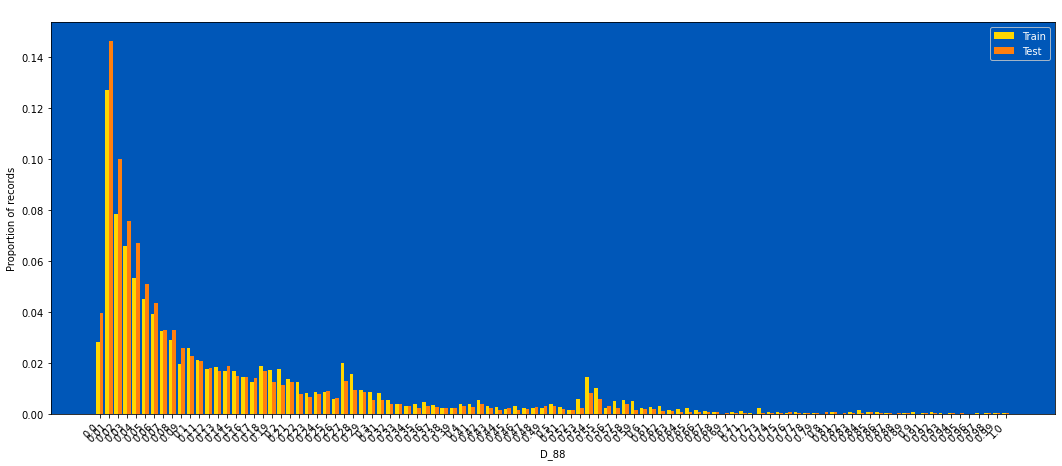

In [158]:
plot_train_test_distribution(train, test, "D_88", nunique_thr=500)

### D_89

29563 null count, 0.005 null proportion
0.3523 of the targets have label = 1


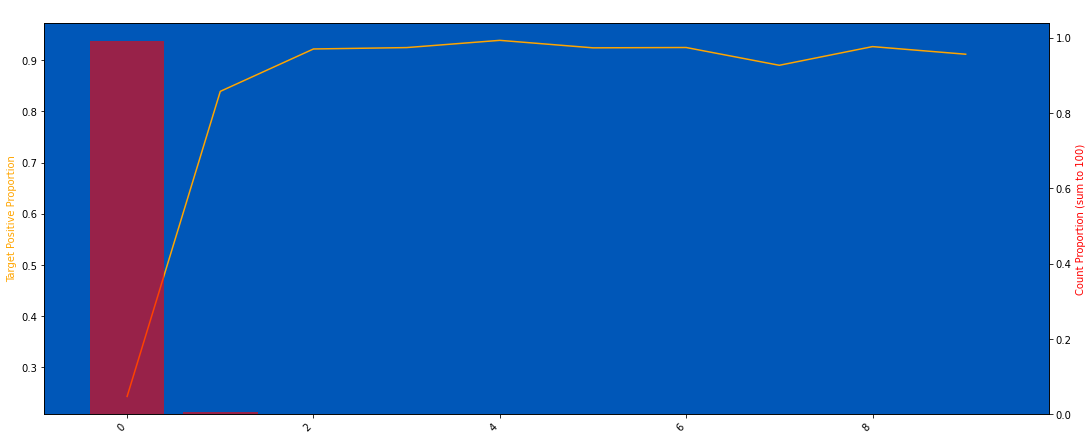

In [159]:
plot_target_check(train, "D_89", q=50, use_raw_bin=True, nunique_thr=12)

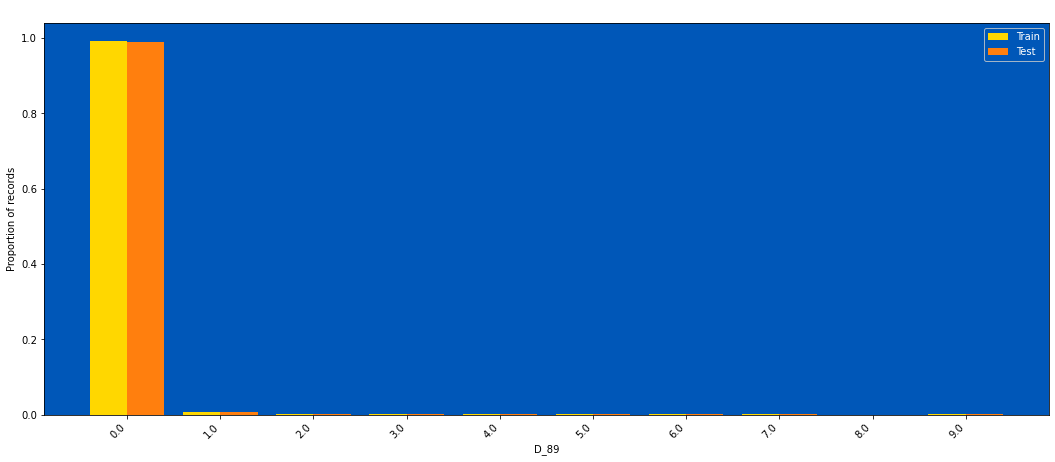

In [160]:
plot_train_test_distribution(train, test, "D_89", nunique_thr=12)

### D_91

157216 null count, 0.028 null proportion
0.4663 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


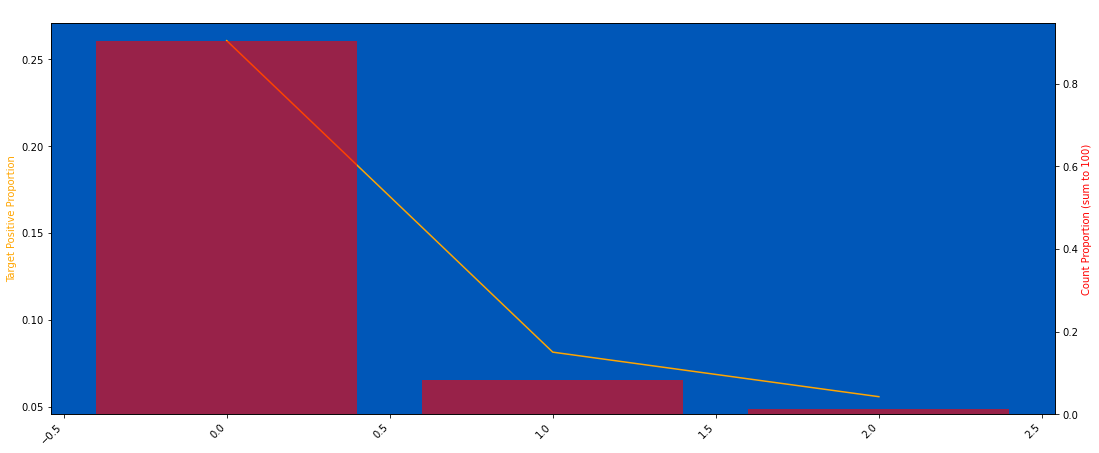

In [161]:
plot_target_check(train, "D_91", q=50, use_raw_bin=True)

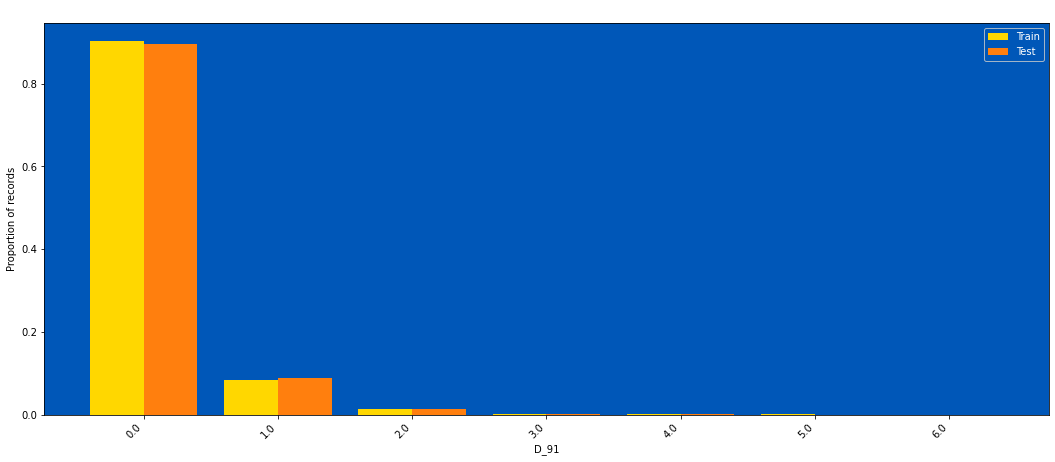

In [162]:
plot_train_test_distribution(train, test, "D_91", nunique_thr=12)

### D_92

0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


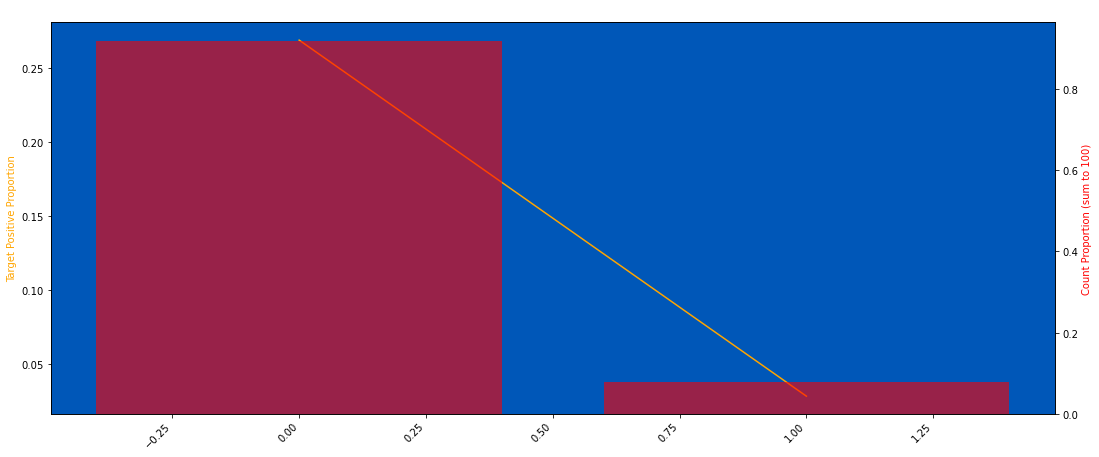

In [163]:
plot_target_check(train, "D_92", q=50, use_raw_bin=True)

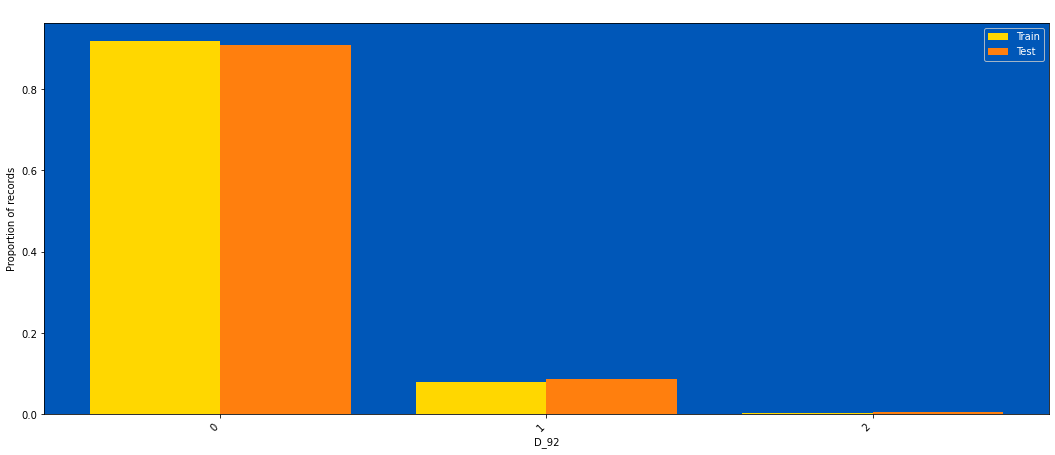

In [164]:
plot_train_test_distribution(train, test, "D_92", nunique_thr=12)

### D_93

0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


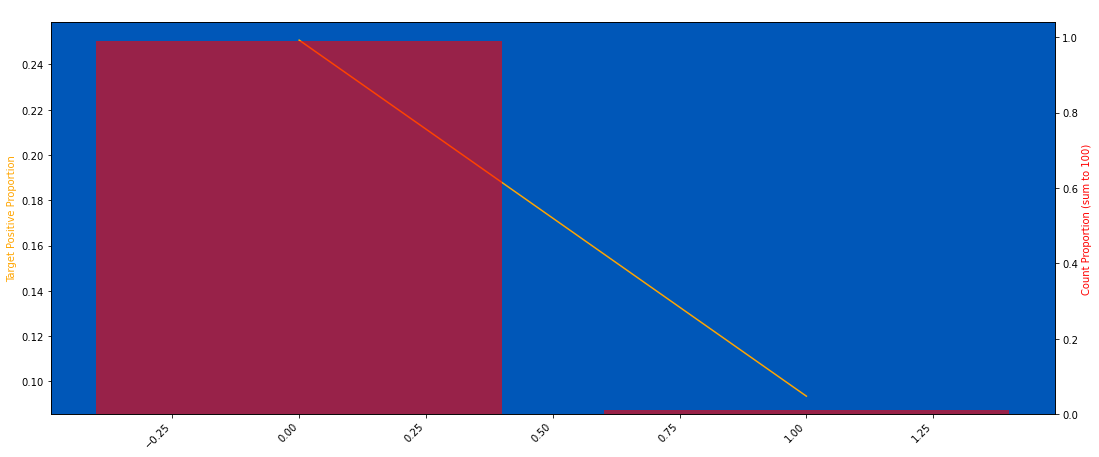

In [165]:
plot_target_check(train, "D_93", q=50, use_raw_bin=True)

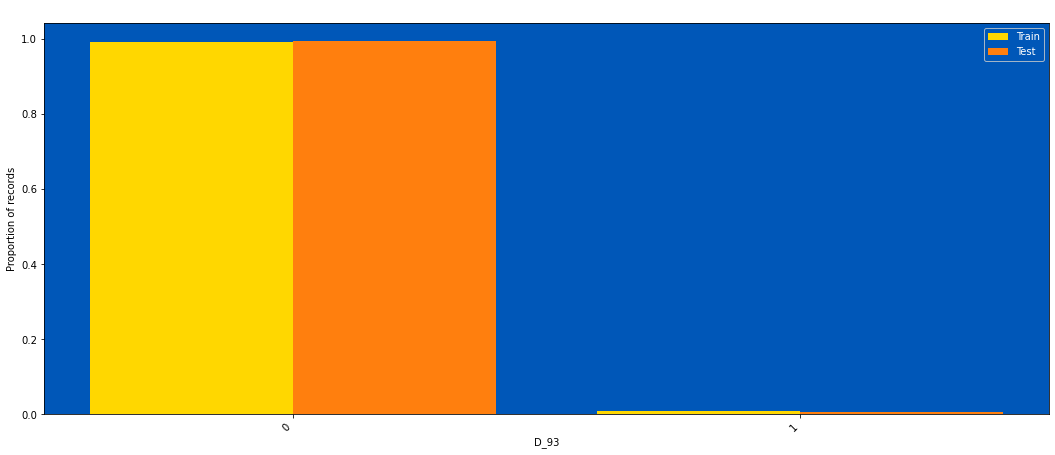

In [166]:
plot_train_test_distribution(train, test, "D_93", nunique_thr=12)

### D_94

0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


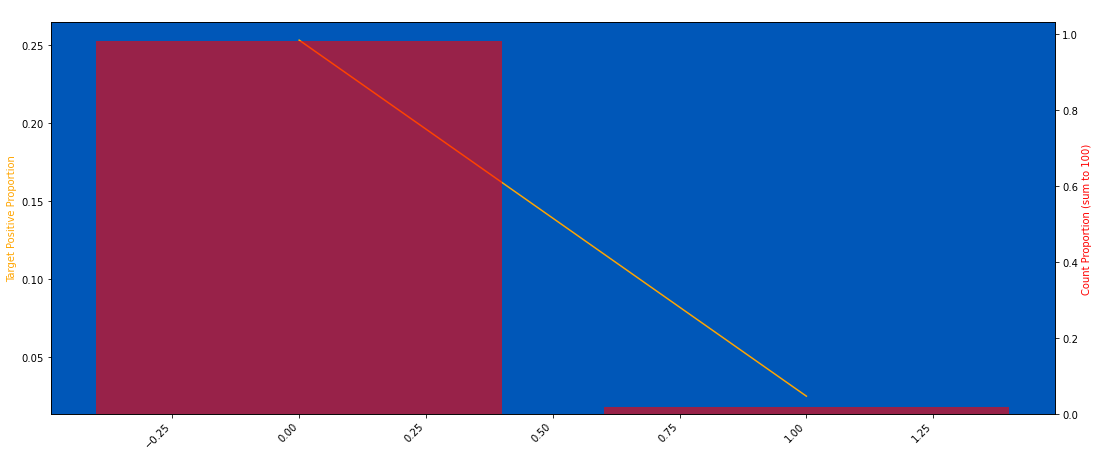

In [167]:
plot_target_check(train, "D_94", q=50, use_raw_bin=True)

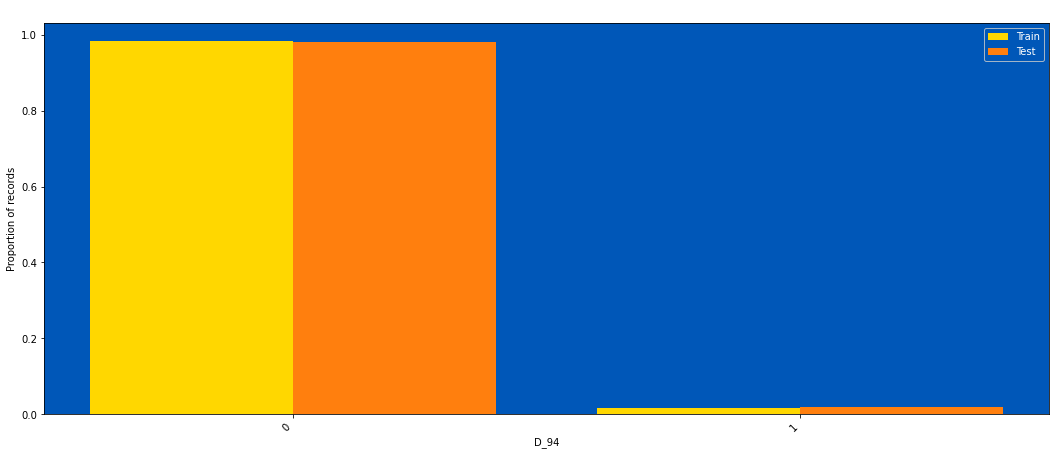

In [168]:
plot_train_test_distribution(train, test, "D_94", nunique_thr=12)

### D_96

0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


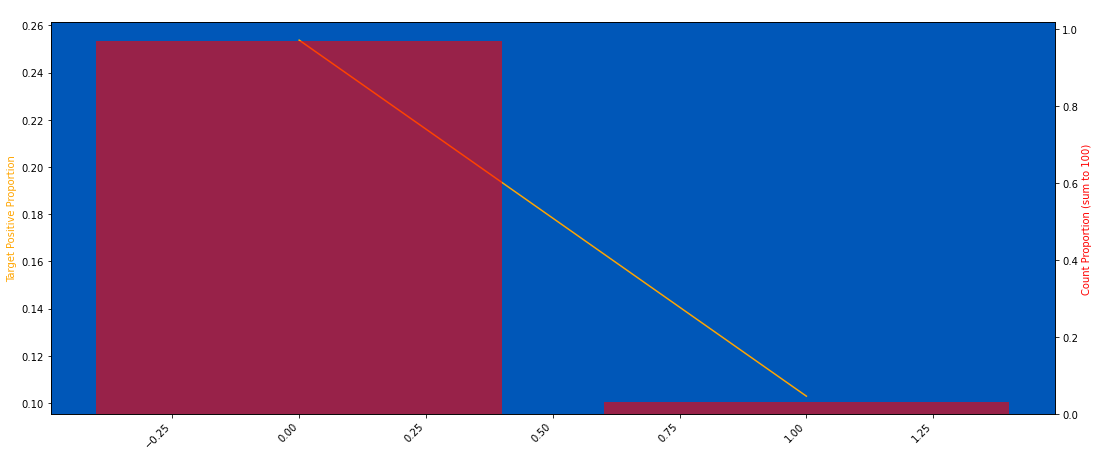

In [169]:
plot_target_check(train, "D_96", q=50, use_raw_bin=True)

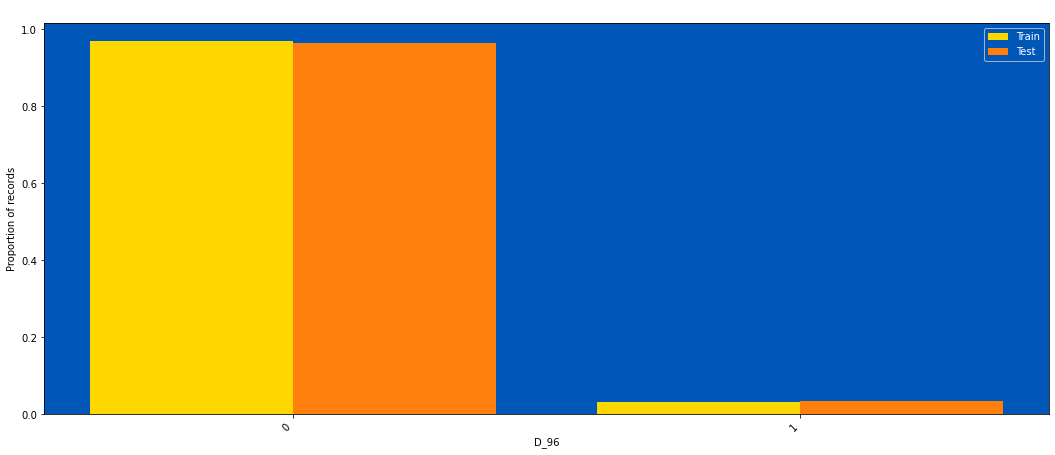

In [170]:
plot_train_test_distribution(train, test, "D_96", nunique_thr=12)

### D_102

40655 null count, 0.007 null proportion
0.4091 of the targets have label = 1


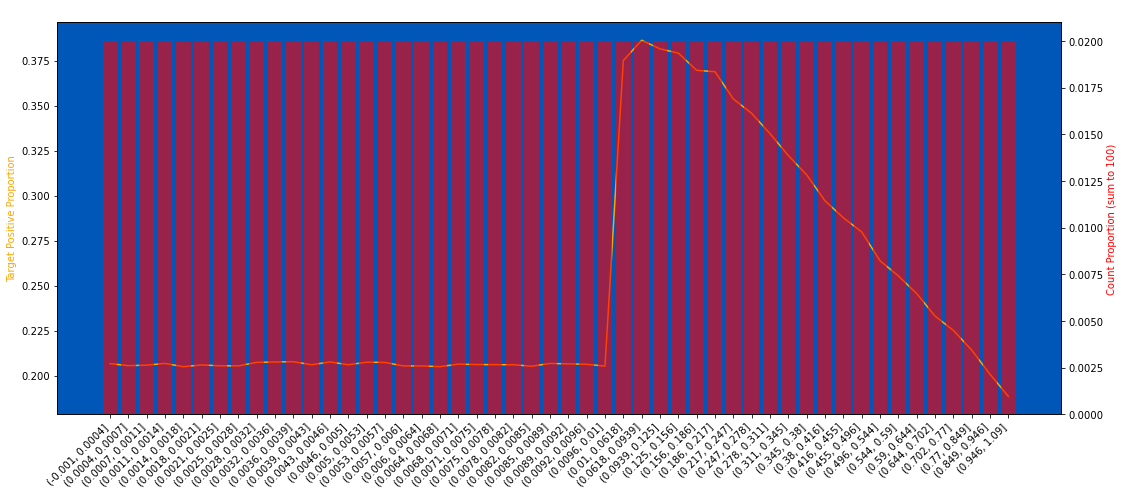

In [171]:
plot_target_check(train, "D_102", q=50, use_raw_bin=True)

In [172]:
train["D_102"] = train["D_102"].round(2)
test["D_102"] = test["D_102"].round(2)

In [173]:
train.loc[train["D_102"].between(-0.01, 0.01), "D_102"] = np.nan
test.loc[test["D_102"].between(-0.01, 0.01), "D_102"] = np.nan

3127092 null count, 0.565 null proportion
0.2089 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


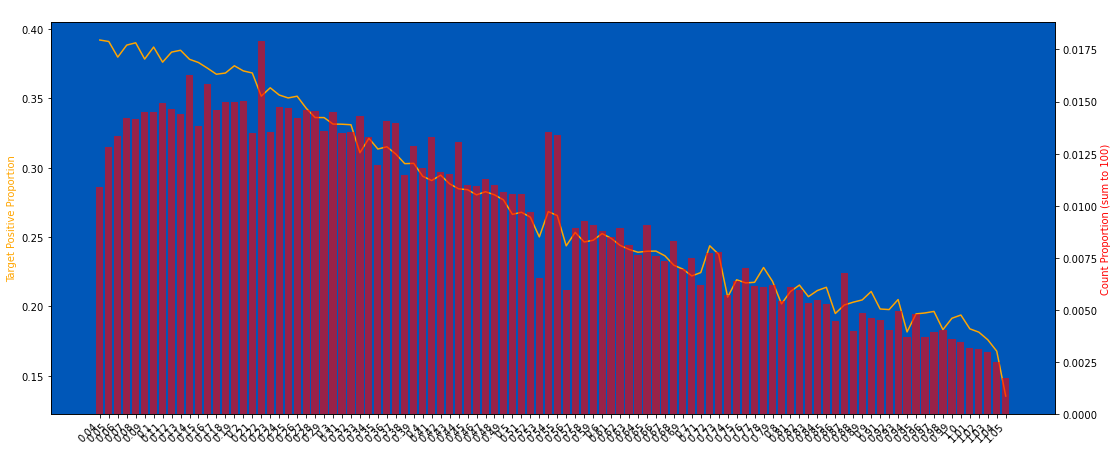

In [174]:
plot_target_check(train, "D_102", q=50, use_raw_bin=True, nunique_thr=2000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


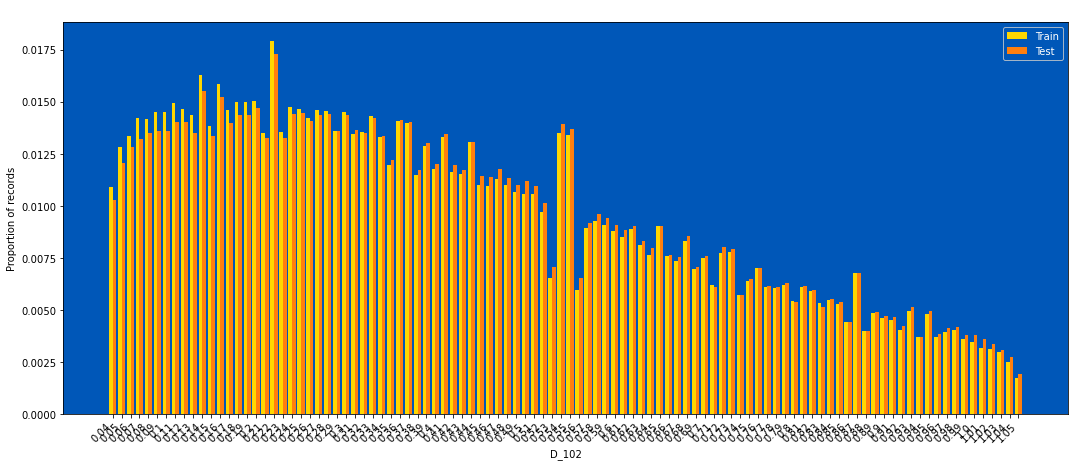

In [175]:
plot_train_test_distribution(train, test, "D_102", nunique_thr=2000)

### D_103

101548 null count, 0.018 null proportion
0.3576 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


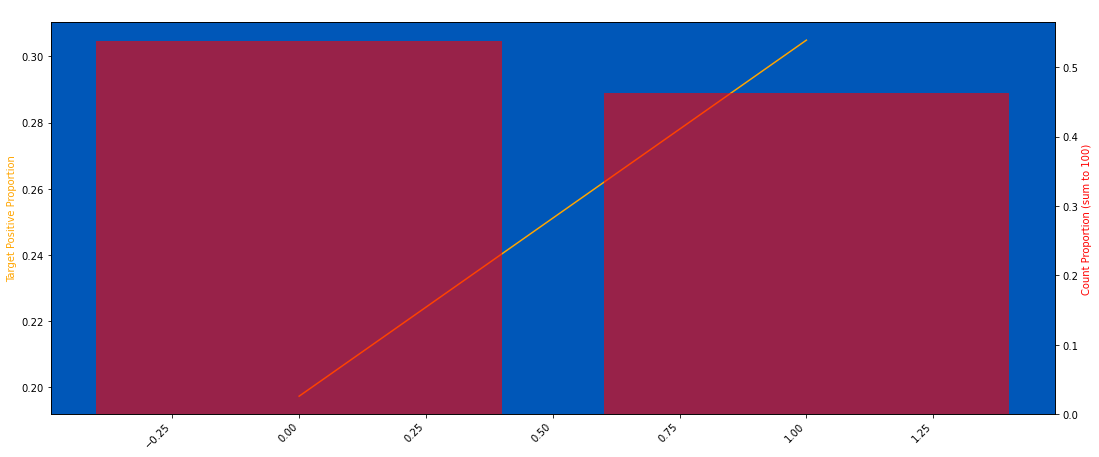

In [176]:
plot_target_check(train, "D_103", q=50, use_raw_bin=True)

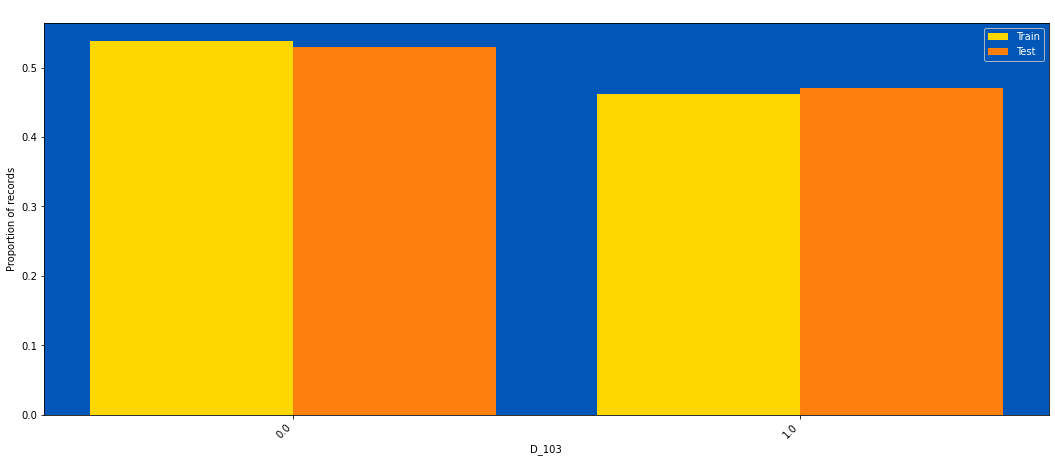

In [177]:
plot_train_test_distribution(train, test, "D_103", nunique_thr=12)

### D_104

101548 null count, 0.018 null proportion
0.3576 of the targets have label = 1


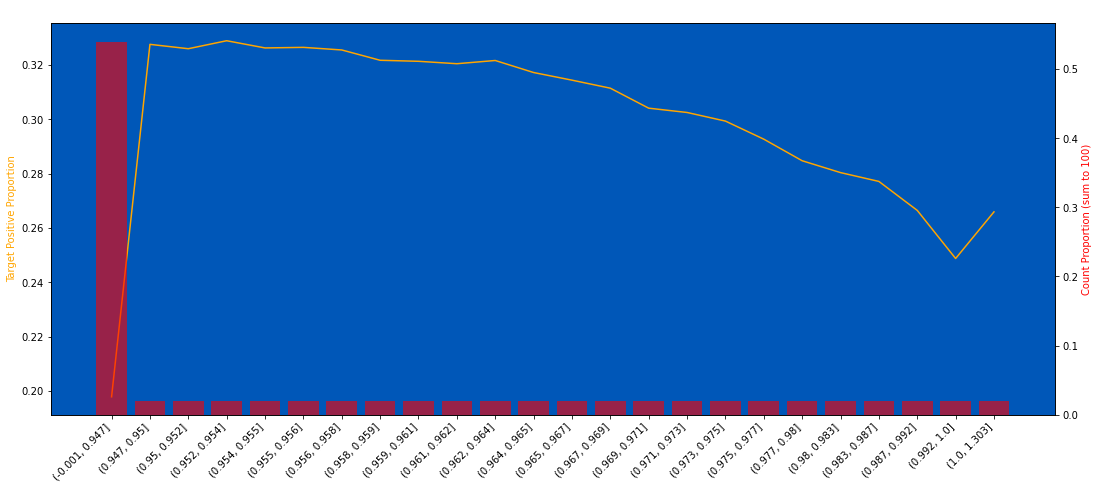

In [178]:
plot_target_check(train, "D_104", q=50, use_raw_bin=True)

In [179]:
train["D_104"] = train["D_104"].round(2)
test["D_104"] = test["D_104"].round(2)

In [180]:
train.loc[train["D_104"].between(1, 1.01), "D_104"] = 1
test.loc[test["D_104"].between(1, 1.01), "D_104"] = 1

In [181]:
train.loc[train["D_104"] == 0, "D_104"] = np.nan
test.loc[test["D_104"] == 0, "D_104"] = np.nan

3021407 null count, 0.546 null proportion
0.2027 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


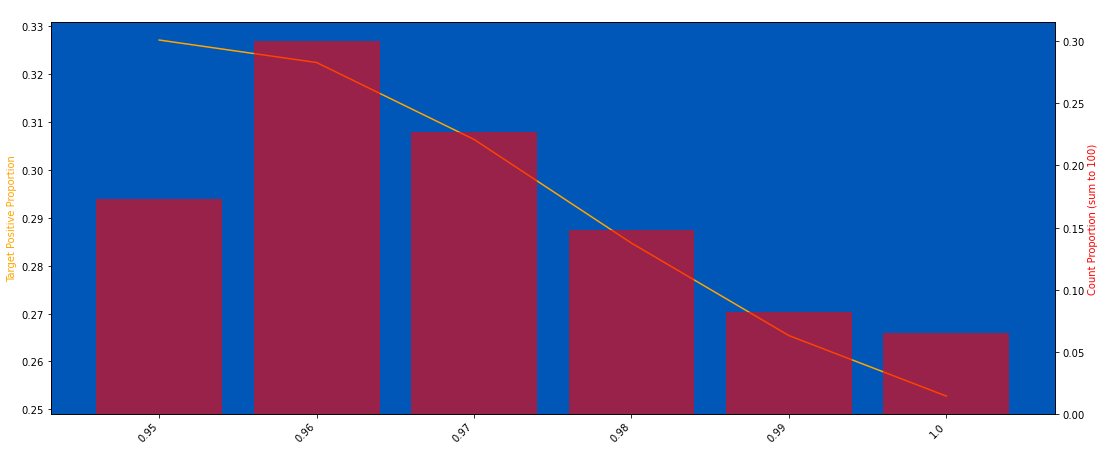

In [182]:
plot_target_check(train, "D_104", q=50, use_raw_bin=True, nunique_thr=50000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


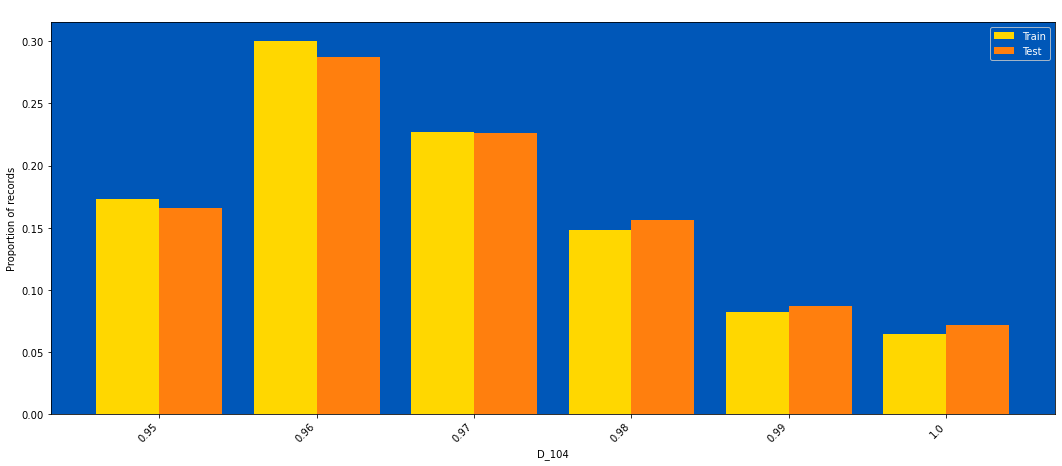

In [183]:
plot_train_test_distribution(train, test, "D_104", nunique_thr=3000)

### D_105

3021431 null count, 0.546 null proportion
0.2027 of the targets have label = 1


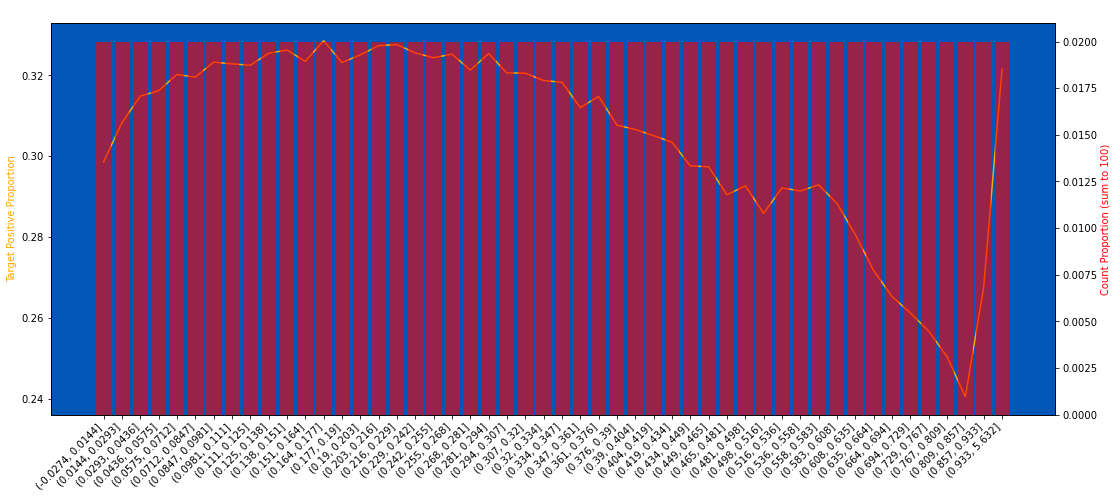

In [184]:
plot_target_check(train, "D_105", q=50, use_raw_bin=True)

In [185]:
train["D_105"] = train["D_105"].round(2)
test["D_105"] = test["D_105"].round(2)

3021431 null count, 0.546 null proportion
0.2027 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


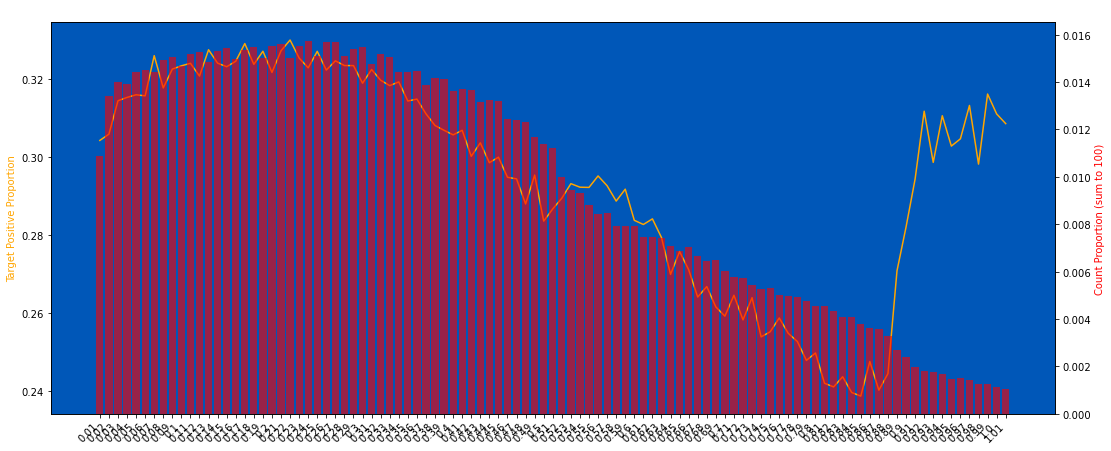

In [186]:
plot_target_check(train, "D_105", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


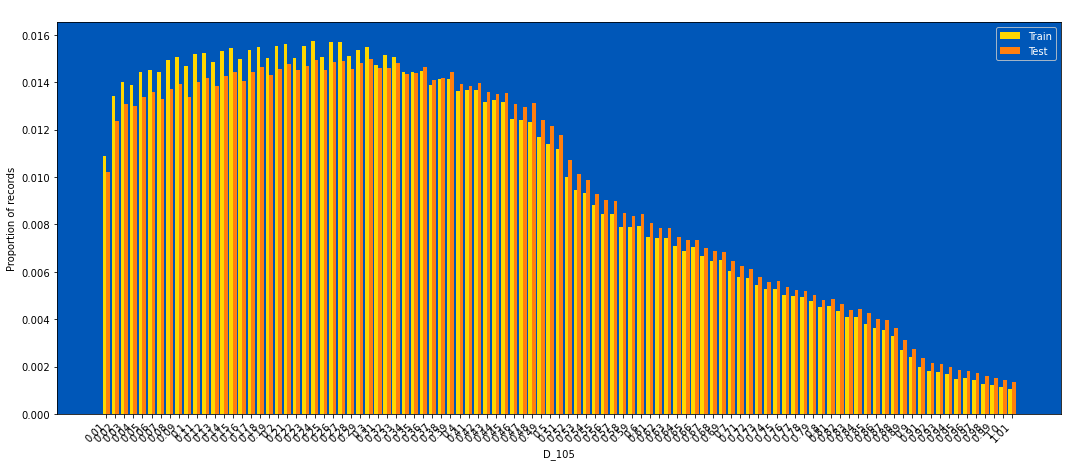

In [187]:
plot_train_test_distribution(train, test, "D_105", nunique_thr=3000)

### D_106

4990102 null count, 0.902 null proportion
0.2164 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


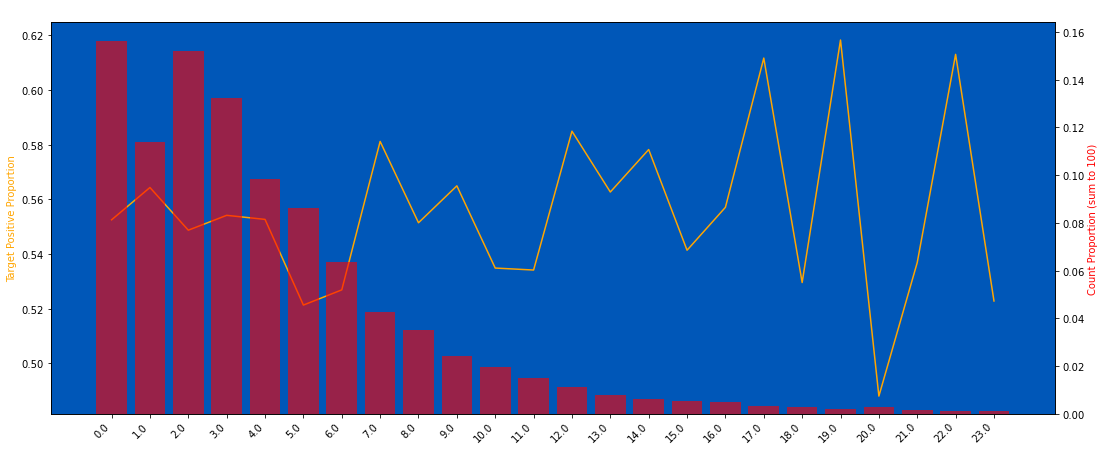

In [188]:
plot_target_check(train, "D_106", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


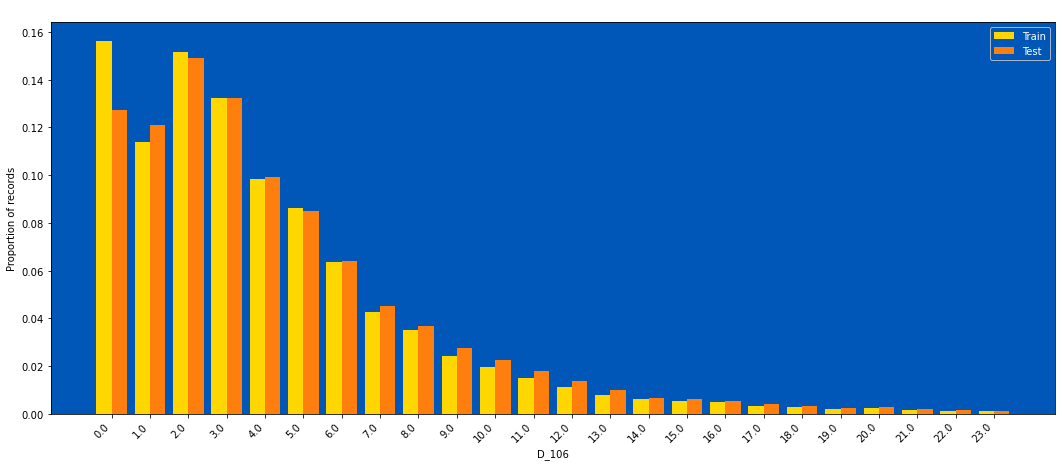

In [189]:
plot_train_test_distribution(train, test, "D_106", nunique_thr=3000)

### D_107

101548 null count, 0.018 null proportion
0.3576 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


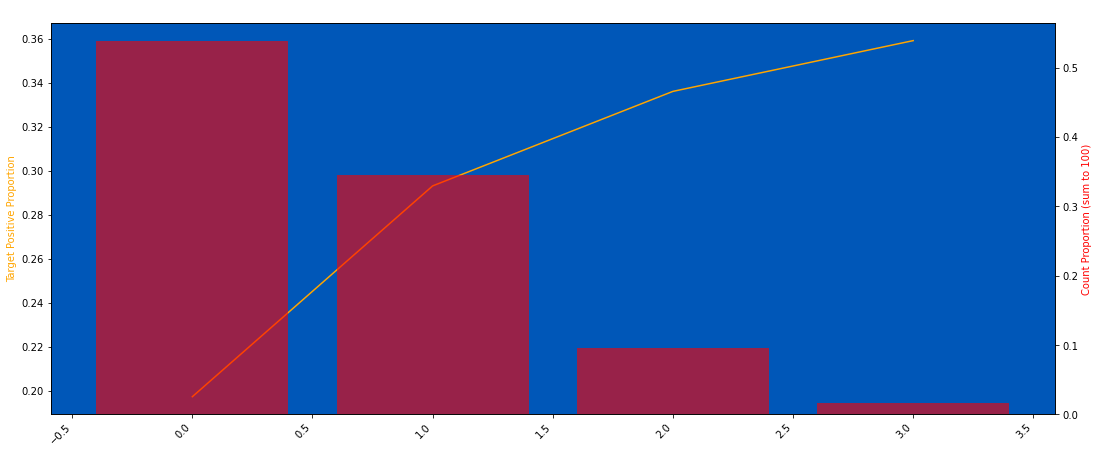

In [190]:
plot_target_check(train, "D_107", q=50, use_raw_bin=True)

Bottom 1% and Top 1% are dropped from this chart


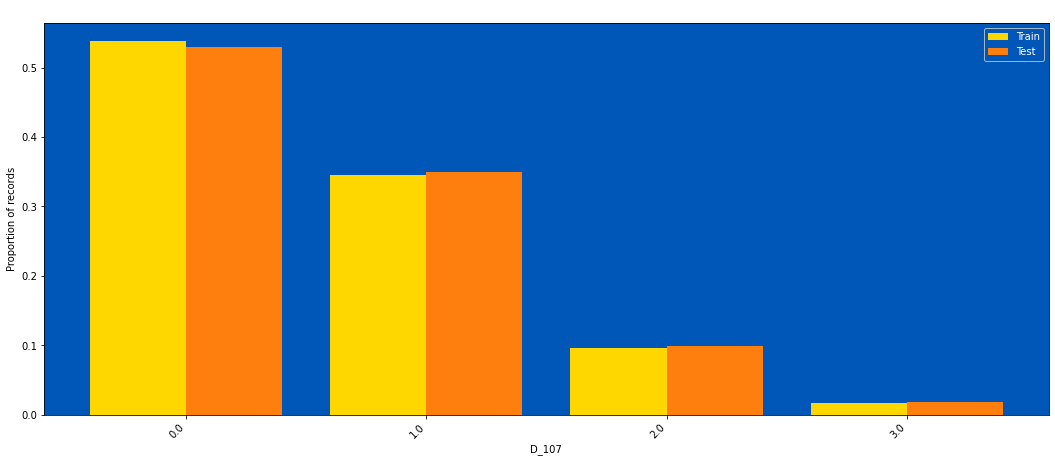

In [191]:
plot_train_test_distribution(train, test, "D_107", nunique_thr=3000)

### D_108

5502513 null count, 0.995 null proportion
0.2482 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


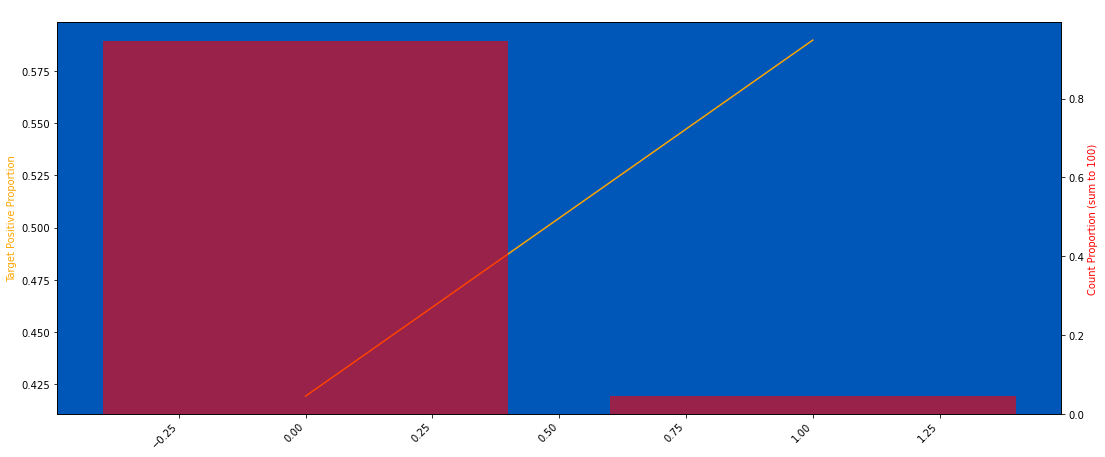

In [192]:
plot_target_check(train, "D_108", q=50, use_raw_bin=True)

Bottom 1% and Top 1% are dropped from this chart


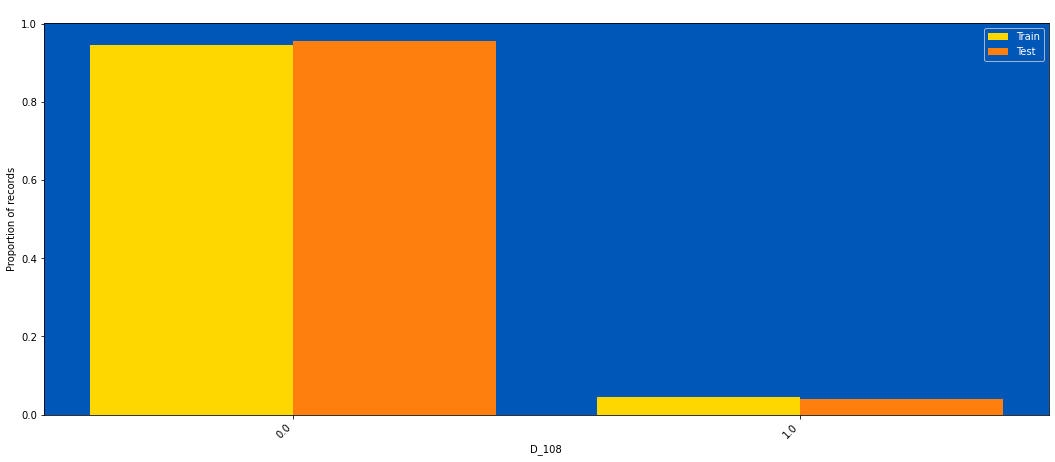

In [193]:
plot_train_test_distribution(train, test, "D_108", nunique_thr=3000)

### D_109

1597 null count, 0.000 null proportion
0.2298 of the targets have label = 1


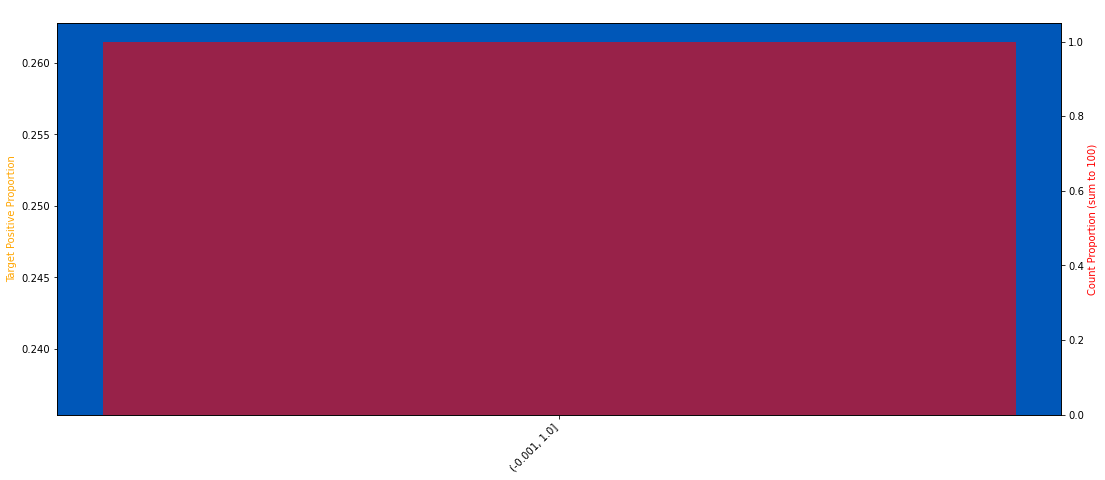

In [194]:
plot_target_check(train, "D_109", q=2, use_raw_bin=True, nunique_thr=1)

### D_110

5500117 null count, 0.994 null proportion
0.2473 of the targets have label = 1


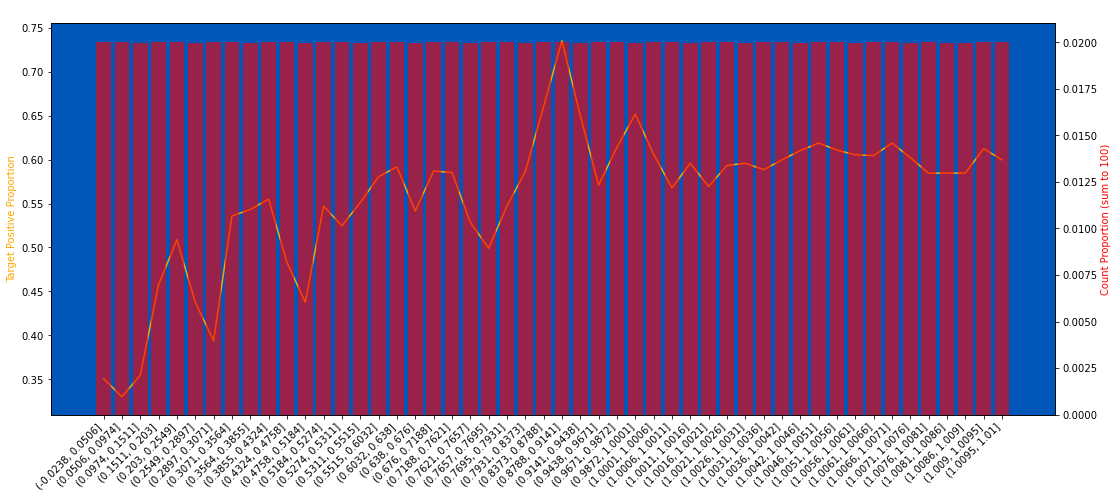

In [195]:
plot_target_check(train, "D_110", q=50, use_raw_bin=True)

In [196]:
train["D_110"] = train["D_110"].round(2)
test["D_110"] = test["D_110"].round(2)

5500117 null count, 0.994 null proportion
0.2473 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


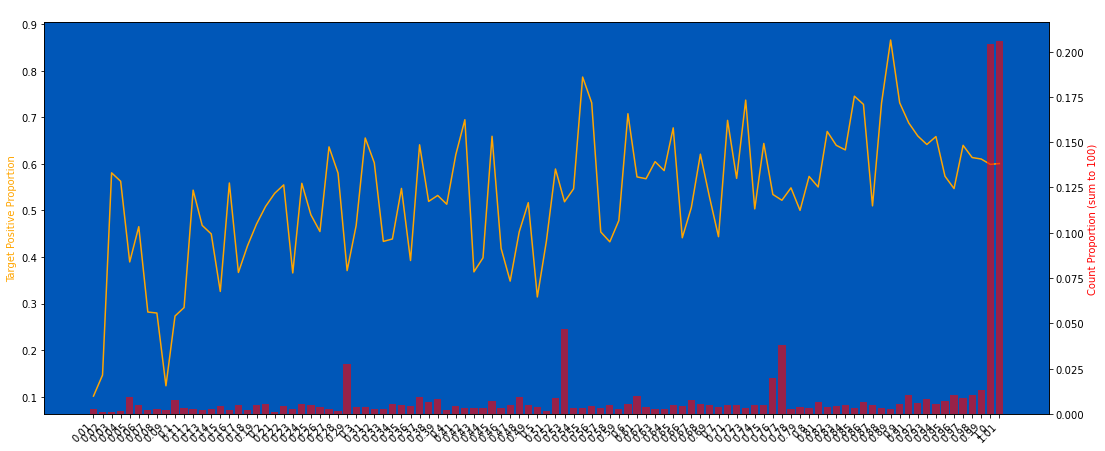

In [197]:
plot_target_check(train, "D_110", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


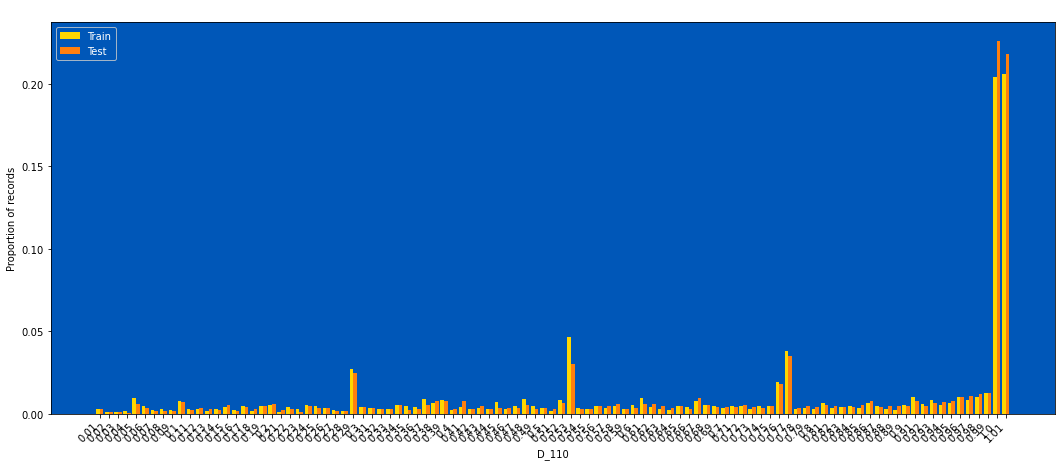

In [198]:
plot_train_test_distribution(train, test, "D_110", nunique_thr=3000)

### D_111

5500117 null count, 0.994 null proportion
0.2473 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


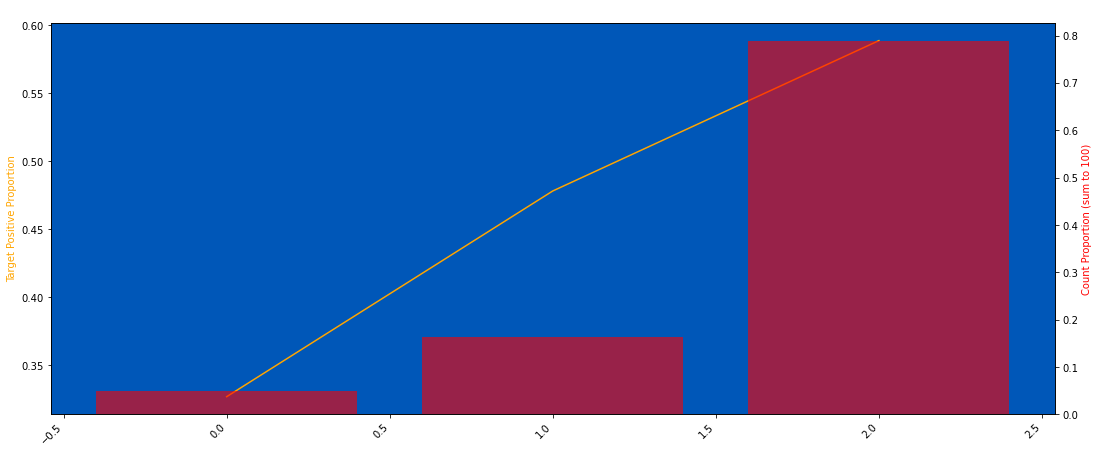

In [199]:
plot_target_check(train, "D_111", q=50, use_raw_bin=True)

Bottom 1% and Top 1% are dropped from this chart


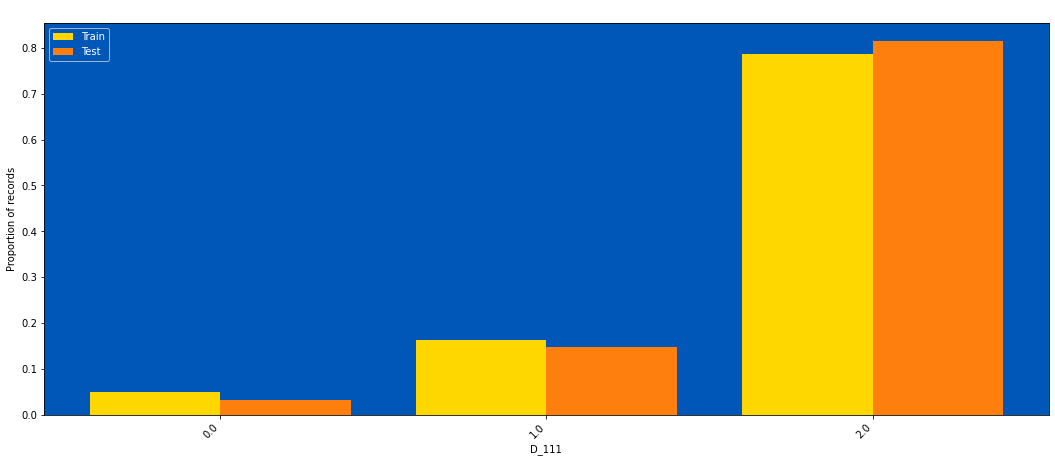

In [200]:
plot_train_test_distribution(train, test, "D_111", nunique_thr=3000)

### D_112

2650 null count, 0.000 null proportion
0.3026 of the targets have label = 1


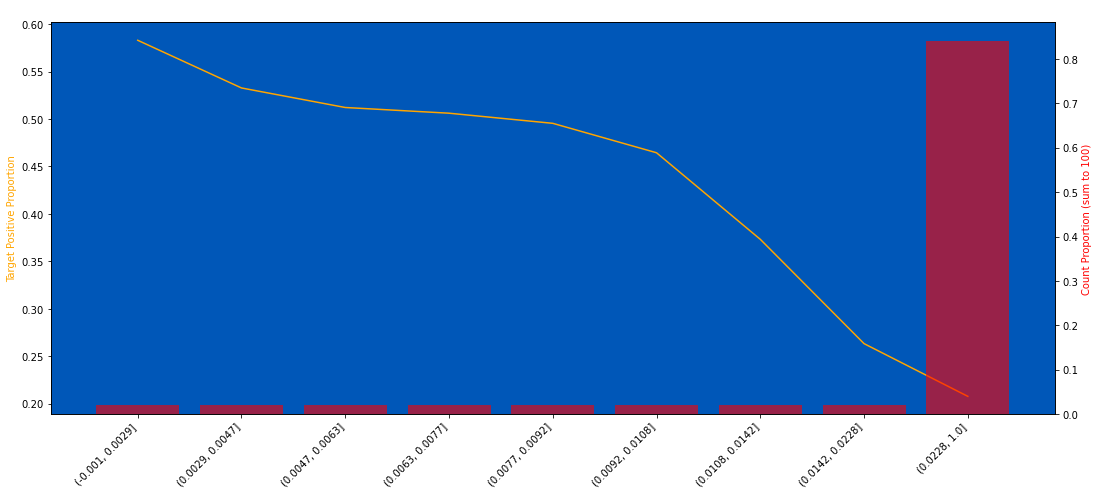

In [201]:
plot_target_check(train, "D_112", q=50, use_raw_bin=True, nunique_thr=1000)

In [202]:
train["D_112"] = train["D_112"].round(2)
test["D_112"] = test["D_112"].round(2)

2650 null count, 0.000 null proportion
0.3026 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


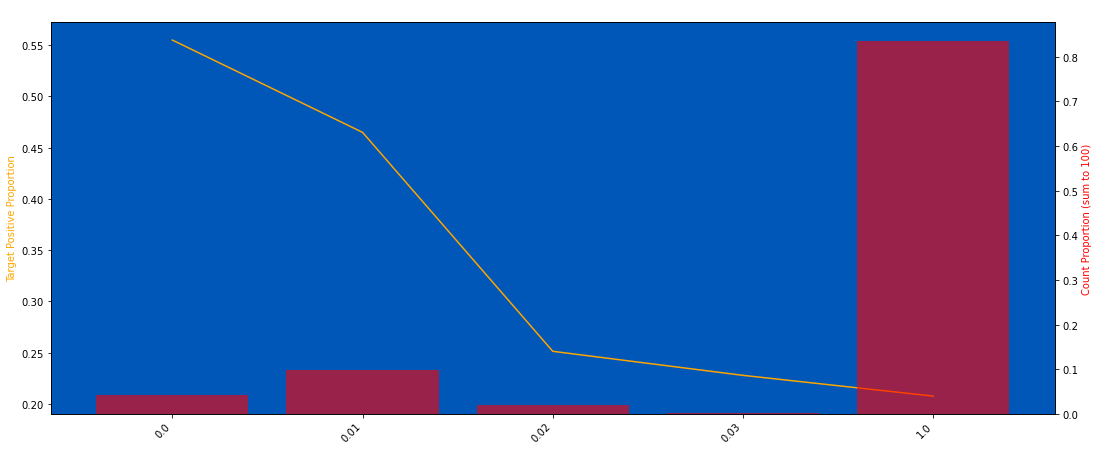

In [203]:
plot_target_check(train, "D_112", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


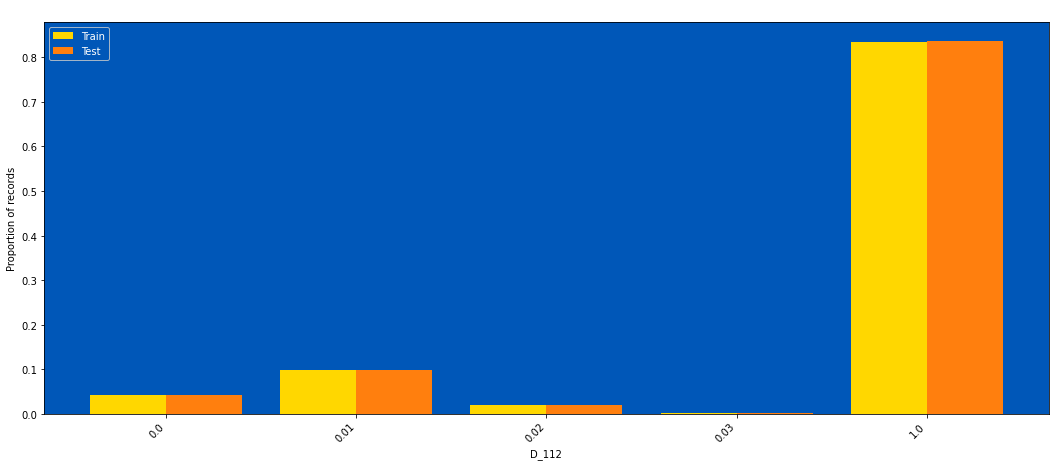

In [204]:
plot_train_test_distribution(train, test, "D_112", nunique_thr=3000)

### D_113

176716 null count, 0.032 null proportion
0.4377 of the targets have label = 1


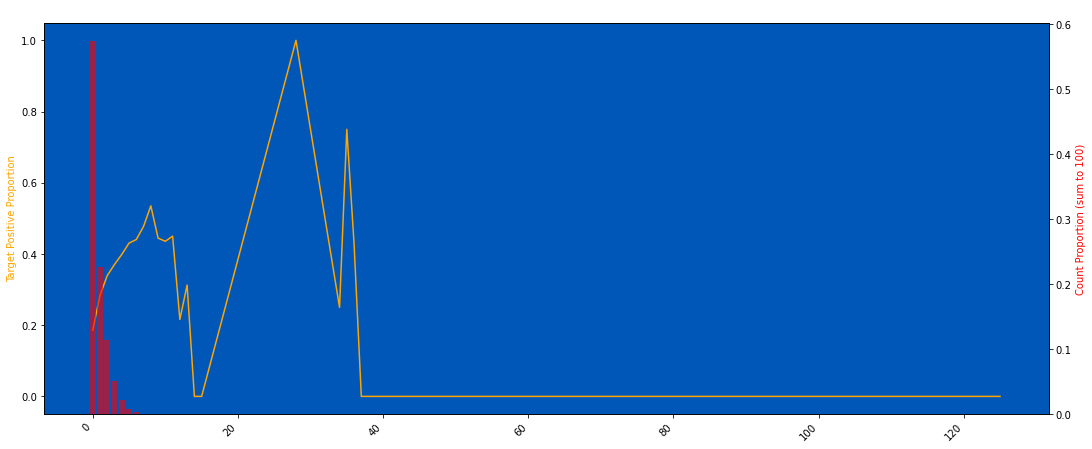

In [205]:
plot_target_check(train, "D_113", q=50, use_raw_bin=True, nunique_thr=50)

Bottom 1% and Top 1% are dropped from this chart


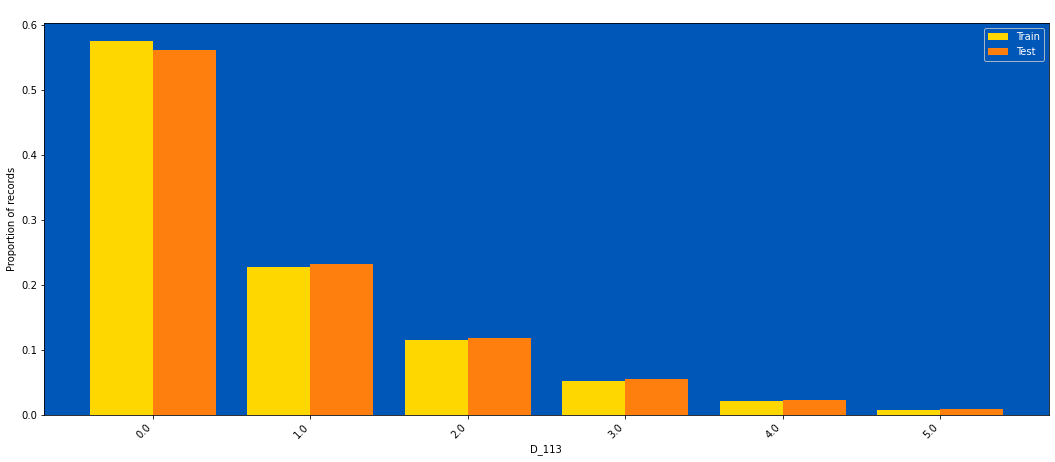

In [206]:
plot_train_test_distribution(train, test, "D_113", nunique_thr=3000)

### D_114

176716 null count, 0.032 null proportion
0.4377 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


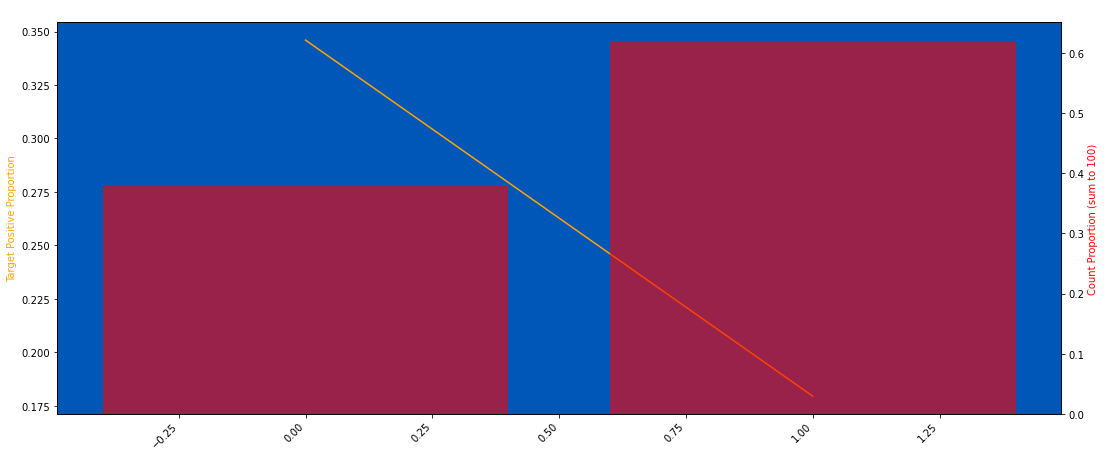

In [207]:
plot_target_check(train, "D_114", q=50, use_raw_bin=True)

Bottom 1% and Top 1% are dropped from this chart


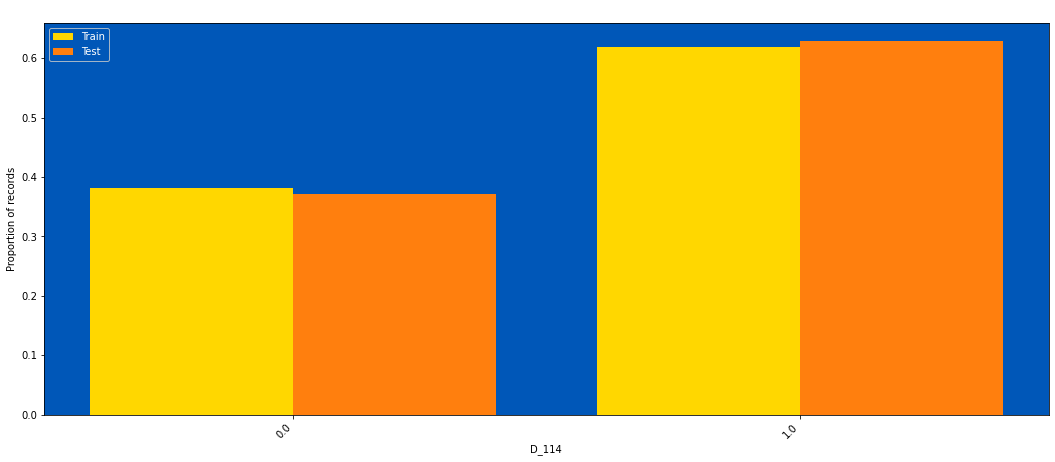

In [208]:
plot_train_test_distribution(train, test, "D_114", nunique_thr=3000)

### D_115

176716 null count, 0.032 null proportion
0.4377 of the targets have label = 1


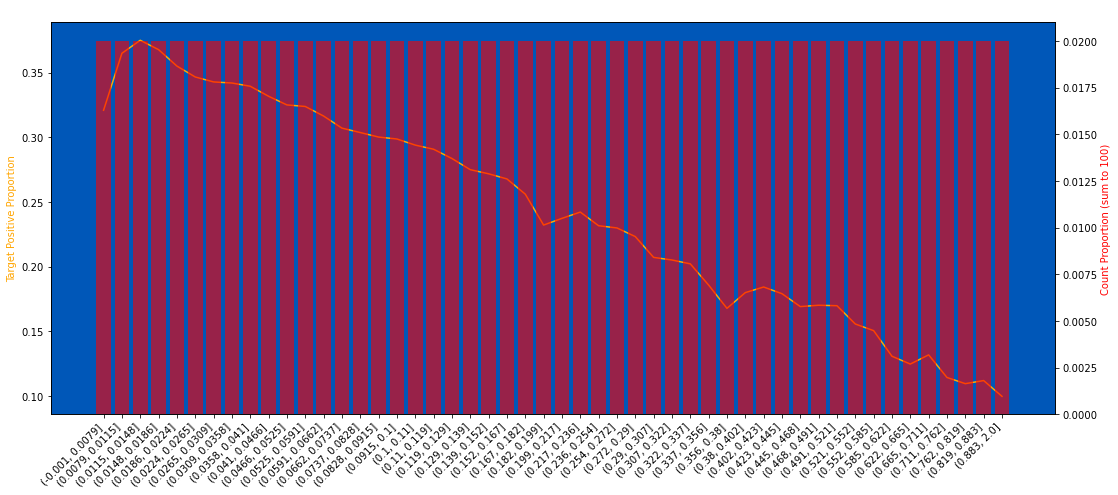

In [209]:
plot_target_check(train, "D_115", q=50, use_raw_bin=True)

In [210]:
train["D_115"] = train["D_115"].round(2)
test["D_115"] = test["D_115"].round(2)

176716 null count, 0.032 null proportion
0.4377 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


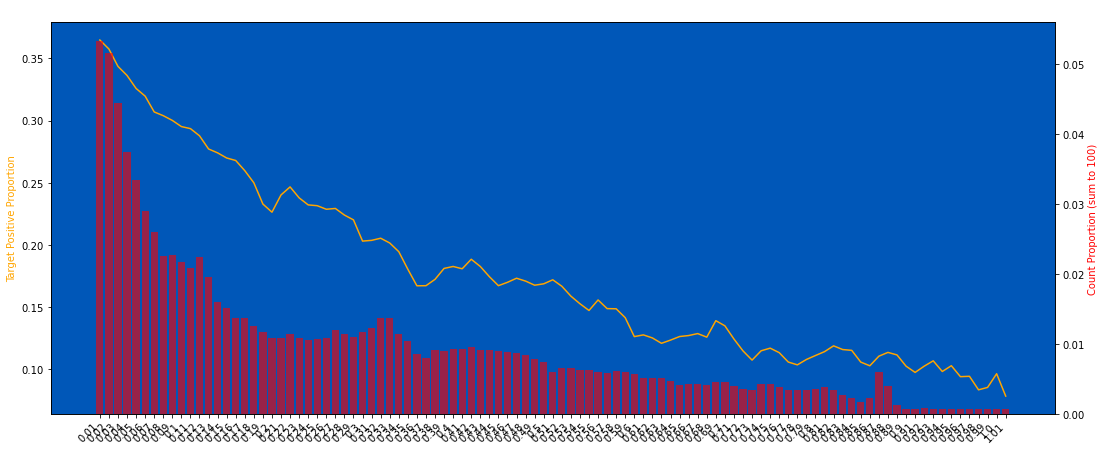

In [211]:
plot_target_check(train, "D_115", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


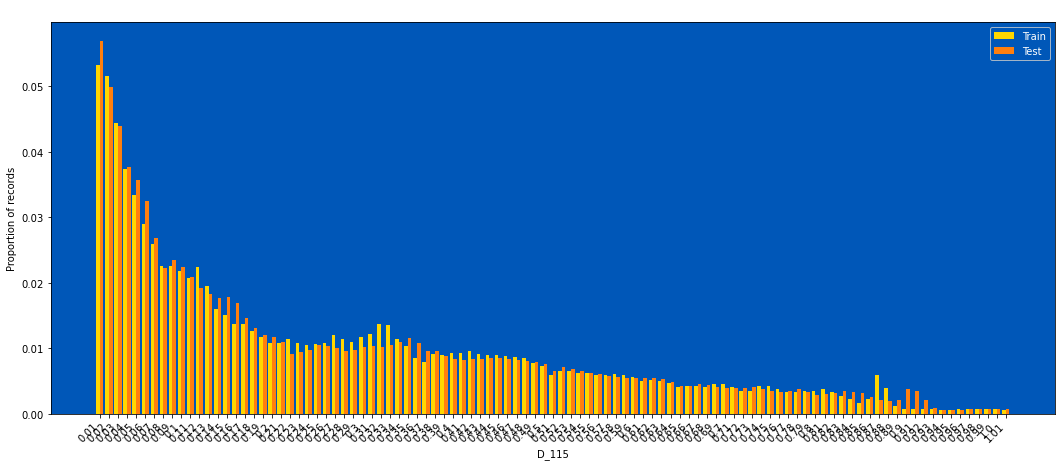

In [212]:
plot_train_test_distribution(train, test, "D_115", nunique_thr=500)

### D_116

176716 null count, 0.032 null proportion
0.4377 of the targets have label = 1


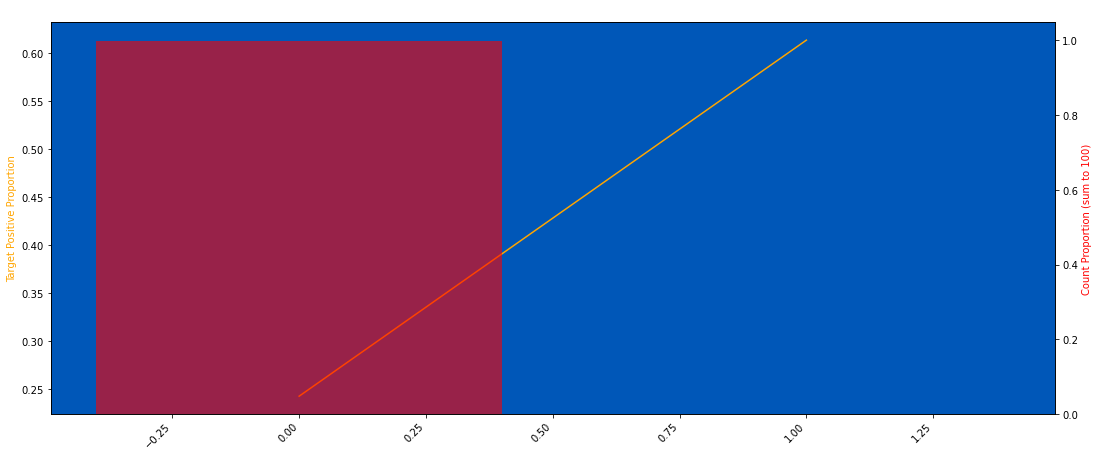

In [213]:
plot_target_check(train, "D_116", q=50, use_raw_bin=True, nunique_thr=5)

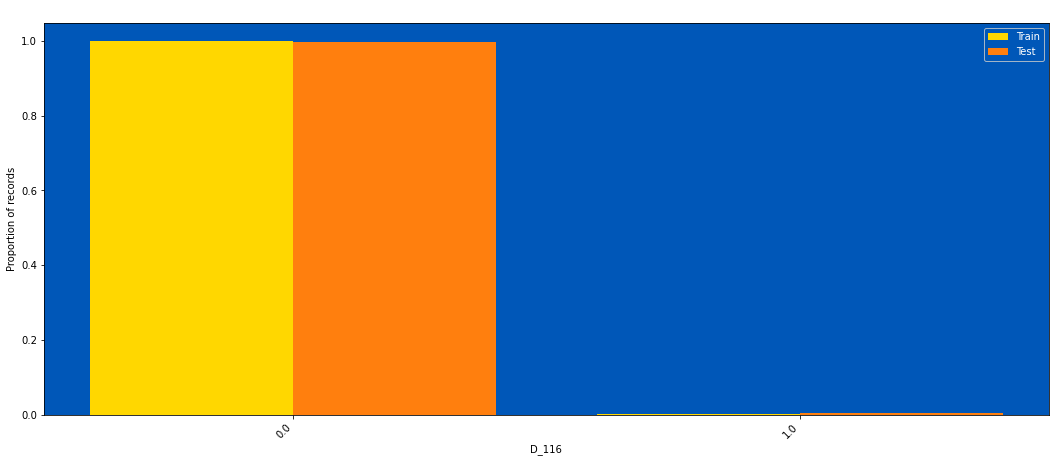

In [214]:
plot_train_test_distribution(train, test, "D_116", nunique_thr=5)

### D_117

176716 null count, 0.032 null proportion
0.4377 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


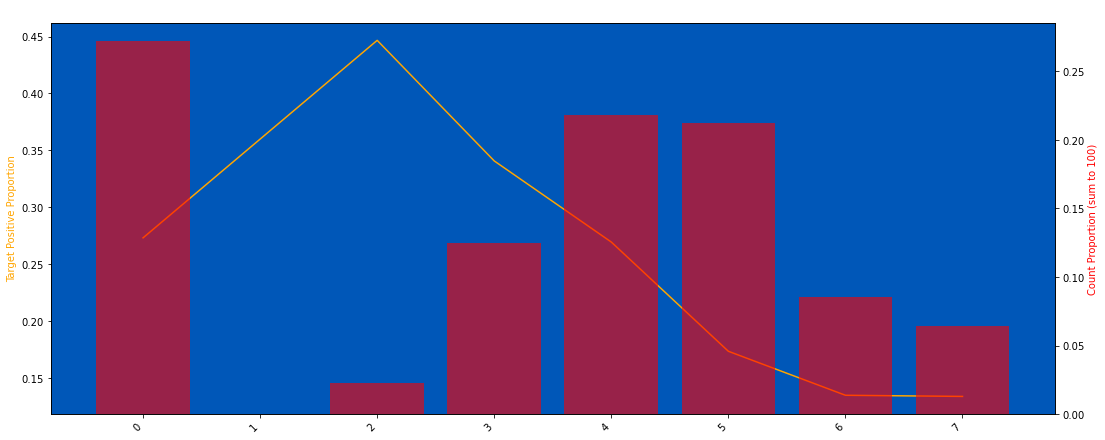

In [215]:
plot_target_check(train, "D_117", q=50, use_raw_bin=True)

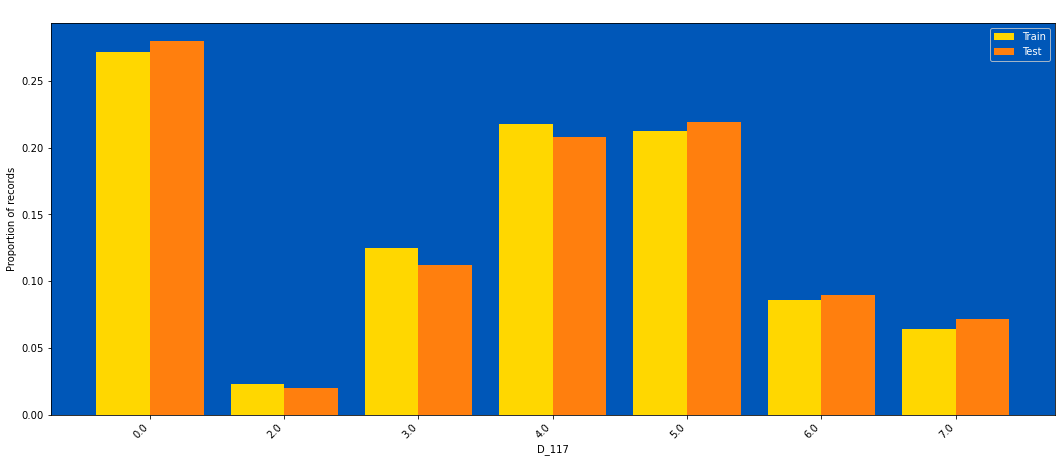

In [216]:
plot_train_test_distribution(train, test, "D_117", nunique_thr=20)

### D_118

176716 null count, 0.032 null proportion
0.4377 of the targets have label = 1


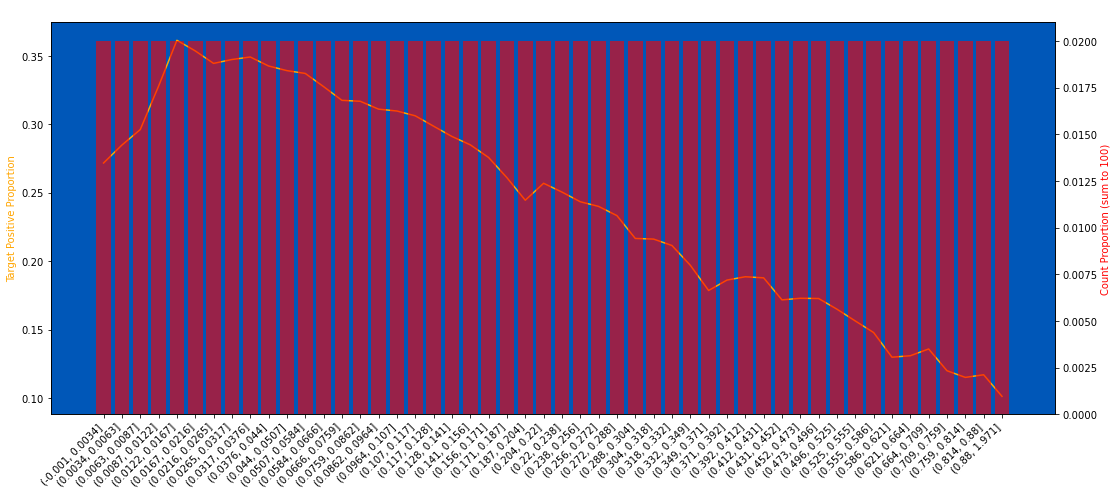

In [217]:
plot_target_check(train, "D_118", q=50, use_raw_bin=True)

In [218]:
train["D_118"] = train["D_118"].round(2)
test["D_118"] = test["D_118"].round(2)

176716 null count, 0.032 null proportion
0.4377 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


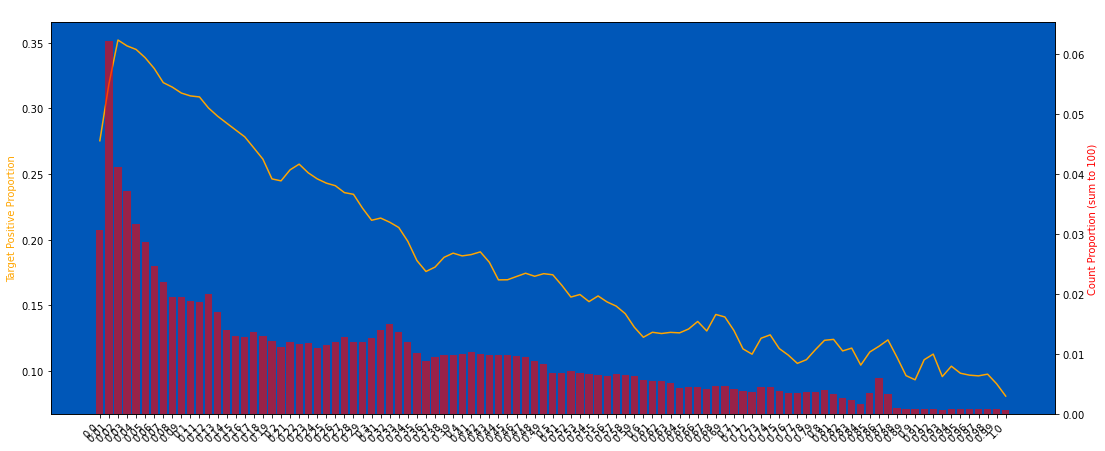

In [219]:
plot_target_check(train, "D_118", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True)

In [220]:
train.loc[train["D_118"].between(0, 0.01), "D_118"] = np.nan
test.loc[test["D_118"].between(0, 0.01), "D_118"] = np.nan

673925 null count, 0.122 null proportion
0.3392 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


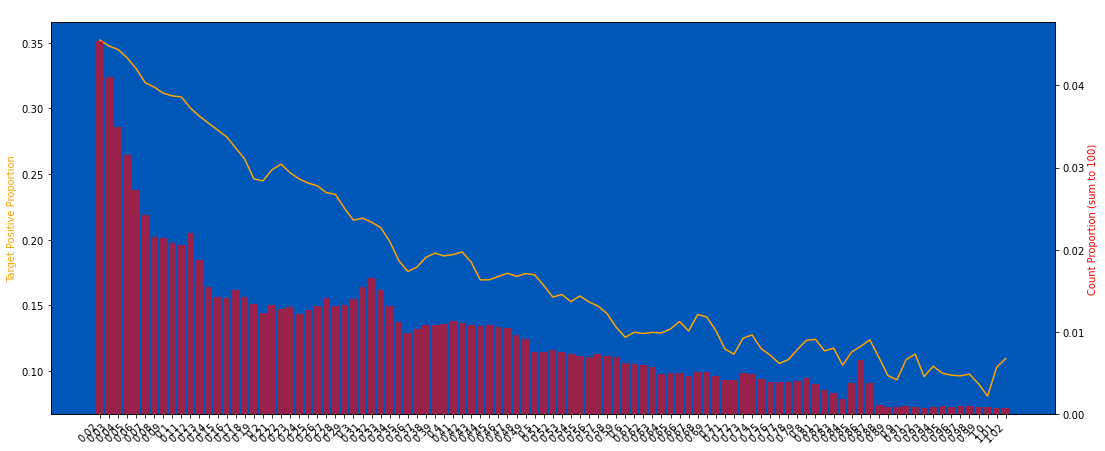

In [221]:
plot_target_check(train, "D_118", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


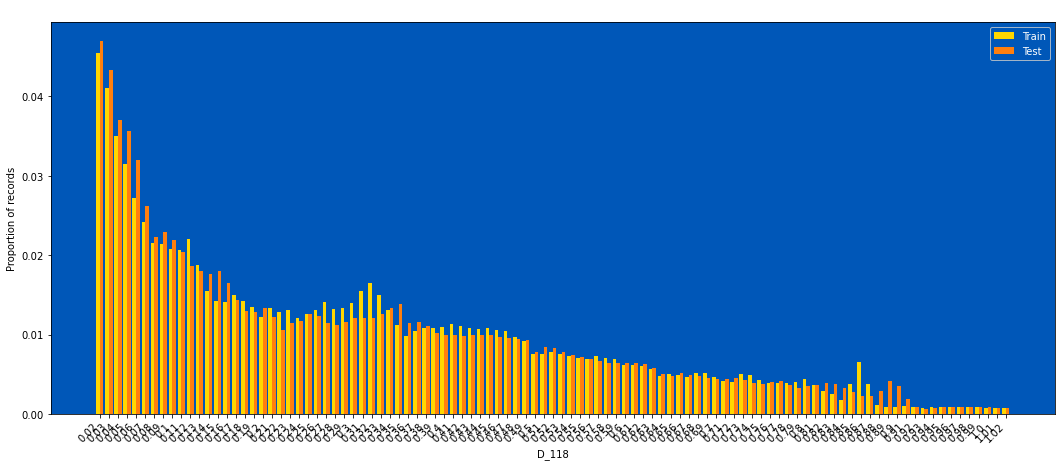

In [222]:
plot_train_test_distribution(train, test, "D_118", nunique_thr=500)

### D_119

176716 null count, 0.032 null proportion
0.4377 of the targets have label = 1


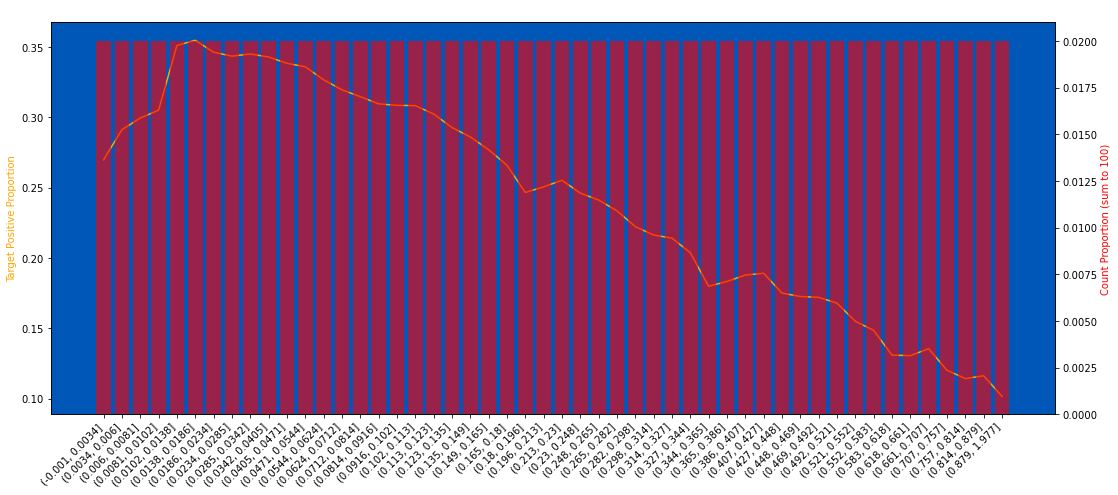

In [223]:
plot_target_check(train, "D_119", q=50, use_raw_bin=True)

In [224]:
train["D_119"] = train["D_119"].round(2)
test["D_119"] = test["D_119"].round(2)

In [225]:
train.loc[train["D_119"].between(0, 0.01), "D_119"] = np.nan
test.loc[test["D_119"].between(0, 0.01), "D_119"] = np.nan

739726 null count, 0.134 null proportion
0.3371 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


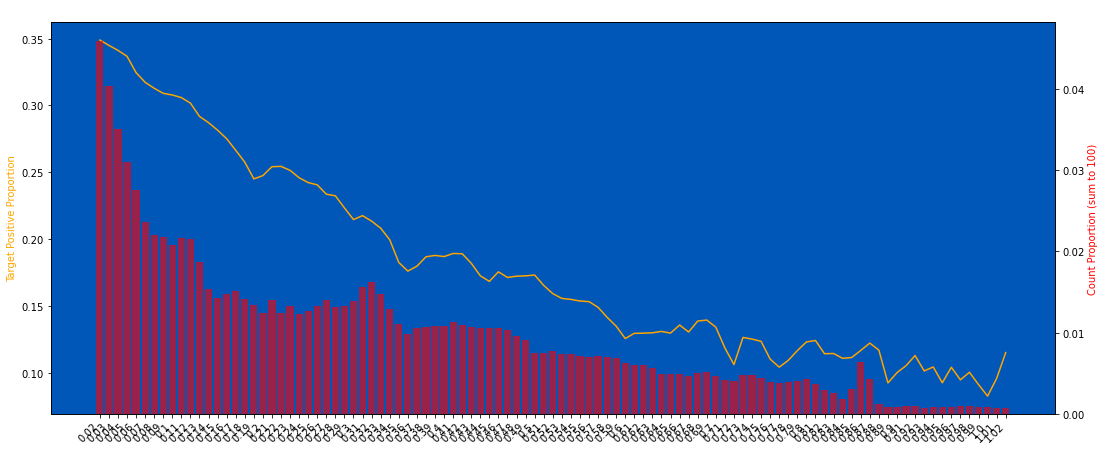

In [226]:
plot_target_check(train, "D_119", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


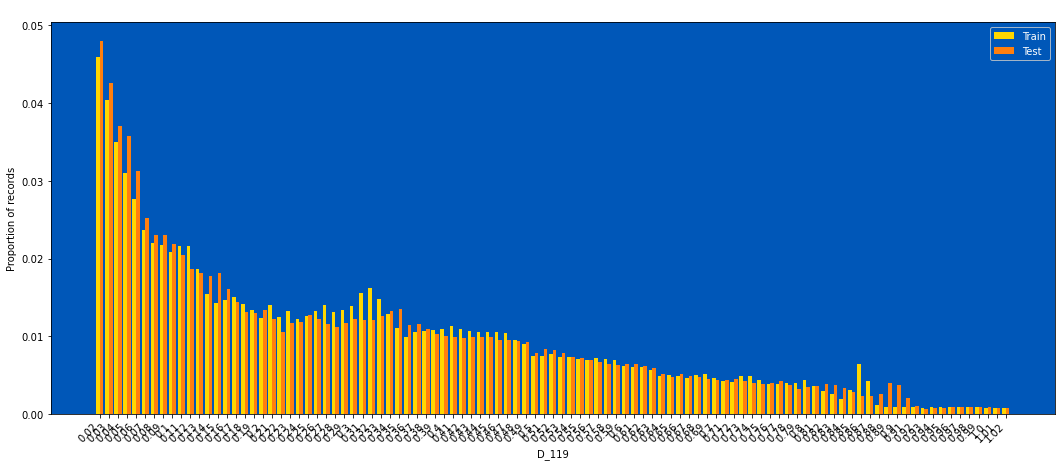

In [227]:
plot_train_test_distribution(train, test, "D_119", nunique_thr=500)

### D_120

176716 null count, 0.032 null proportion
0.4377 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


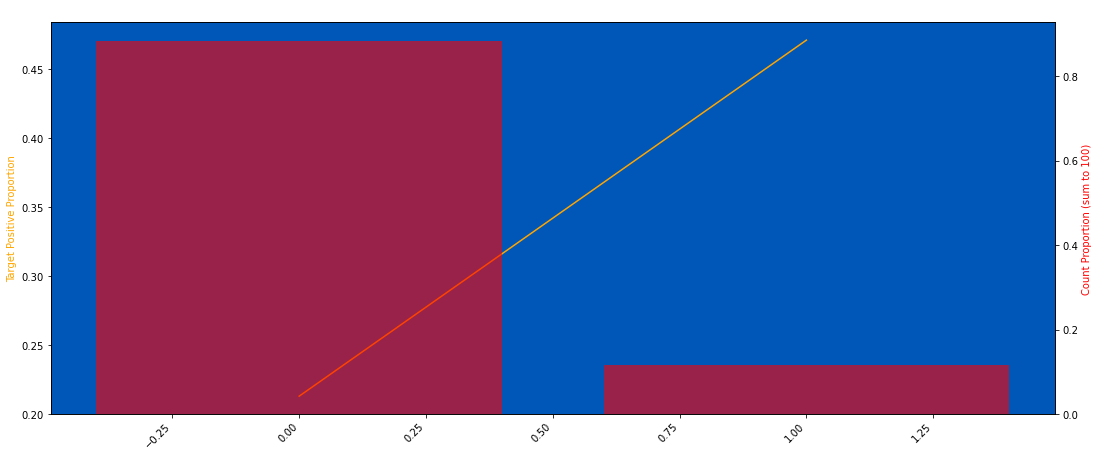

In [228]:
plot_target_check(train, "D_120", q=50, use_raw_bin=True)

Bottom 1% and Top 1% are dropped from this chart


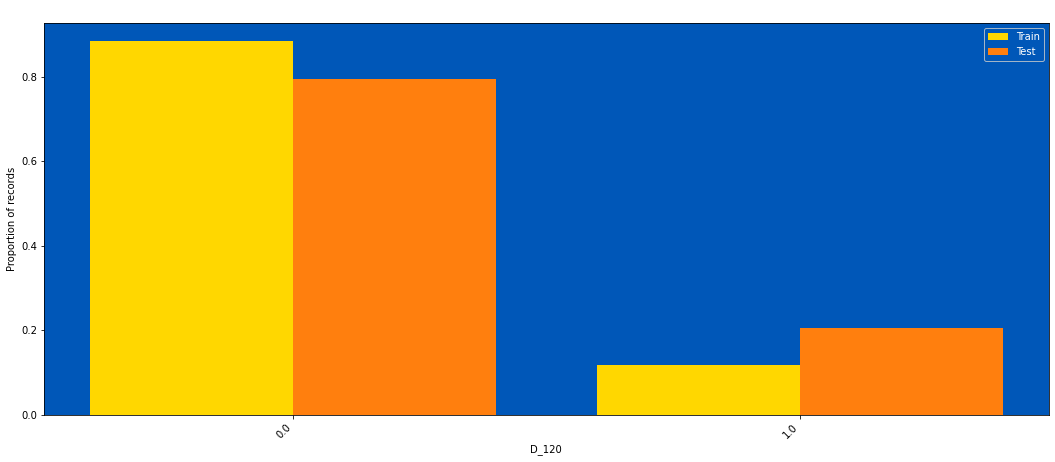

In [229]:
plot_train_test_distribution(train, test, "D_120", nunique_thr=500)

### D_121

176716 null count, 0.032 null proportion
0.4377 of the targets have label = 1


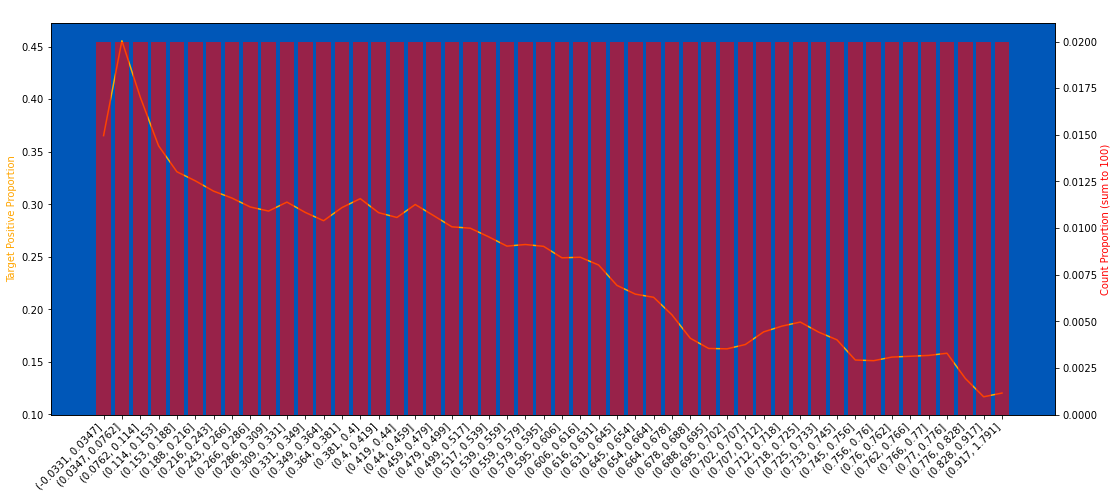

In [230]:
plot_target_check(train, "D_121", q=50, use_raw_bin=True)

In [231]:
train["D_121"] = train["D_121"].round(2)
test["D_121"] = test["D_121"].round(2)

In [232]:
train.loc[train["D_121"].between(0, 0.01), "D_121"] = np.nan
test.loc[test["D_121"].between(0, 0.01), "D_121"] = np.nan

203299 null count, 0.037 null proportion
0.4346 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


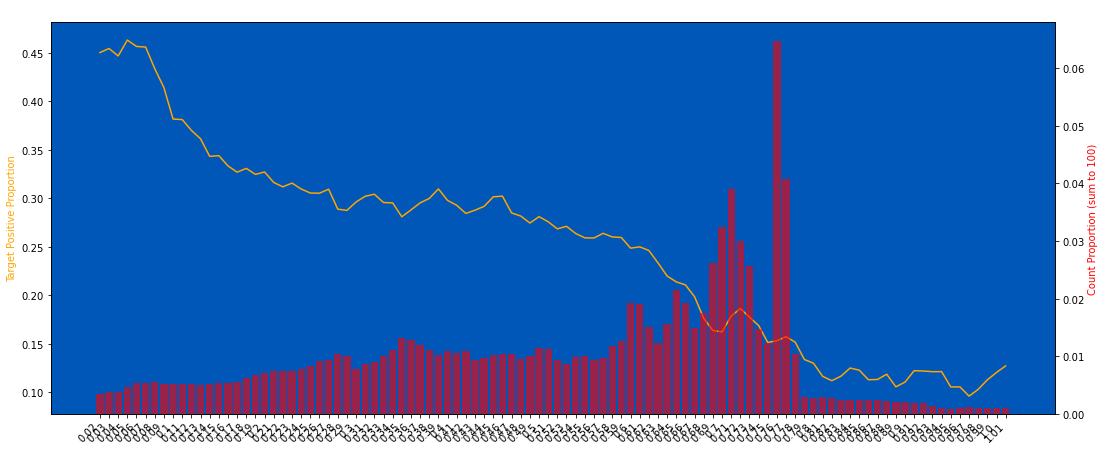

In [233]:
plot_target_check(train, "D_121", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


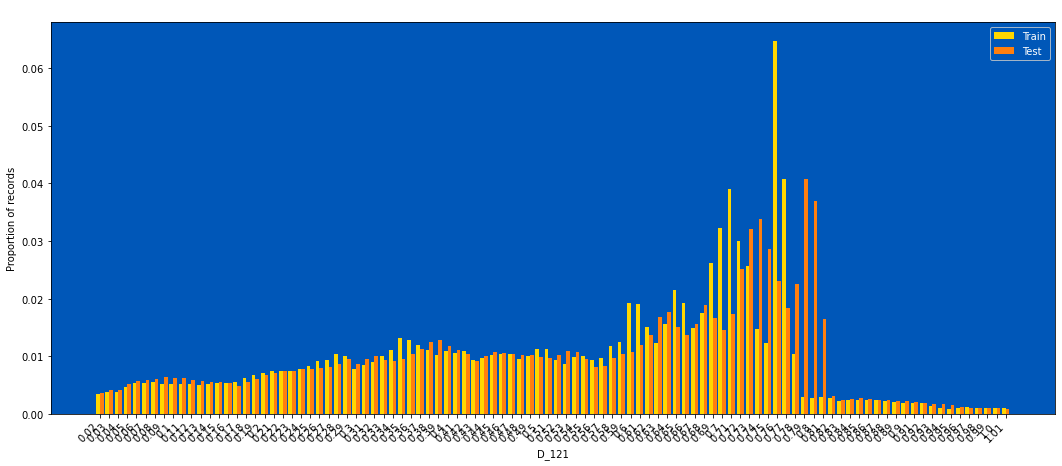

In [234]:
plot_train_test_distribution(train, test, "D_121", nunique_thr=500)

### D_122

176716 null count, 0.032 null proportion
0.4377 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


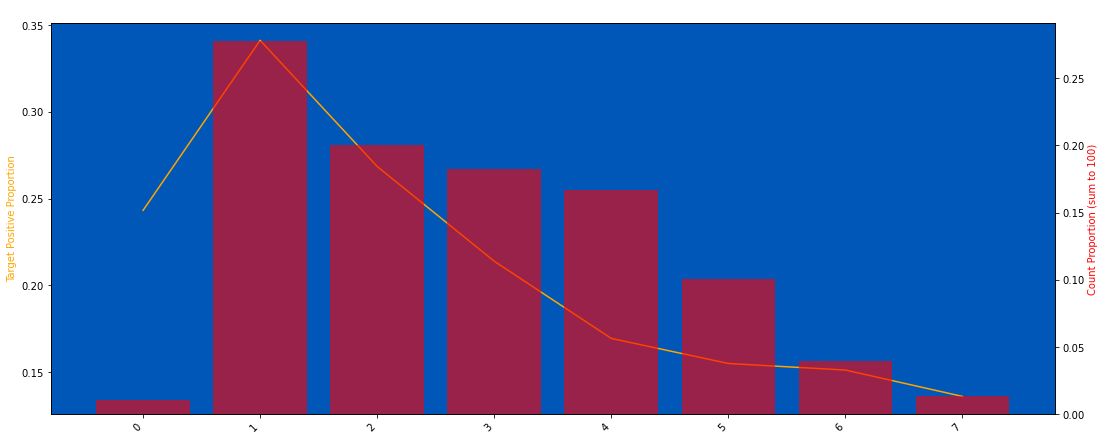

In [235]:
plot_target_check(train, "D_122", q=50, use_raw_bin=True, nunique_thr=100)

In [236]:
train.loc[train["D_122"] == 0, "D_122"] = np.nan
test.loc[test["D_122"] == 0, "D_122"] = np.nan

234965 null count, 0.042 null proportion
0.3895 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


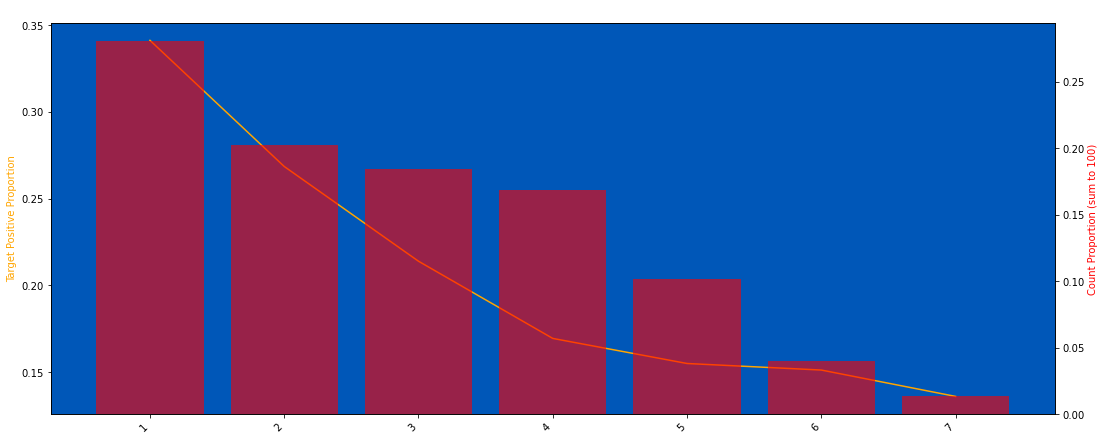

In [237]:
plot_target_check(train, "D_122", q=50, use_raw_bin=True)

Bottom 1% and Top 1% are dropped from this chart


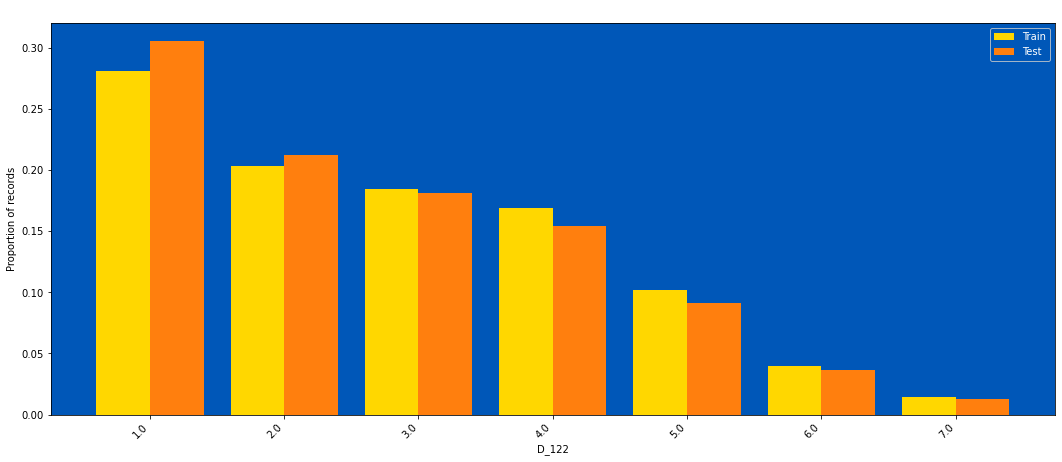

In [238]:
plot_train_test_distribution(train, test, "D_122", nunique_thr=500)

### D_123

176716 null count, 0.032 null proportion
0.4377 of the targets have label = 1


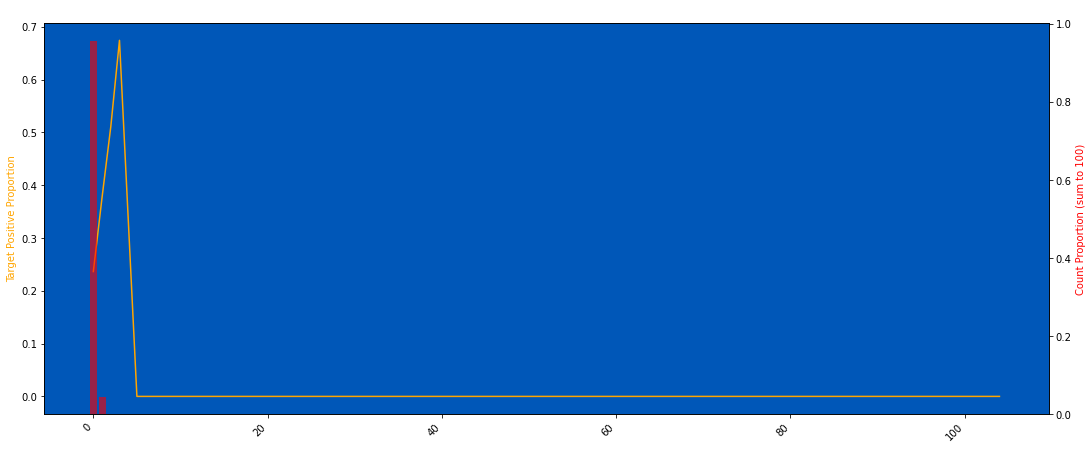

In [239]:
plot_target_check(train, "D_123", q=50, use_raw_bin=True, nunique_thr=50)

Bottom 1% and Top 1% are dropped from this chart


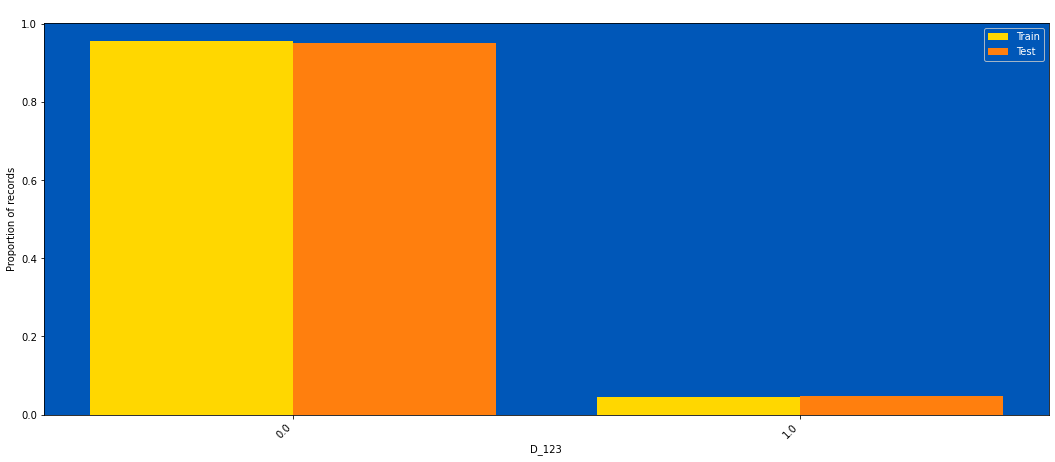

In [240]:
plot_train_test_distribution(train, test, "D_123", nunique_thr=500)

### D_124

176716 null count, 0.032 null proportion
0.4377 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


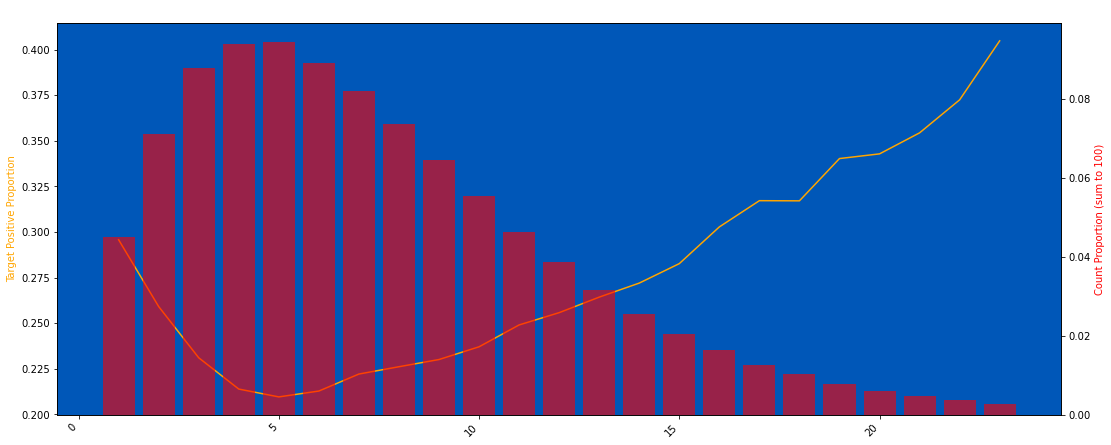

In [241]:
d124_summary = plot_target_check(train, "D_124", q=50, use_raw_bin=True, return_df=True)

Bottom 1% and Top 1% are dropped from this chart


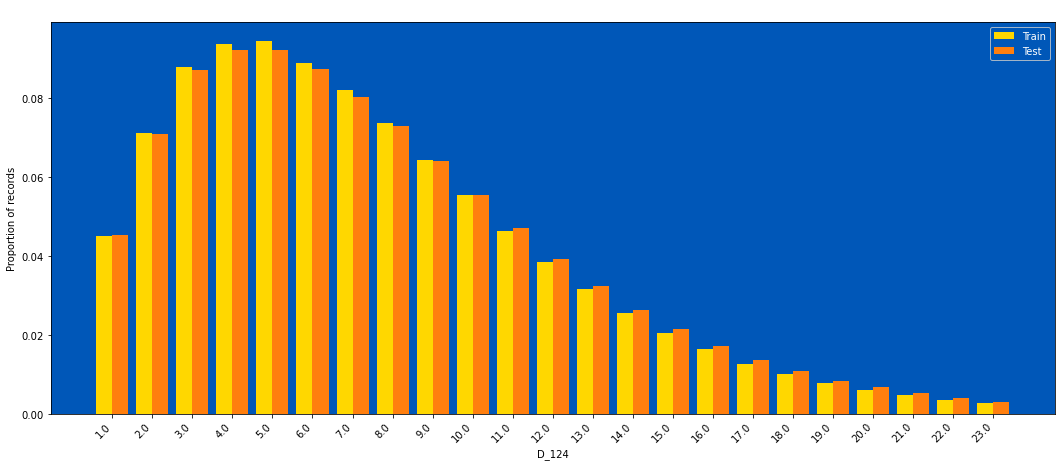

In [242]:
plot_train_test_distribution(train, test, "D_124", nunique_thr=500)

### D_124a

In [243]:
d124_summary.loc[d124_summary["D_124"] == d124_summary["D_124"].nlargest(1).values[-1]]

D_124  target_mean  count_distribution  proportion_distribution
23 23.0000       0.4048               14443                   0.0027

In [244]:
d124_summary.loc[d124_summary["D_124"] == d124_summary["D_124"].nsmallest(1).values[-1]]

D_124  target_mean  count_distribution  proportion_distribution
1 1.0000       0.2957              241571                   0.0451

In [245]:
d124_summary.loc[d124_summary["target_mean"] == d124_summary["target_mean"].min()]

D_124  target_mean  count_distribution  proportion_distribution
5 5.0000       0.2096              506212                   0.0945

In [246]:
left_grad = (0.2096 - 0.2957) / (1 - 5)
right_grad = (0.4048 - 0.2096) / (23 - 5)

In [247]:
train["D_124a"] = (train["D_124"] - 5).apply(lambda x: right_grad * x if x >= 0 else -left_grad * x) * 10
test["D_124a"] = (test["D_124"] - 5).apply(lambda x: right_grad * x if x >= 0 else -left_grad * x) * 10

176716 null count, 0.032 null proportion
0.4377 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


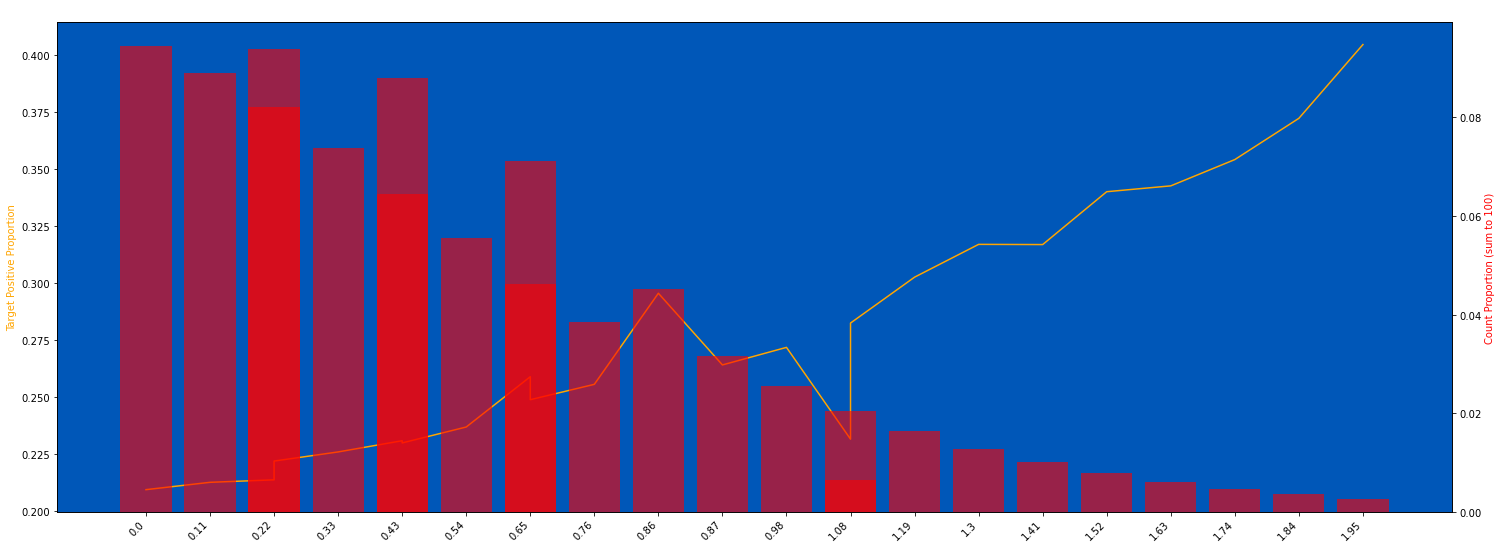

In [248]:
plot_target_check(train, "D_124a", q=50, use_raw_bin=True, nunique_thr=200, strfy_x=True, figsize=(25, 10))

Bottom 1% and Top 1% are dropped from this chart


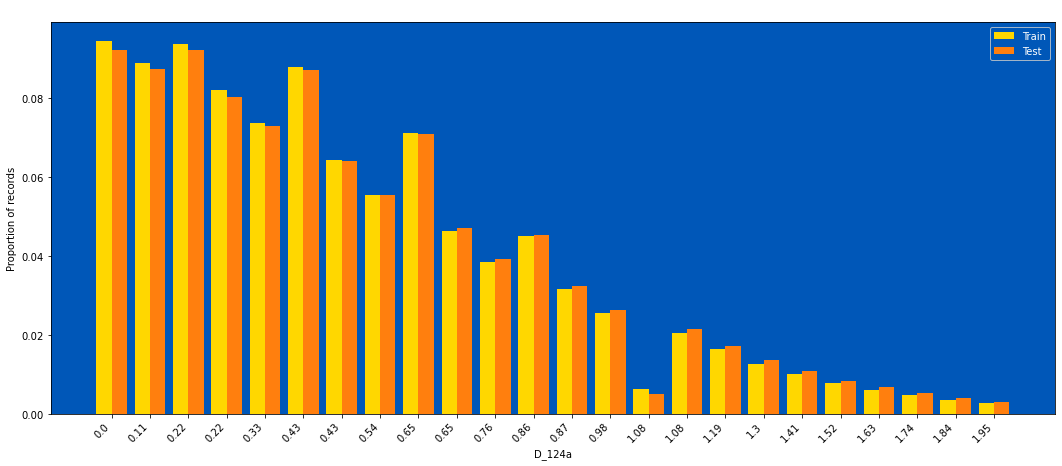

In [249]:
plot_train_test_distribution(train, test, "D_124a", nunique_thr=500)

### D_125

176716 null count, 0.032 null proportion
0.4377 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


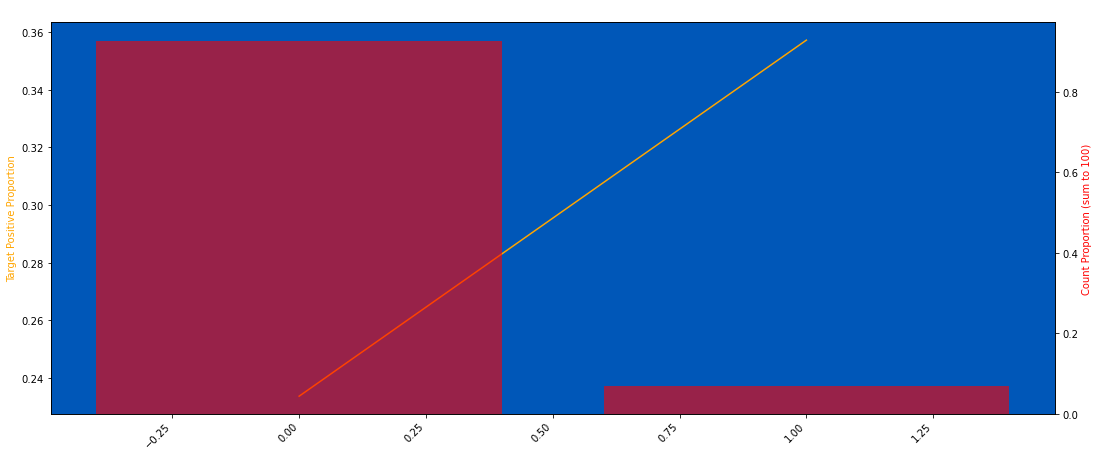

In [250]:
plot_target_check(train, "D_125", q=50, use_raw_bin=True)

Bottom 1% and Top 1% are dropped from this chart


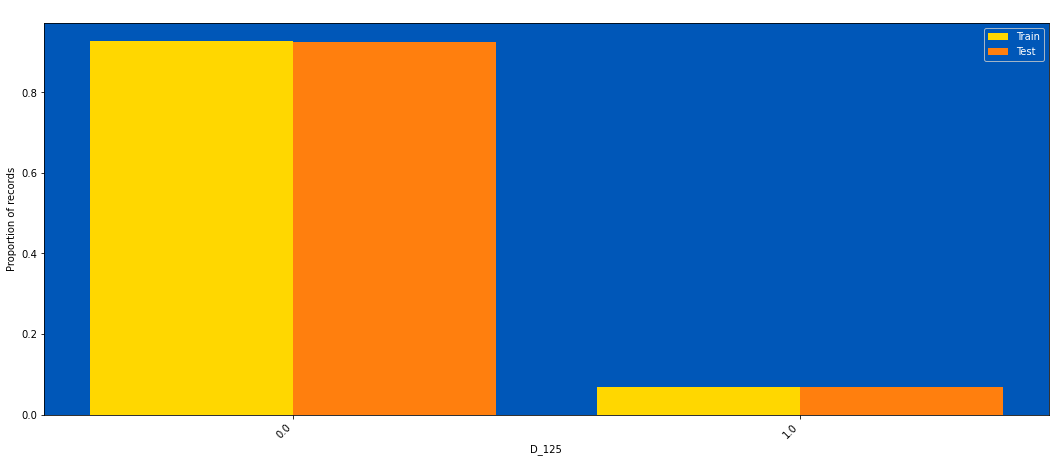

In [251]:
plot_train_test_distribution(train, test, "D_125", nunique_thr=500)

### D_126

116816 null count, 0.021 null proportion
0.4680 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


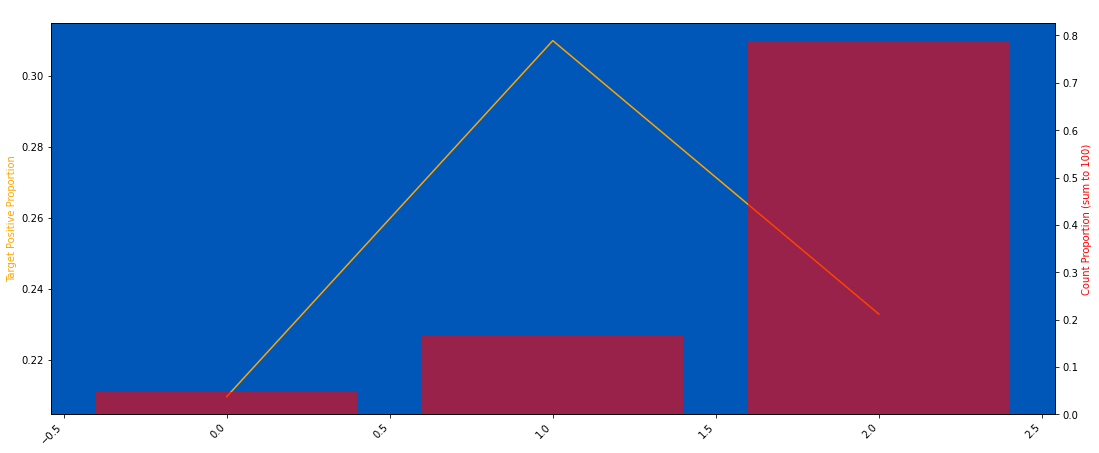

In [252]:
plot_target_check(train, "D_126", q=50, use_raw_bin=True)

Bottom 1% and Top 1% are dropped from this chart


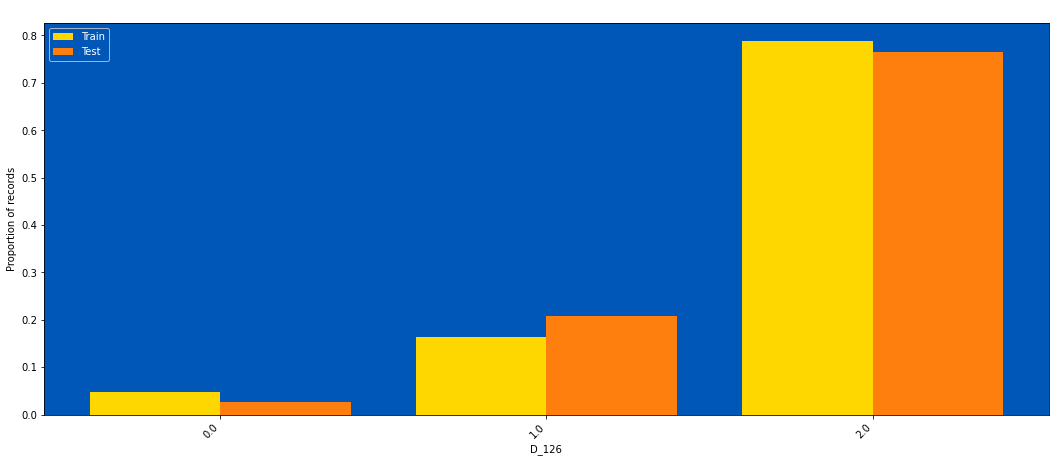

In [253]:
plot_train_test_distribution(train, test, "D_126", nunique_thr=500)

### D_127

0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


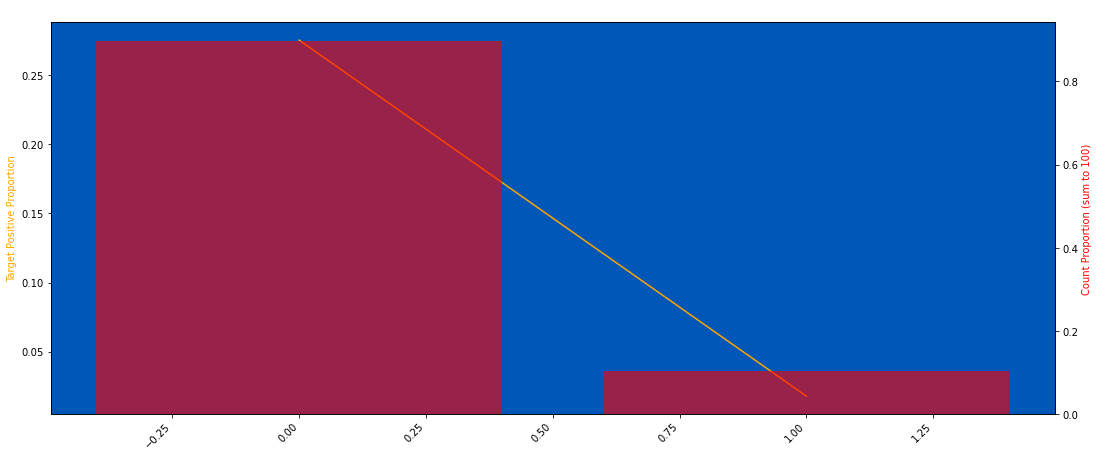

In [254]:
plot_target_check(train, "D_127", q=50, use_raw_bin=True)

Bottom 1% and Top 1% are dropped from this chart


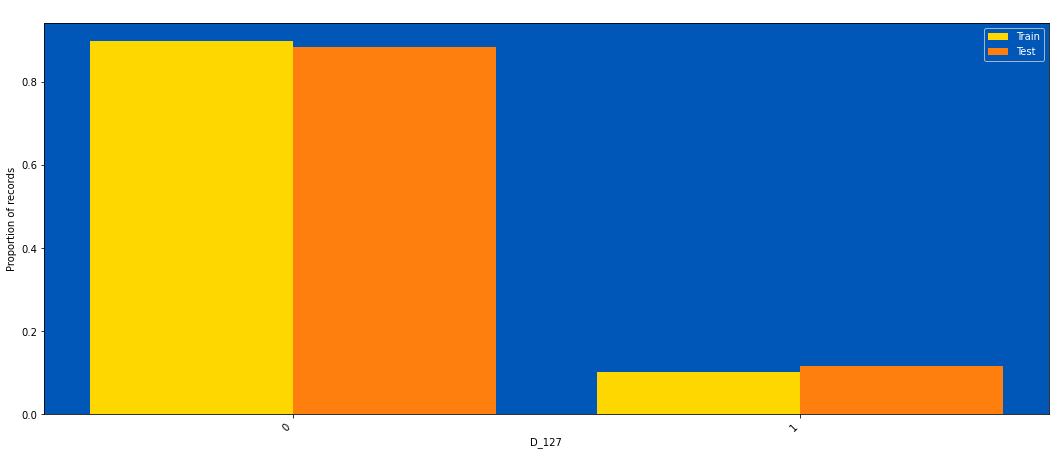

In [255]:
plot_train_test_distribution(train, test, "D_127", nunique_thr=500)

### D_128

101548 null count, 0.018 null proportion
0.3576 of the targets have label = 1


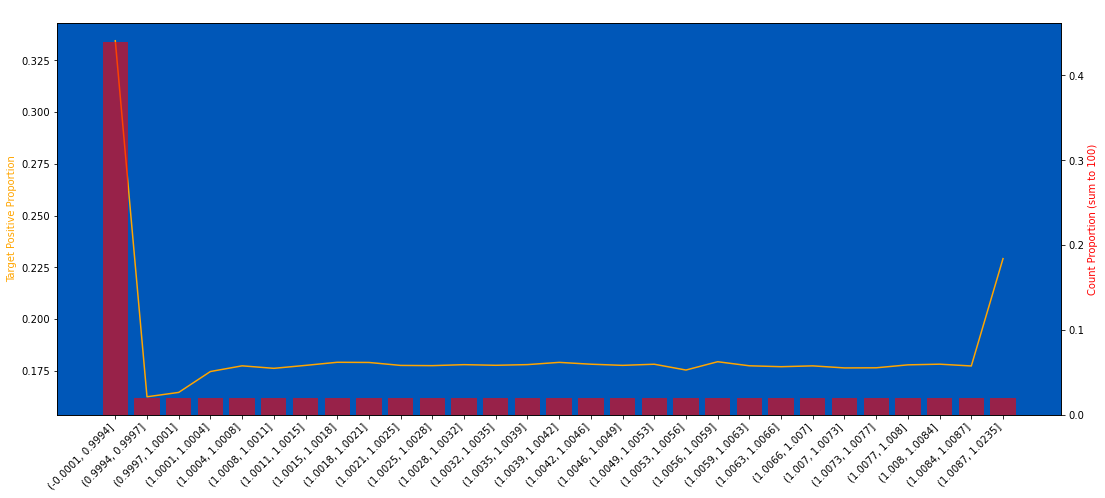

In [256]:
plot_target_check(train, "D_128", q=50, use_raw_bin=True)

In [257]:
train["D_128"] = train["D_128"].round(2)
test["D_128"] = test["D_128"].round(2)

In [258]:
train.loc[train["D_128"].between(1, 1.01), "D_128"] = 1
test.loc[test["D_128"].between(1, 1.01), "D_128"] = 1

101548 null count, 0.018 null proportion
0.3576 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


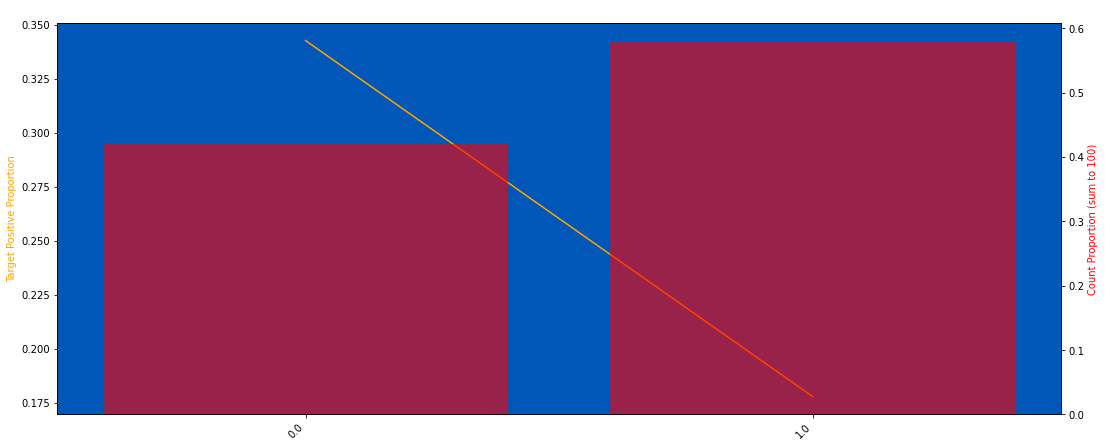

In [259]:
plot_target_check(train, "D_128", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


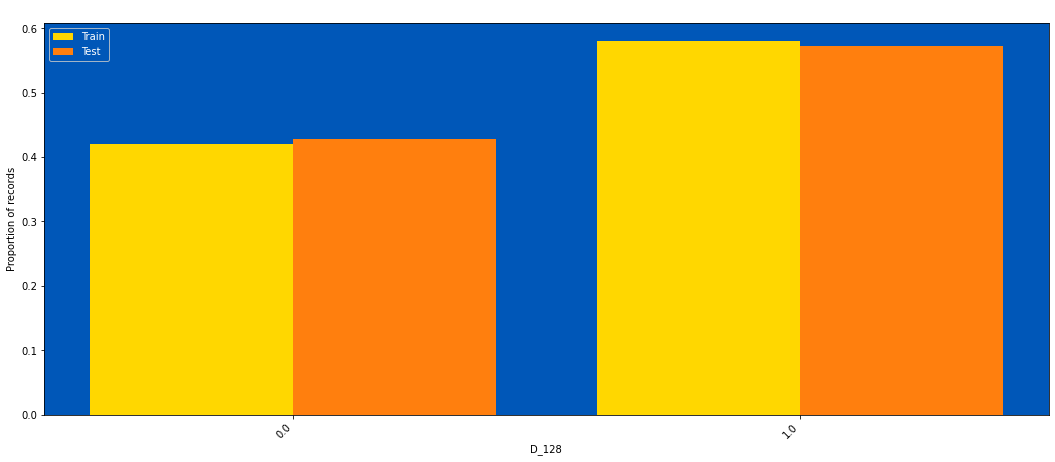

In [260]:
plot_train_test_distribution(train, test, "D_128", nunique_thr=500)

### D_129

101548 null count, 0.018 null proportion
0.3576 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


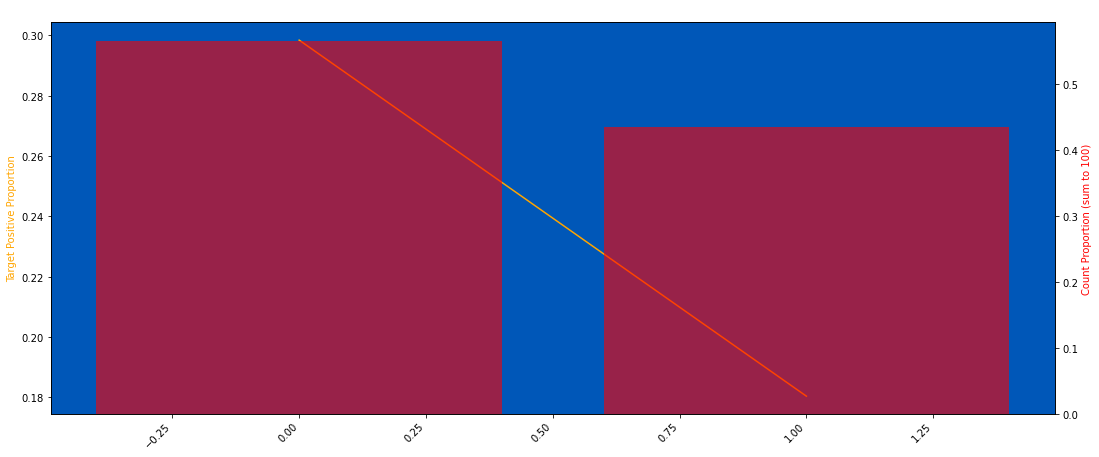

In [261]:
plot_target_check(train, "D_129", q=50, use_raw_bin=True)

Bottom 1% and Top 1% are dropped from this chart


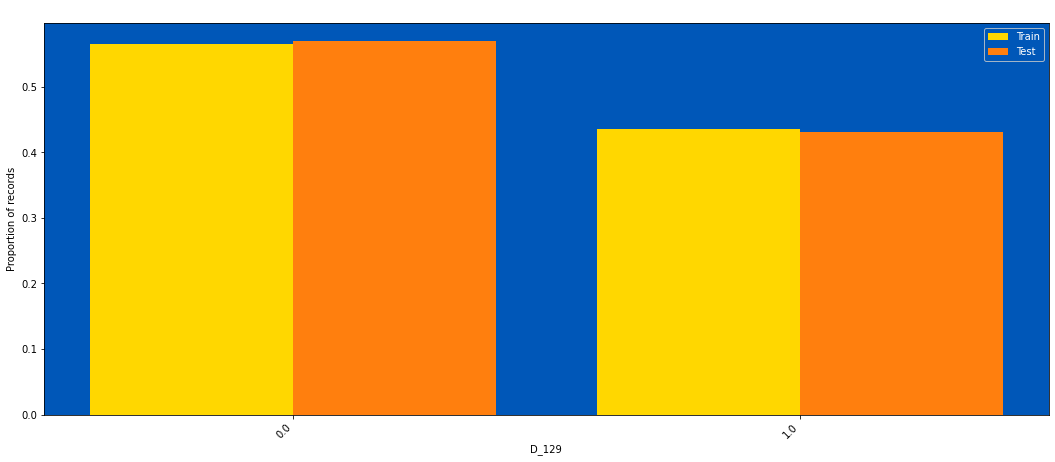

In [262]:
plot_train_test_distribution(train, test, "D_129", nunique_thr=500)

### D_130

101548 null count, 0.018 null proportion
0.3576 of the targets have label = 1


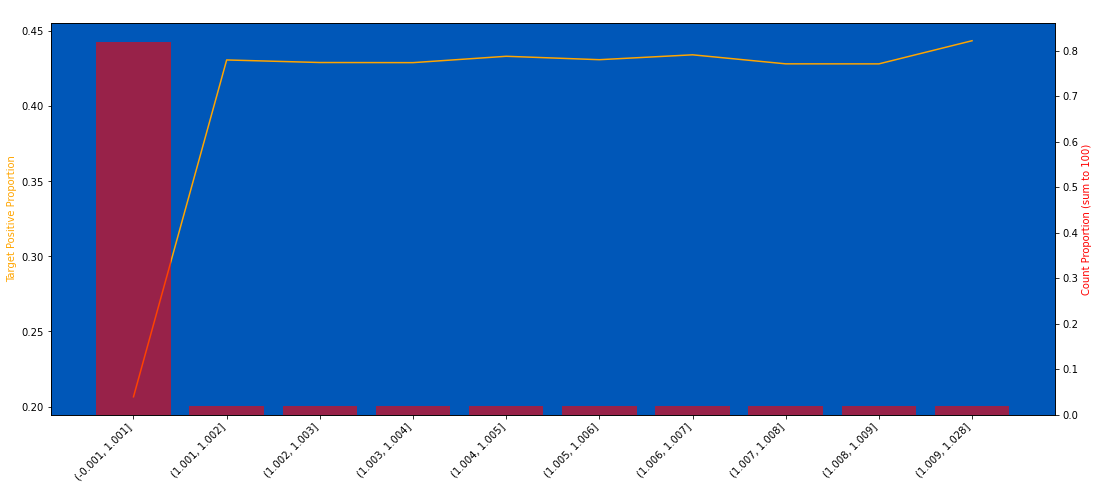

In [263]:
plot_target_check(train, "D_130", q=50, use_raw_bin=True)

In [264]:
train["D_130"] = train["D_130"].round(2)
test["D_130"] = test["D_130"].round(2)

In [265]:
train.loc[train["D_130"].between(1, 1.01), "D_130"] = 1
test.loc[test["D_130"].between(1, 1.01), "D_130"] = 1

101548 null count, 0.018 null proportion
0.3576 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


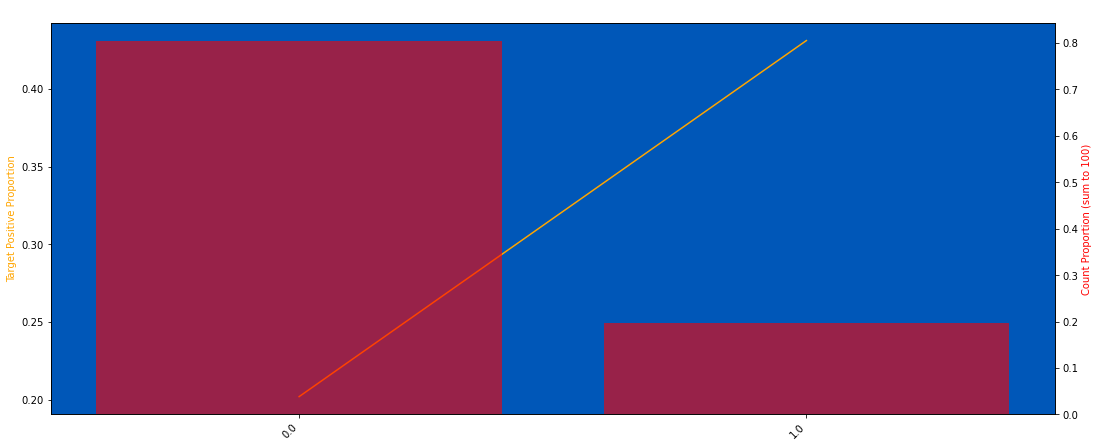

In [266]:
plot_target_check(train, "D_130", q=50, use_raw_bin=True, nunique_thr=100, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


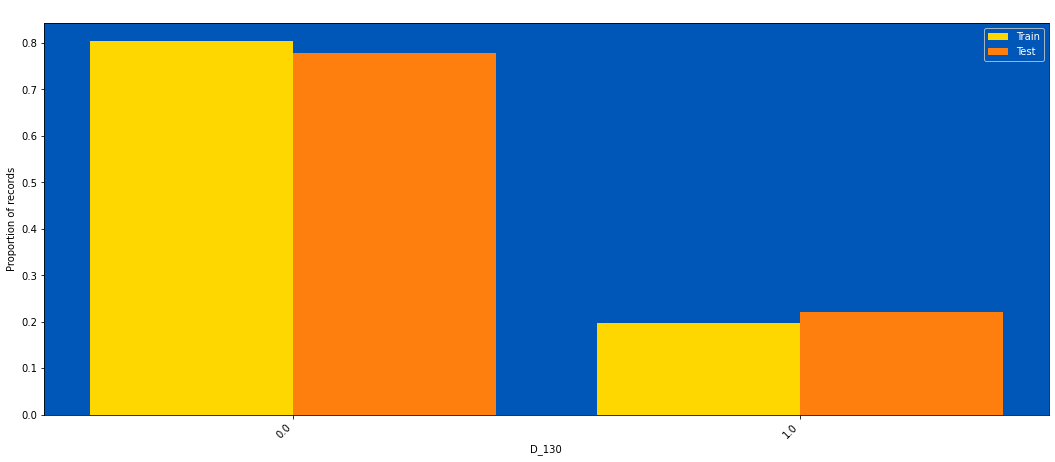

In [267]:
plot_train_test_distribution(train, test, "D_130", nunique_thr=500)

### D_131

101548 null count, 0.018 null proportion
0.3576 of the targets have label = 1


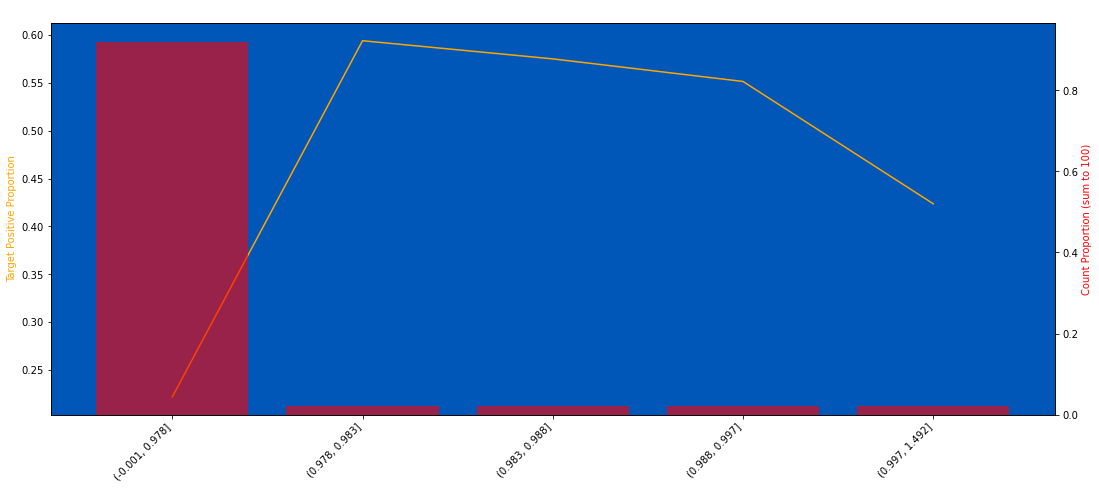

In [268]:
plot_target_check(train, "D_131", q=50, use_raw_bin=True)

In [269]:
train["D_131"] = train["D_131"].round(2)
test["D_131"] = test["D_131"].round(2)

In [270]:
train.loc[train["D_131"] == 0, "D_131"] = np.nan
test.loc[test["D_131"] == 0, "D_131"] = np.nan

4988868 null count, 0.902 null proportion
0.2164 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


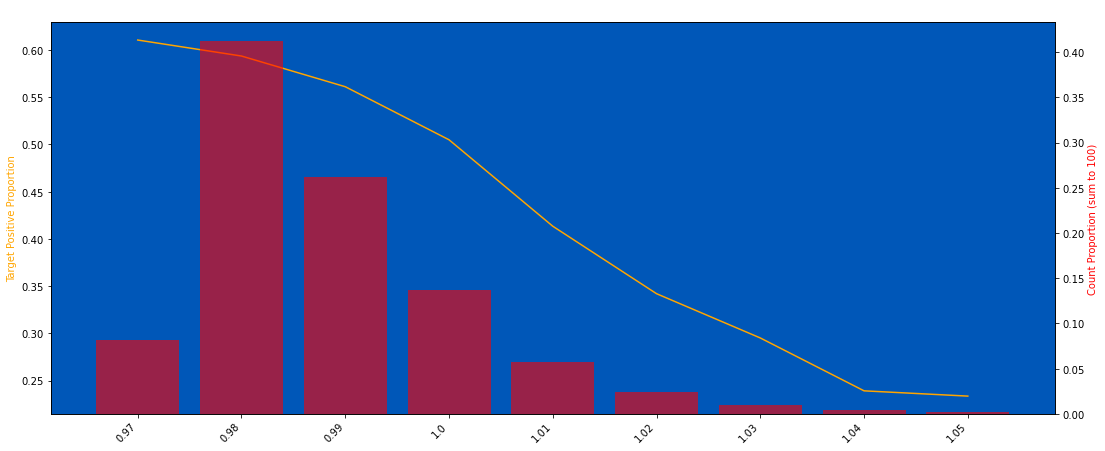

In [271]:
plot_target_check(train, "D_131", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


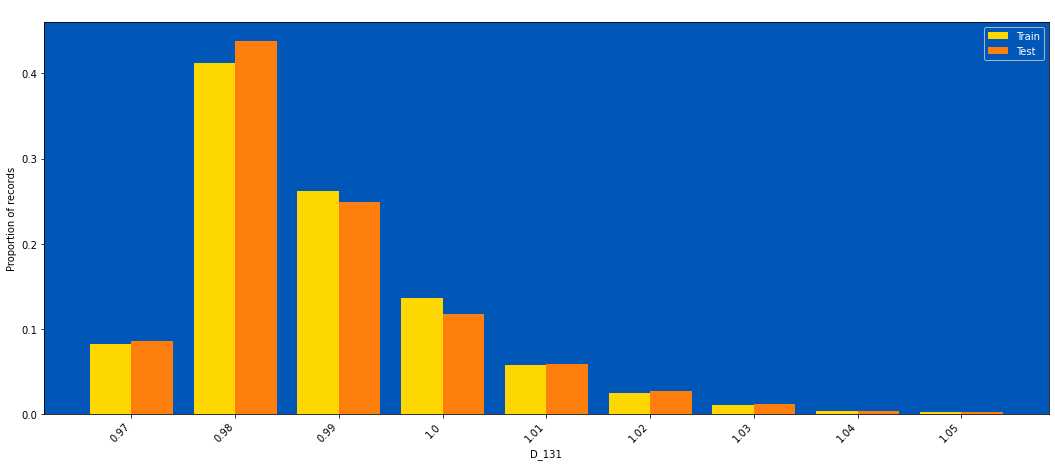

In [272]:
plot_train_test_distribution(train, test, "D_131", nunique_thr=500)

### D_132

4988874 null count, 0.902 null proportion
0.2164 of the targets have label = 1


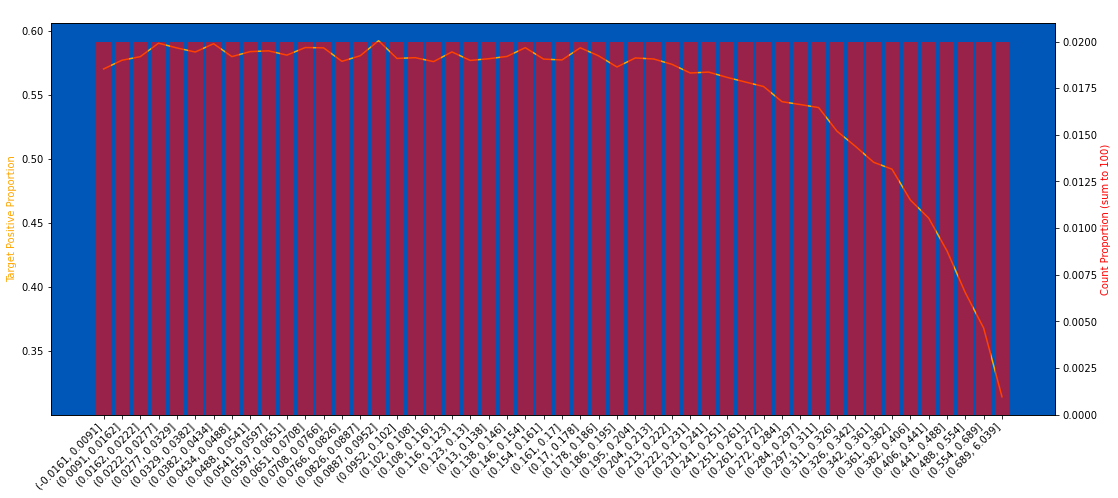

In [273]:
plot_target_check(train, "D_132", q=50, use_raw_bin=True)

In [274]:
train["D_132"] = train["D_132"].round(2)
test["D_132"] = test["D_132"].round(2)

4988874 null count, 0.902 null proportion
0.2164 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


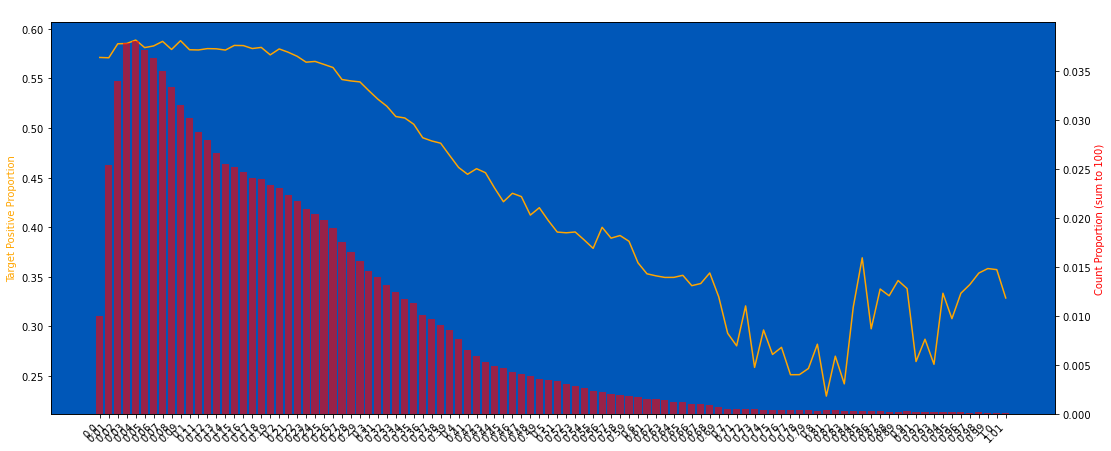

In [275]:
plot_target_check(train, "D_132", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


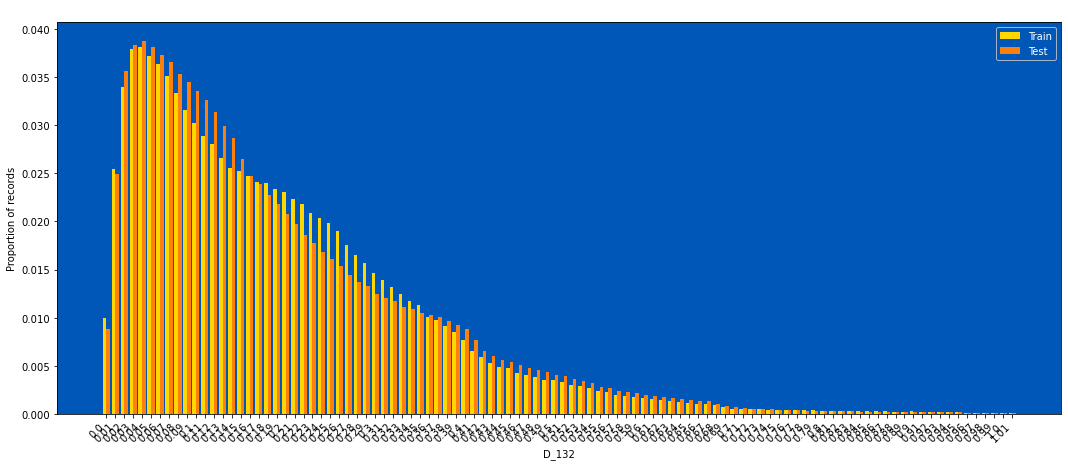

In [276]:
plot_train_test_distribution(train, test, "D_132", nunique_thr=5000)

### D_133

42716 null count, 0.008 null proportion
0.4210 of the targets have label = 1


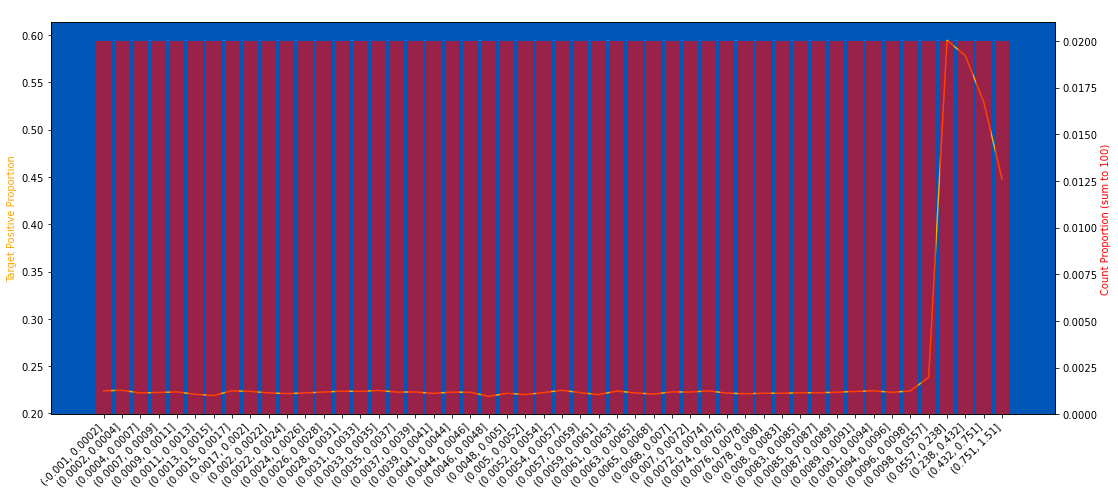

In [277]:
plot_target_check(train, "D_133", q=50, use_raw_bin=True)

In [278]:
train["D_133"] = train["D_133"].round(2)
test["D_133"] = test["D_133"].round(2)

In [279]:
train.loc[train["D_133"].between(0, 0.01), "D_133"] = np.nan
test.loc[test["D_133"].between(0, 0.01), "D_133"] = np.nan

5086308 null count, 0.920 null proportion
0.2239 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


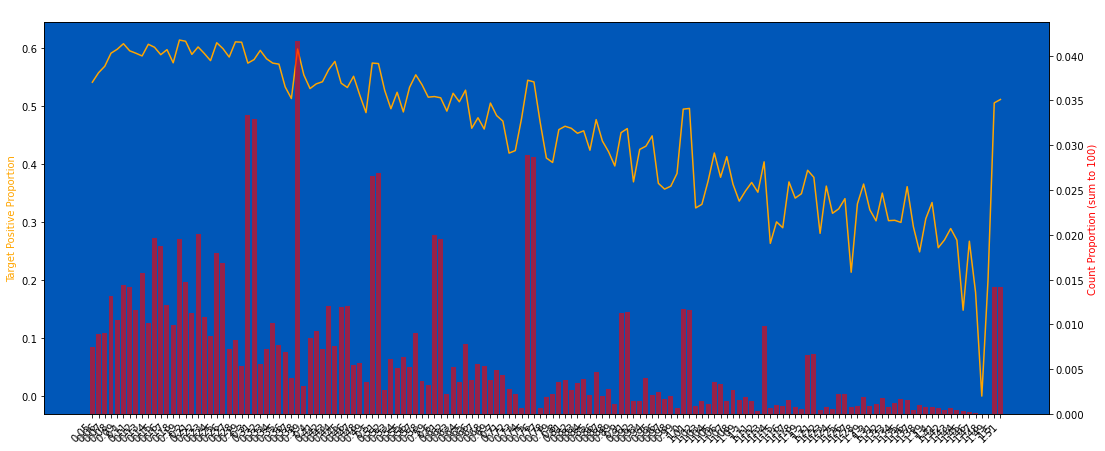

In [280]:
plot_target_check(train, "D_133", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


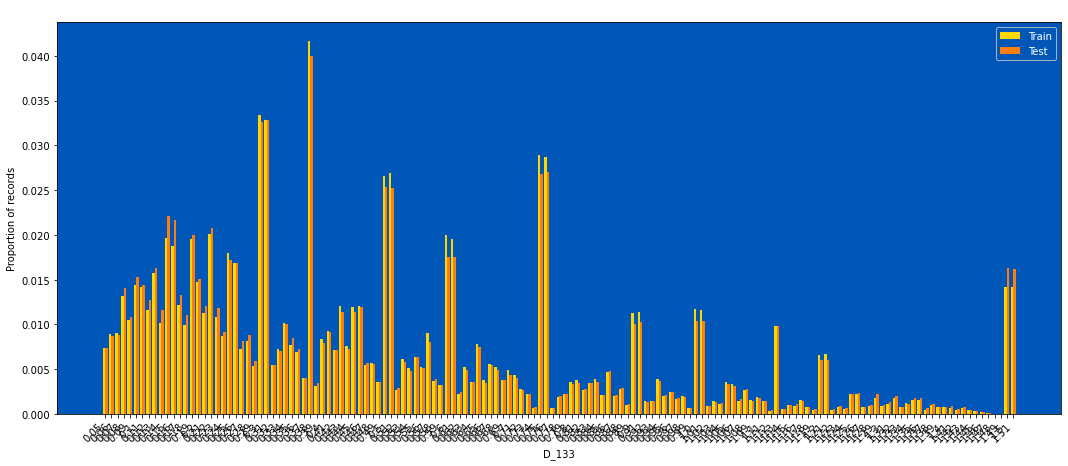

In [281]:
plot_train_test_distribution(train, test, "D_133", nunique_thr=5000)

### D_134

5336752 null count, 0.965 null proportion
0.2360 of the targets have label = 1


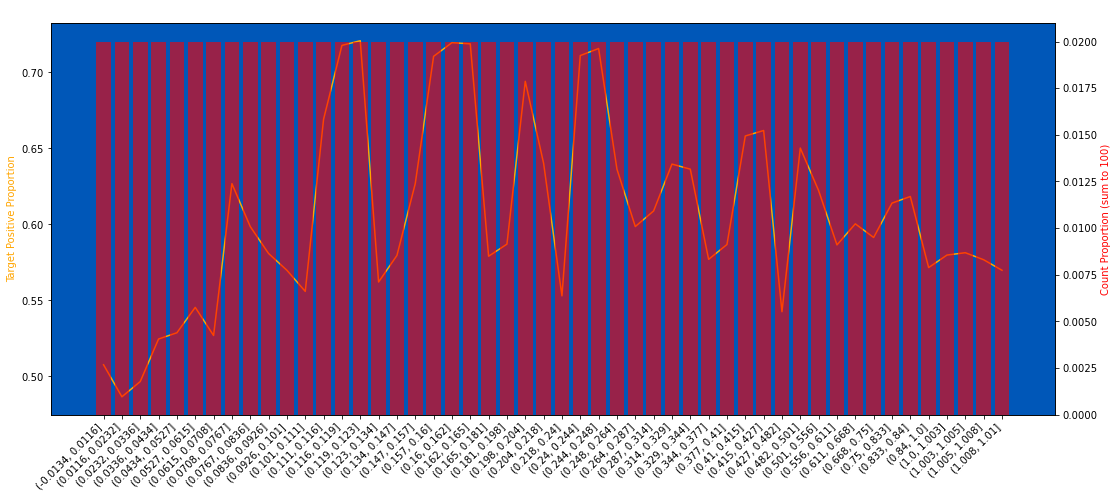

In [282]:
plot_target_check(train, "D_134", q=50, use_raw_bin=True)

In [283]:
train["D_134"] = train["D_134"].round(2)
test["D_134"] = test["D_134"].round(2)

In [284]:
train.loc[train["D_134"].between(1, 1.01), "D_134"] = 1
test.loc[test["D_134"].between(1, 1.01), "D_134"] = 1

5336752 null count, 0.965 null proportion
0.2360 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


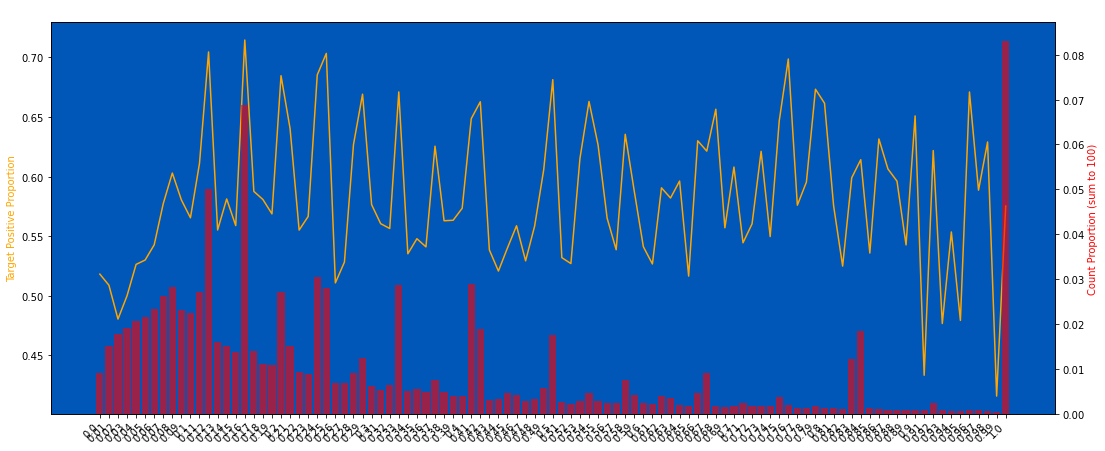

In [285]:
plot_target_check(train, "D_134", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


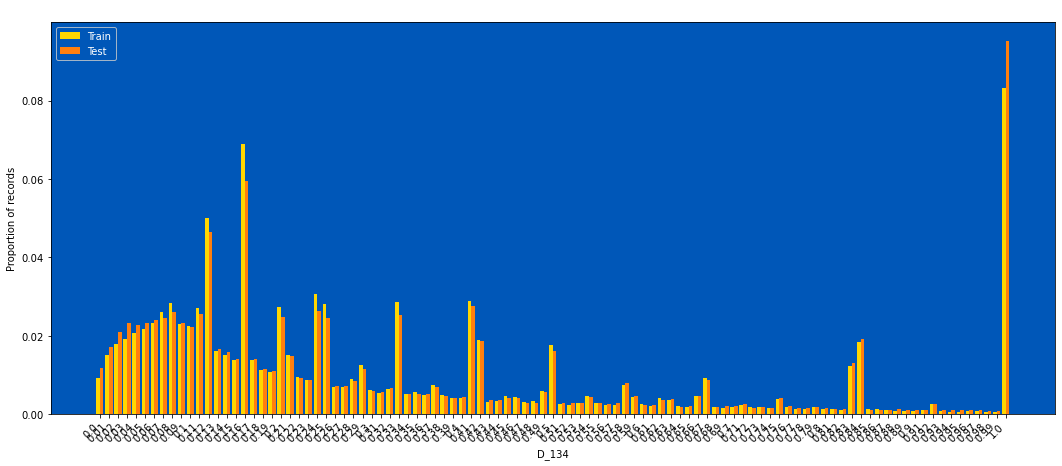

In [286]:
plot_train_test_distribution(train, test, "D_134", nunique_thr=5000)

### D_135

5336752 null count, 0.965 null proportion
0.2360 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


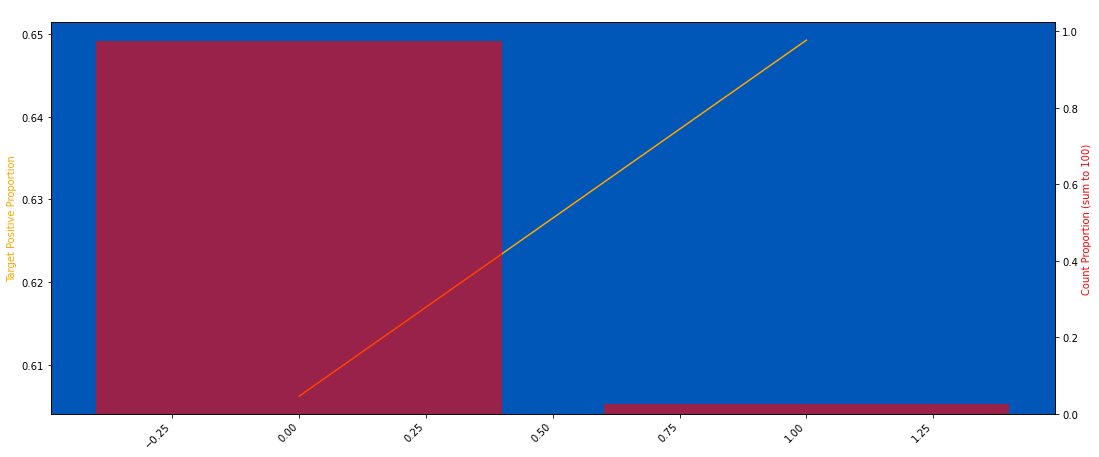

In [287]:
plot_target_check(train, "D_135", q=50, use_raw_bin=True)

Bottom 1% and Top 1% are dropped from this chart


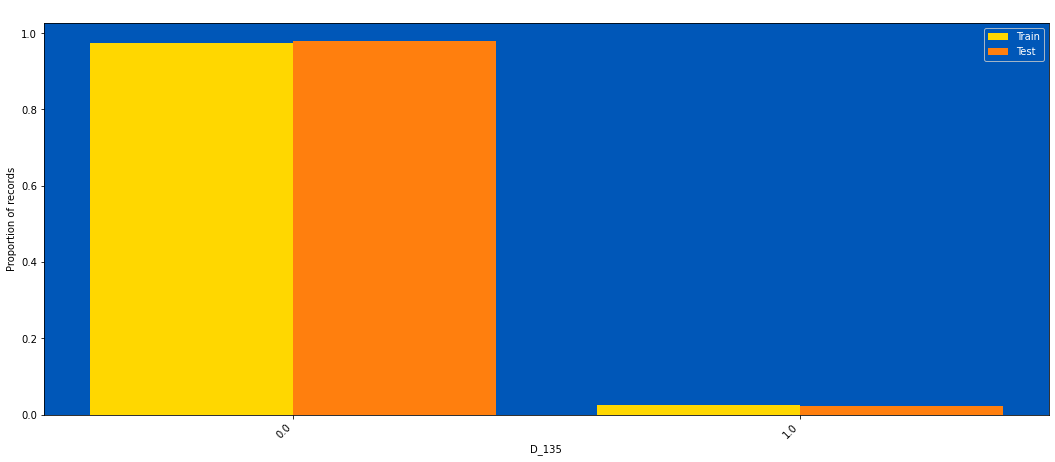

In [288]:
plot_train_test_distribution(train, test, "D_135", nunique_thr=5000)

### D_136

5336752 null count, 0.965 null proportion
0.2360 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


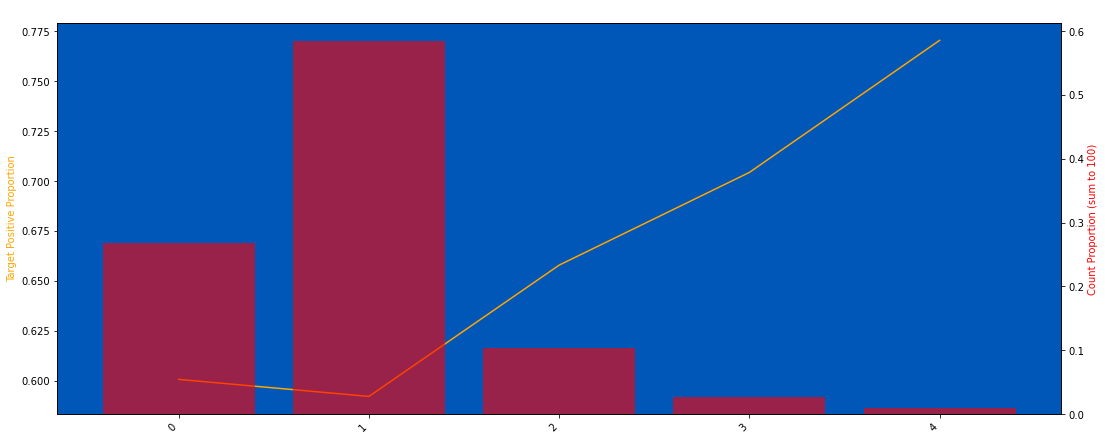

In [289]:
plot_target_check(train, "D_136", q=50, use_raw_bin=True)

Bottom 1% and Top 1% are dropped from this chart


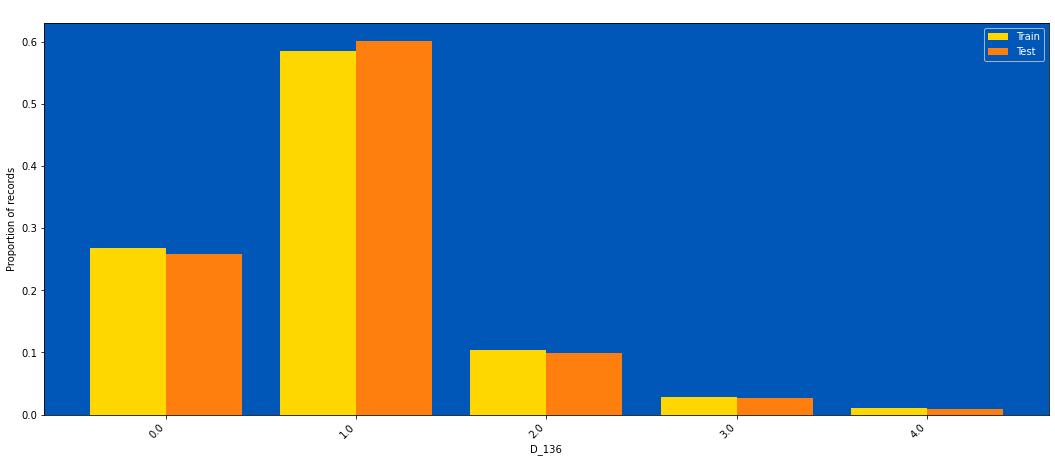

In [290]:
plot_train_test_distribution(train, test, "D_136", nunique_thr=5000)

### D_137

5336752 null count, 0.965 null proportion
0.2360 of the targets have label = 1


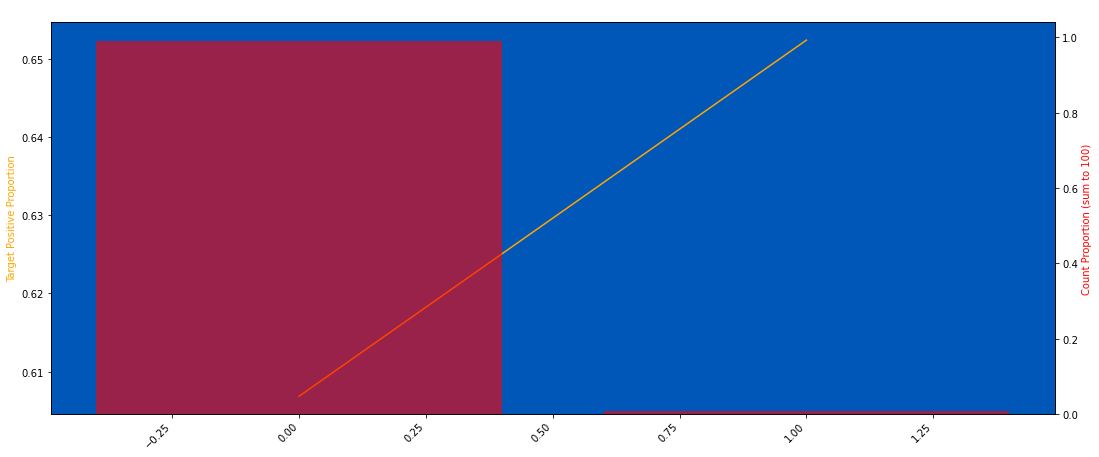

In [291]:
plot_target_check(train, "D_137", q=50, use_raw_bin=True, nunique_thr=10)

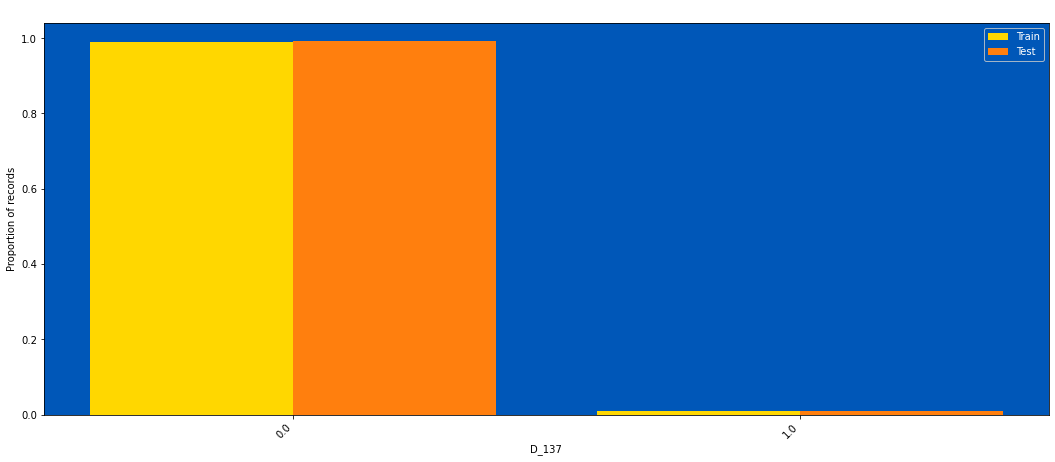

In [292]:
plot_train_test_distribution(train, test, "D_137", nunique_thr=10)

### D_138

5336752 null count, 0.965 null proportion
0.2360 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


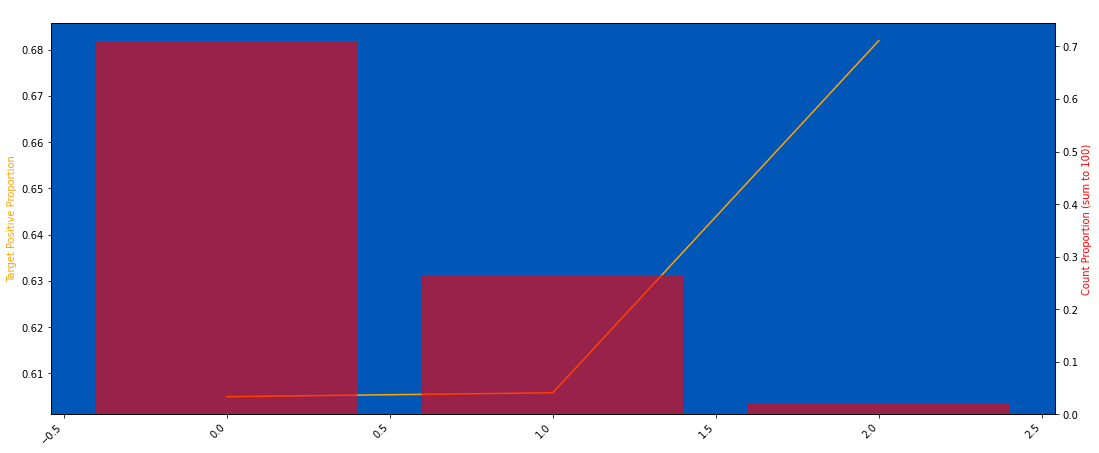

In [293]:
plot_target_check(train, "D_138", q=50, use_raw_bin=True)

Bottom 1% and Top 1% are dropped from this chart


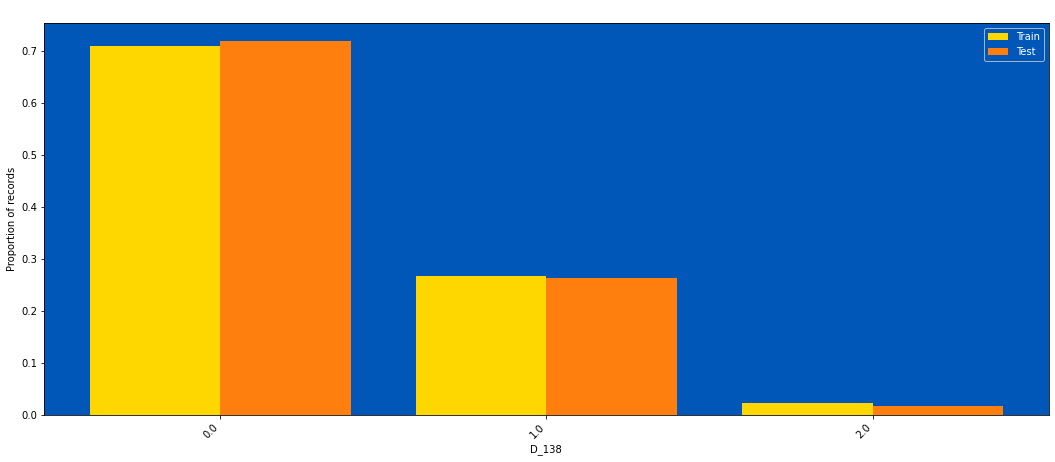

In [294]:
plot_train_test_distribution(train, test, "D_138", nunique_thr=100)

### D_139

101548 null count, 0.018 null proportion
0.3576 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


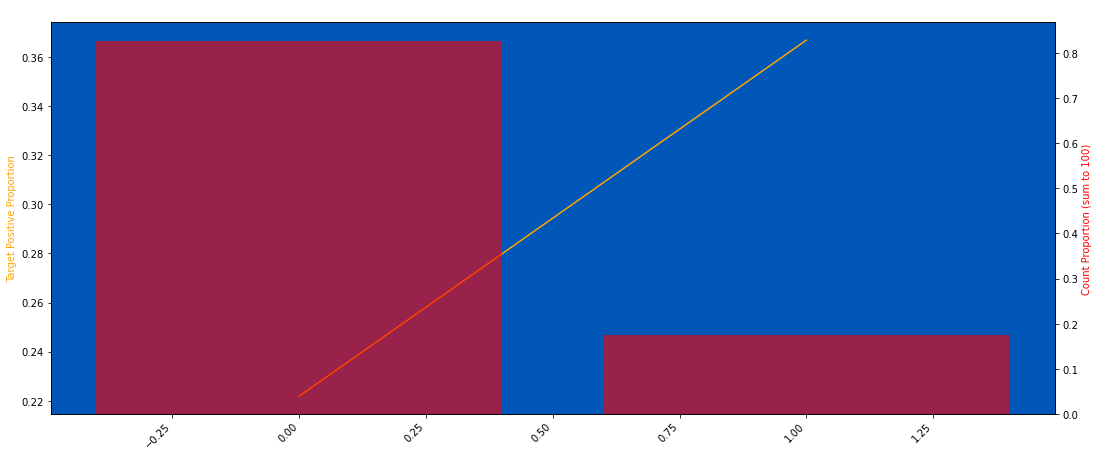

In [295]:
plot_target_check(train, "D_139", q=50, use_raw_bin=True)

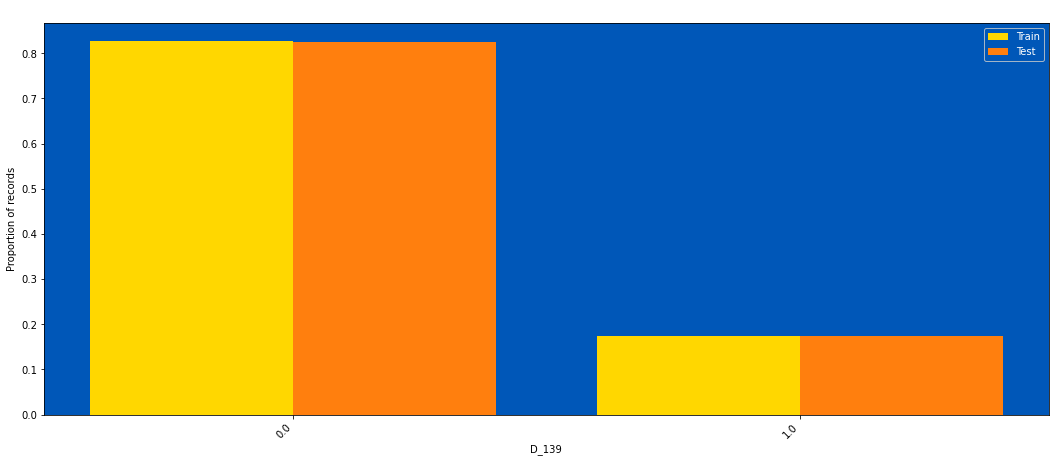

In [296]:
plot_train_test_distribution(train, test, "D_139", nunique_thr=5)

### D_140

40632 null count, 0.007 null proportion
0.4090 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


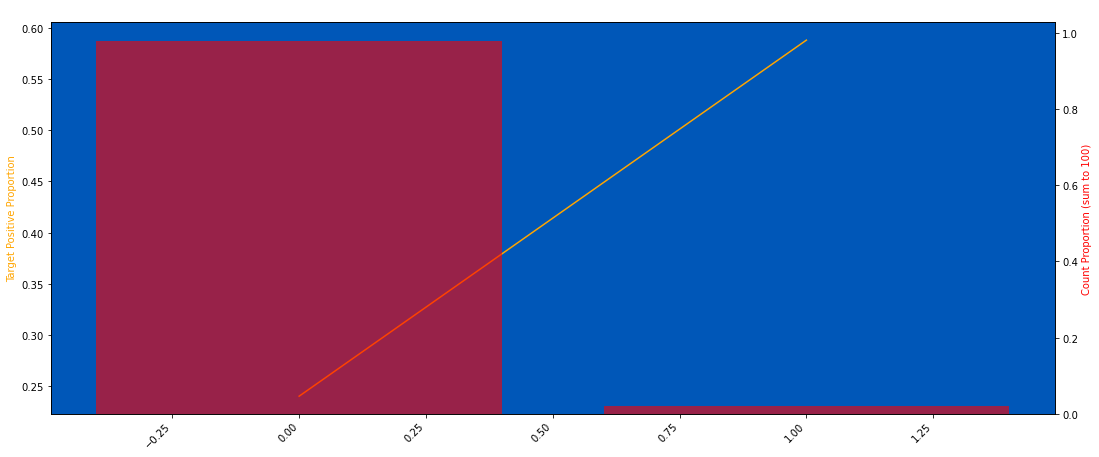

In [297]:
plot_target_check(train, "D_140", q=50, use_raw_bin=True)

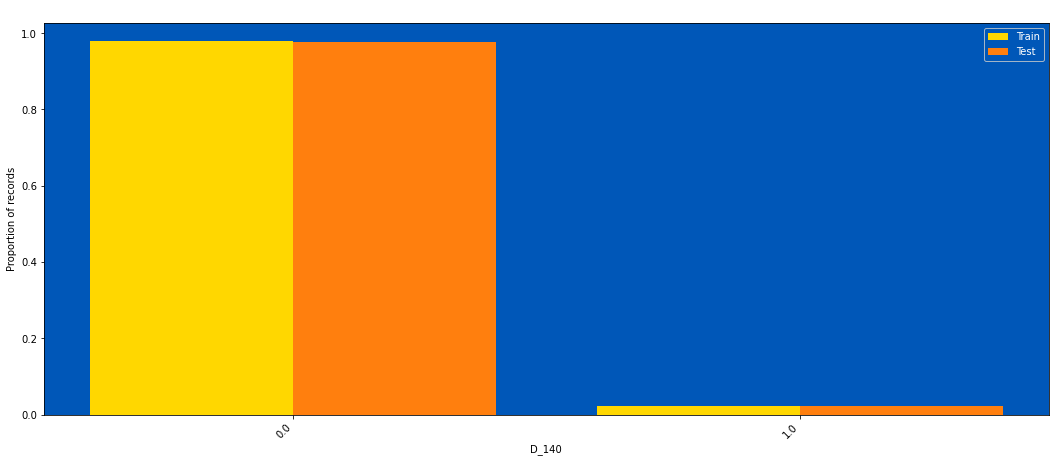

In [298]:
plot_train_test_distribution(train, test, "D_140", nunique_thr=5)

### D_141

101548 null count, 0.018 null proportion
0.3576 of the targets have label = 1


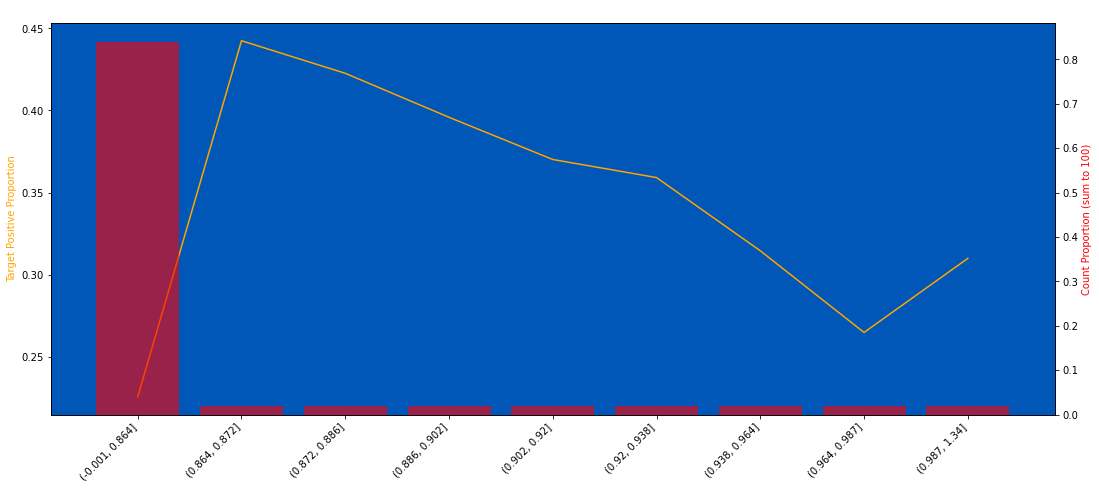

In [299]:
plot_target_check(train, "D_141", q=50, use_raw_bin=True)

In [300]:
train["D_141"] = train["D_141"].round(2)
test["D_141"] = test["D_141"].round(2)

In [301]:
train.loc[train["D_141"] == 0, "D_141"] = np.nan
test.loc[test["D_141"] == 0, "D_141"] = np.nan

4587033 null count, 0.829 null proportion
0.2248 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


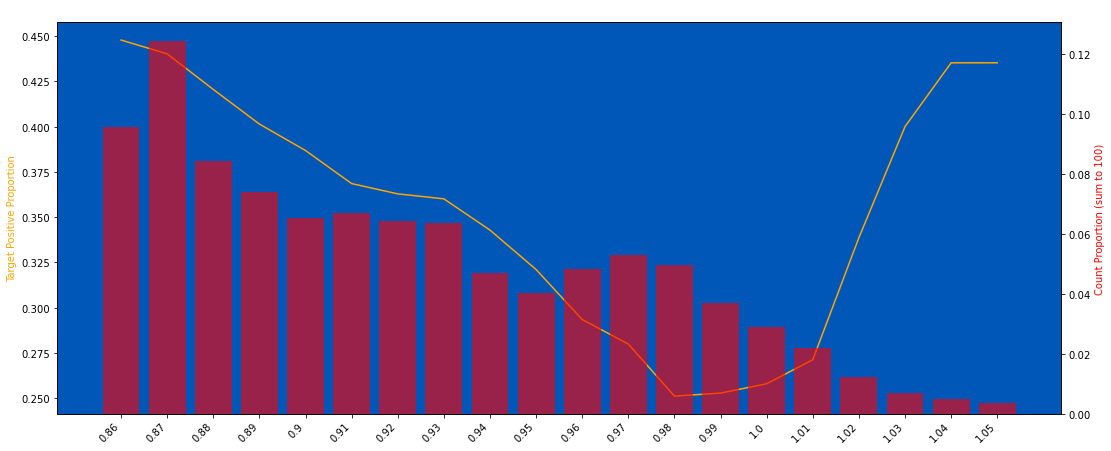

In [302]:
plot_target_check(train, "D_141", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


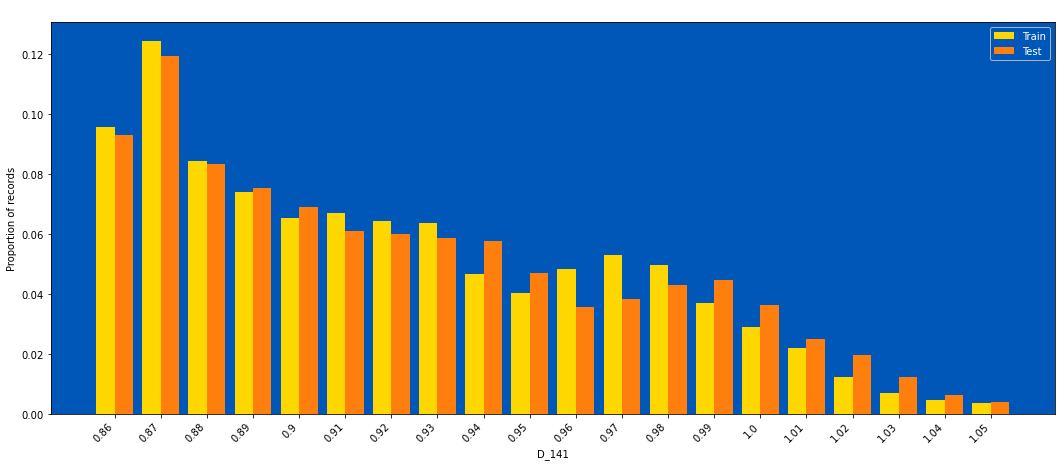

In [303]:
plot_train_test_distribution(train, test, "D_141", nunique_thr=500)

### D_142

4587043 null count, 0.829 null proportion
0.2248 of the targets have label = 1


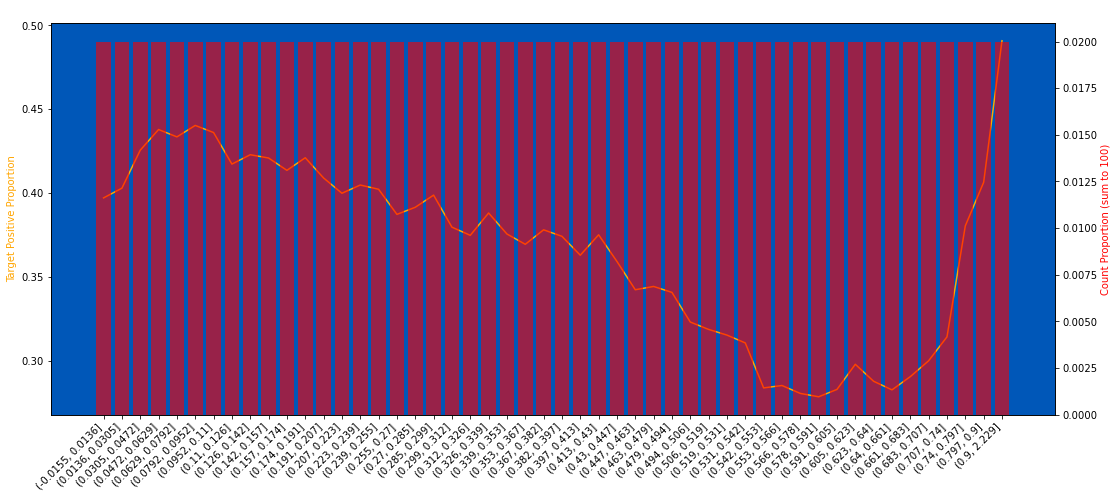

In [304]:
plot_target_check(train, "D_142", q=50, use_raw_bin=True)

In [305]:
train["D_142"] = train["D_142"].round(2)
test["D_142"] = test["D_142"].round(2)

4587043 null count, 0.829 null proportion
0.2248 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


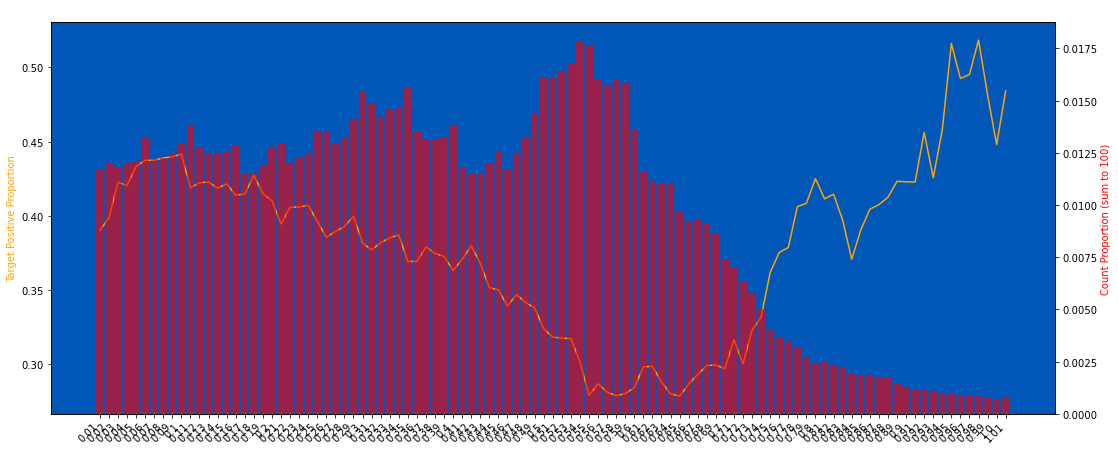

In [306]:
plot_target_check(train, "D_142", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


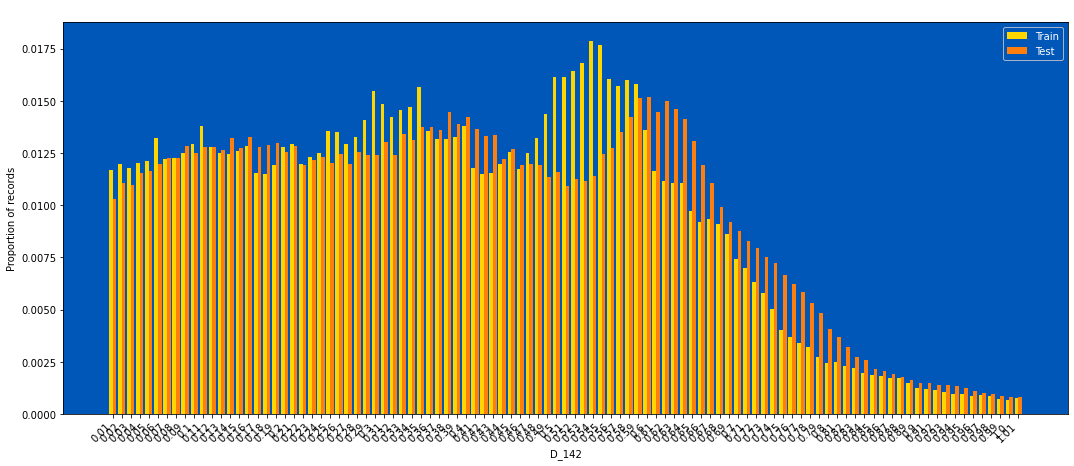

In [307]:
plot_train_test_distribution(train, test, "D_142", nunique_thr=500)

### D_143

101548 null count, 0.018 null proportion
0.3576 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


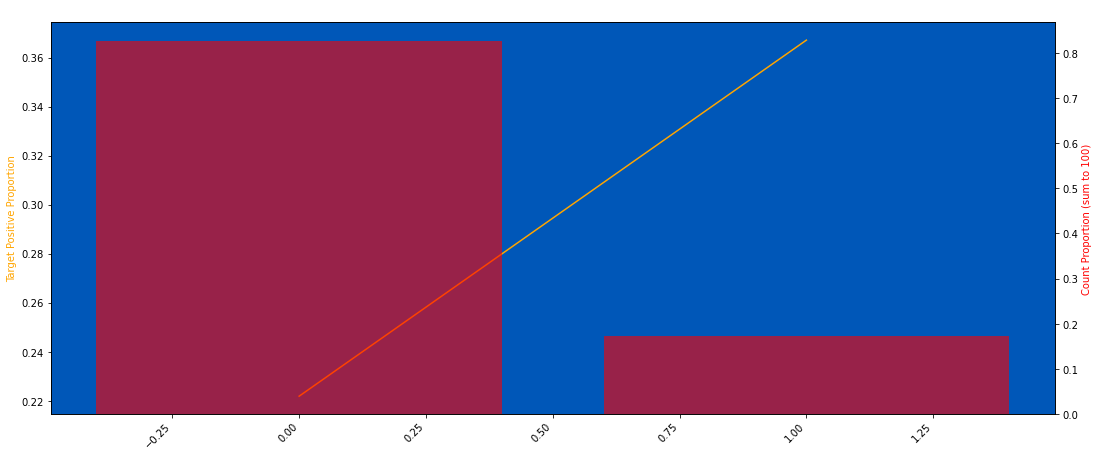

In [308]:
plot_target_check(train, "D_143", q=50, use_raw_bin=True)

Bottom 1% and Top 1% are dropped from this chart


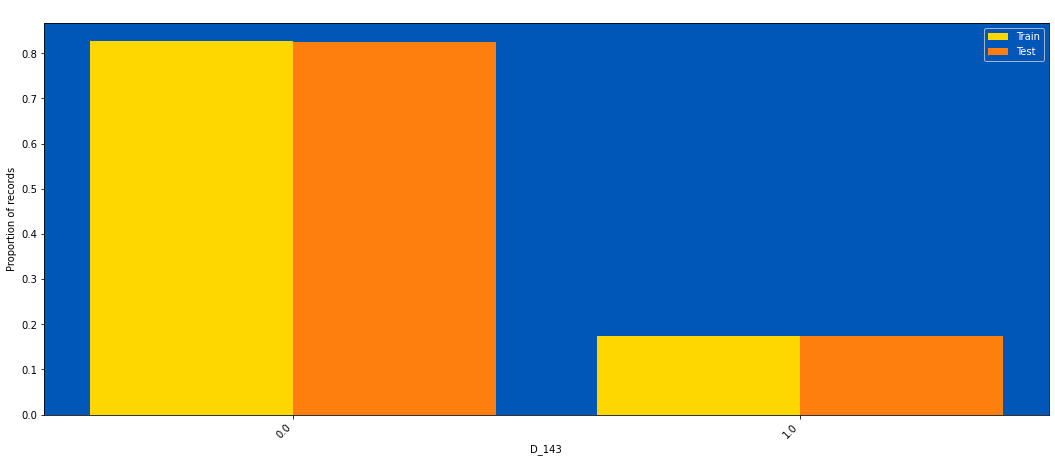

In [309]:
plot_train_test_distribution(train, test, "D_143", nunique_thr=500)

### D_144

40727 null count, 0.007 null proportion
0.4093 of the targets have label = 1


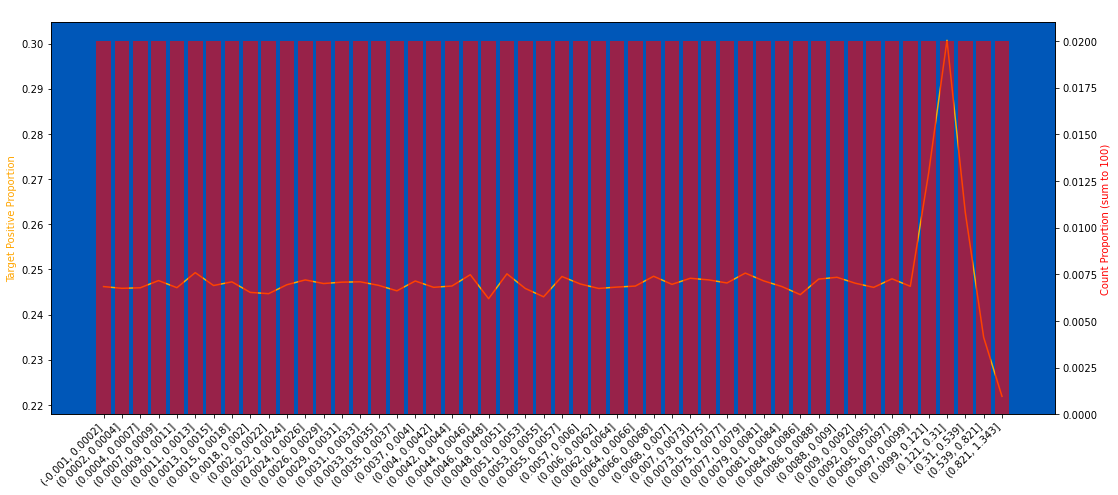

In [310]:
plot_target_check(train, "D_144", q=50, use_raw_bin=True)

In [311]:
train["D_144"] = train["D_144"].round(2)
test["D_144"] = test["D_144"].round(2)

40727 null count, 0.007 null proportion
0.4093 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


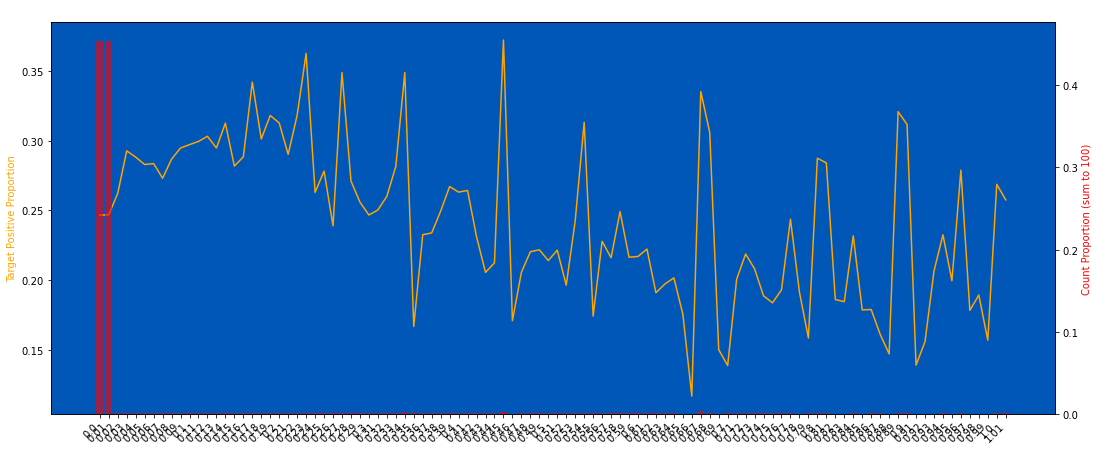

In [312]:
plot_target_check(train, "D_144", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


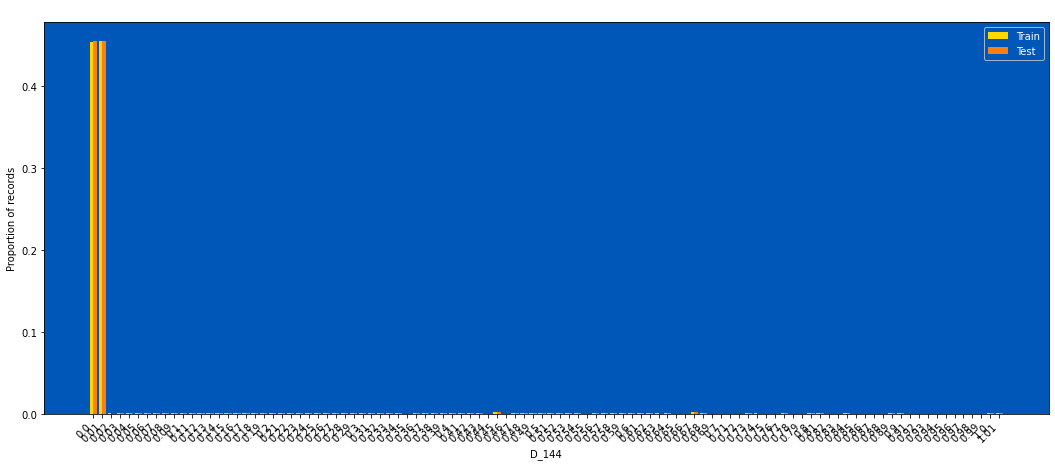

In [313]:
plot_train_test_distribution(train, test, "D_144", nunique_thr=500)

### D_145

101548 null count, 0.018 null proportion
0.3576 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


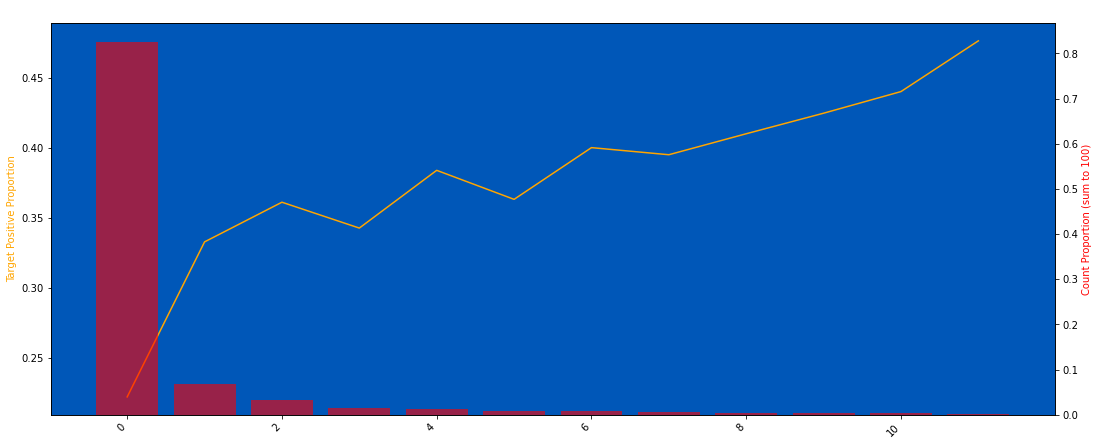

In [314]:
plot_target_check(train, "D_145", q=50, use_raw_bin=True, nunique_thr=1000)

Bottom 1% and Top 1% are dropped from this chart


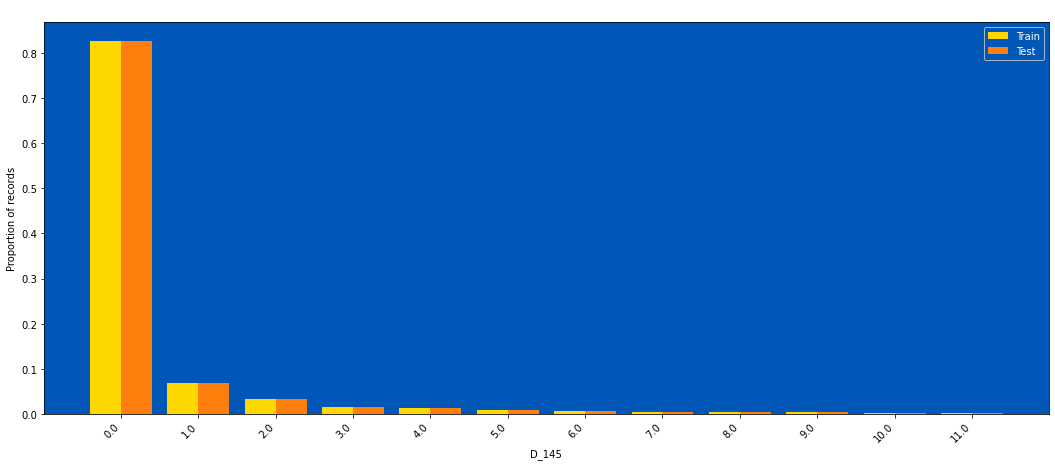

In [315]:
plot_train_test_distribution(train, test, "D_145", nunique_thr=500)

### Column checking

In [316]:
from tqdm import tqdm

In [317]:
all_columns = get_cols(train, "D_")

In [318]:
for d in tqdm(all_columns):
    neg1_series = train.loc[train[d] == -1, d]
    if len(neg1_series) > 0:
        print("Train", d, len(neg1_series))
        train[d] = train[d].replace(-1, -999)
    neg1_series = test.loc[test[d] == -1, d]
    if len(neg1_series) > 0:
        print("Test", d, len(neg1_series))
        test[d] = test[d].replace(-1, -999)

  4%|█████▌                                                                                                                                | 4/96 [00:00<00:02, 34.55it/s]

Train D_46 33
Test D_46 100


  8%|███████████▏                                                                                                                          | 8/96 [00:02<00:27,  3.22it/s]

Test D_50 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [00:05<00:00, 16.29it/s]


In [319]:
for d in tqdm(all_columns):
    neg1_series = train.loc[train[d] == -999, d]
    if len(neg1_series) > 0:
        print("Train", d, len(neg1_series))
        train[d] = train[d].replace(-999, -1)
    neg1_series = test.loc[test[d] == -999, d]
    if len(neg1_series) > 0:
        print("Test", d, len(neg1_series))
        test[d] = test[d].replace(-999, -1)

  8%|███████████▏                                                                                                                          | 8/96 [00:00<00:03, 26.01it/s]

Train D_46 33
Test D_46 100


 18%|███████████████████████▌                                                                                                             | 17/96 [00:00<00:02, 33.84it/s]

Test D_50 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [00:03<00:00, 26.24it/s]


In [320]:
d_col_nunique = train[all_columns].nunique()

In [321]:
less_unique_d_cols = d_col_nunique[d_col_nunique < 64].index.tolist()

In [322]:
for d in less_unique_d_cols:
    print(d, ":", train[d].dtype, "\n", sorted(train[d].unique().tolist()), "\n")

D_44 : float64 
 [0.0, 1.0, nan, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 32.0, 34.0, 37.0, 41.0, 42.0, 43.0, 44.0, 45.0] 

D_51 : int8 
 [0, 1, 2, 3, 4, 5, 6, 7, 8] 

D_63 : int8 
 [0, 1, 2, 3, 4, 5] 

D_64 : float64 
 [0.0, 2.0, nan, 1.0, 3.0] 

D_66 : float64 
 [nan, 0.0, 1.0] 

D_68 : float64 
 [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, nan] 

D_70 : float64 
 [0.0, 1.0, 2.0, 3.0, 4.0, nan, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0] 

D_72 : float64 
 [0.0, 1.0, 2.0, 3.0, nan, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0] 

D_74 : float64 
 [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, nan, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.

In [323]:
# for col in tqdm(less_unique_d_cols):
#     train[col] = integerize(train[col])
#     test[col] = integerize(test[col])

In [324]:
%%time
train = train.drop(columns="temp", errors="ignore")
test = test.drop(columns="temp", errors="ignore")

CPU times: user 1.92 s, sys: 9.21 s, total: 11.1 s
Wall time: 18.4 s


In [325]:
train.shape, test.shape

((5531451, 191), (11363762, 190))

### Insert row_number

In [326]:
%%time
if "row_number" not in train:
    insert_row_number(train)
    insert_row_number(test)

Done insertion
Done insertion
CPU times: user 35.3 s, sys: 524 ms, total: 35.8 s
Wall time: 35.8 s


In [327]:
# %%time
train.to_parquet(f"{RAW_TRAIN_PARQUET_PATH}/train_psrbd.parquet")
test.to_parquet(f"{RAW_TEST_PARQUET_PATH}/test_psrbd.parquet")

In [328]:
END = time.time()

In [329]:
print(f"{END - START:.2f} seconds elapsed")

616.91 seconds elapsed
